## Importing packages and data

In [24]:
## Importing packages and data
# Importing libraries
import pandas as pd
import numpy as np

# Configure matplotlib for inline plotting in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()  # Enable interactive mode
from matplotlib import colors
import seaborn as sns
import matplotlib
matplotlib.use('inline')  # or 'Qt5Agg' depending on your system
import json
import os
from pathlib import Path
import copy
import base64

from subprocess import Popen, PIPE, STDOUT
from glob import glob

import langchain  # Main LangChain import
from langchain_openai import ChatOpenAI  # To work with OpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
# from langchain_google_genai import ChatGoogleGenerativeAI # To work with Gemini (optional)
from langchain_core.output_parsers import JsonOutputParser  # To help with structured output
from langchain_core.prompts import PromptTemplate  # To help create our prompt
from langchain_core.pydantic_v1 import BaseModel, Field  # To help with defining what output structure we want
from pydantic import BaseModel
from langchain_core.tools import tool

from typing import List, Tuple

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain.load.dump import dumps
from langchain_core.messages import HumanMessage

from dotenv import load_dotenv

import logging
import sys

import ast

In [25]:
# ==========================
# Configure Logging
# ==========================

# Create a logger
logger = logging.getLogger('ReWOO_LangGraph')
logger.setLevel(logging.DEBUG)

# Clear any existing handlers attached to the logger
if logger.hasHandlers():
    logger.handlers.clear()

# Create handlers
c_handler = logging.StreamHandler(sys.stdout)
f_handler = logging.FileHandler('rewoolanggraph.log', mode='w')

c_handler.setLevel(logging.INFO)
f_handler.setLevel(logging.DEBUG)

# Create formatters and add them to handlers
c_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)


In [26]:
# ==========================
# Function to load JSON files
# ==========================

def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

In [27]:
# ==========================
# Loading Files
# ==========================

base_path = 'data/challenges/'

# Subset of challenges for testing
subset_ids_challenges = load_json(base_path + '28_8x10_challenges.json')
subset_ids_evaluation = load_json(base_path + '28_15x15_evaluation.json')

# Load evaluation dataset
evaluation_challenges = load_json(base_path + 'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path + 'arc-agi_evaluation_solutions.json')

# load training dataset
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

# Filter training challenges and solutions to only include the subset IDs
training_challenges = {k: v for k, v in training_challenges.items() if k in subset_ids_challenges}
training_solutions = {k: v for k, v in training_solutions.items() if k in subset_ids_challenges}

# filter evaluation challenges and solutions to only include the subset IDs
evaluation_challenges = {k: v for k, v in evaluation_challenges.items() if k in subset_ids_evaluation}
evaluation_solutions = {k: v for k, v in evaluation_solutions.items() if k in subset_ids_evaluation}

test_challenges = load_json(base_path + 'arc-agi_test_challenges.json')



task_sets = {
    'training': {
        'challenges': training_challenges,
        'solutions': training_solutions,
    },
    'evaluation': {
        'challenges': evaluation_challenges,
        'solutions': evaluation_solutions,
    }
}

In [28]:
# ==========================
# Function to load tasks from a pre-loaded task set
# ==========================

def load_tasks_from_file(task_set):
    """
    Loads the tasks from the pre-loaded JSON data and returns the challenges and solutions tasks.
    """
    challenges = task_set['challenges']
    solutions = task_set['solutions']

    return challenges, solutions

In [29]:
# ==========================
# Print Dataset Information
# ==========================

print(f'Number of filtered training challenges = {len(training_challenges)}')
print(f'Number of filtered training solutions = {len(training_solutions)}')

# Loading tasks from the 'training' task set
challenges, solutions = load_tasks_from_file(task_set=task_sets['training'])
print(json.dumps(challenges['0520fde7'], indent=2))  # Accessing a specific challenge

Number of filtered training challenges = 28
Number of filtered training solutions = 28
{
  "test": [
    {
      "input": [
        [
          1,
          0,
          1,
          5,
          1,
          0,
          1
        ],
        [
          0,
          1,
          0,
          5,
          1,
          0,
          1
        ],
        [
          1,
          0,
          1,
          5,
          0,
          1,
          0
        ]
      ]
    }
  ],
  "train": [
    {
      "input": [
        [
          1,
          0,
          0,
          5,
          0,
          1,
          0
        ],
        [
          0,
          1,
          0,
          5,
          1,
          1,
          1
        ],
        [
          1,
          0,
          0,
          5,
          0,
          0,
          0
        ]
      ],
      "output": [
        [
          0,
          0,
          0
        ],
        [
          0,
          2,
          0
        ],
        [
  

#### initializing LLM client to use

In [ ]:

# Load environment variables from .env file
load_dotenv('api.env')

# Get the OpenAI API key from environment variables
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key =os.getenv('ANTHROPIC_API_KEY')

# MORE EXPENSIVE MODELS
llm_openai = ChatOpenAI(model='gpt-4o', openai_api_key=openai_api_key, max_tokens=3000)
llm_anthropic = ChatAnthropic(model='claude-3-5-sonnet-20241022', anthropic_api_key=anthropic_api_key, max_tokens=3000)

# CHEAPER MODELS
#llm_openai = ChatOpenAI(model='gpt-4o-mini', openai_api_key=openai_api_key, max_tokens=3000)
#llm_anthropic = ChatAnthropic(model='claude-3-haiku-20240307', anthropic_api_key=anthropic_api_key, max_tokens=3000)

# LOCAL MODELS USING OLLAMA
#llm_local = OllamaLLM(model= "llama3.2")

### Function for visualizing the tasks

In [31]:
# ==========================
# Functions to visualize tasks
# ==========================

cmap = colors.ListedColormap(
   ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#FFFFFF'])
norm = colors.Normalize(vmin=0, vmax=10)
# print(norm)

def plot_one(ax, i, task, train_or_test, input_or_output):
    # Check if input_or_output is 'solution' or 'predicted_solution'
    if input_or_output == 'solution':
        input_matrix = task[train_or_test][i]['output']  # Assuming this is the ground truth solution
    elif input_or_output == 'predicted_solution':
        input_matrix = task.get('prediction', [])[i]  # Access the predicted solution from task
    else:
        input_matrix = task[train_or_test][i][input_or_output]

    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x - 0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x - 0.5 for x in range(1 + len(input_matrix))])
    ax.set_title(f"{train_or_test} {input_or_output}")
    return None

   
def plot_eval(task, text, test_input, predicted_solution, actual_solution):
    """
    Plots a single row with three columns: input, predicted solution, and actual solution.
    """
    try:
        # Convert inputs to numpy arrays if they aren't already
        test_input = np.array(test_input)
        predicted_solution = np.array(predicted_solution)
        actual_solution = np.array(actual_solution)
        
        plt.close('all')  # Close any existing plots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{text}', fontsize=16, fontweight='bold')

        # Plot evaluation input
        axs[0].imshow(test_input, cmap=cmap, norm=norm)
        axs[0].set_title('Evaluation Input')
        axs[0].grid(True, color='lightgrey', linewidth=0.5)
        axs[0].set_xticks([x - 0.5 for x in range(1 + len(test_input[0]))]) 
        axs[0].set_yticks([x - 0.5 for x in range(1 + len(test_input))])

        # Plot model's predicted solution
        axs[1].imshow(predicted_solution, cmap=cmap, norm=norm)
        axs[1].set_title('Model Prediction')
        axs[1].grid(True, color='lightgrey', linewidth=0.5)
        axs[1].set_xticks([x - 0.5 for x in range(1 + len(predicted_solution[0]))]) 
        axs[1].set_yticks([x - 0.5 for x in range(1 + len(predicted_solution))])

        # Plot actual solution
        axs[2].imshow(actual_solution, cmap=cmap, norm=norm)
        axs[2].set_title('Actual Solution')
        axs[2].grid(True, color='lightgrey', linewidth=0.5)
        axs[2].set_xticks([x - 0.5 for x in range(1 + len(actual_solution[0]))]) 
        axs[2].set_yticks([x - 0.5 for x in range(1 + len(actual_solution))])

        # Add value annotations to each cell
        for ax, data in zip(axs, [test_input, predicted_solution, actual_solution]):
            for i in range(len(data)):
                for j in range(len(data[0])):
                    ax.text(j, i, str(data[i][j]), 
                           ha='center', va='center',
                           color='white' if data[i][j] in [0, 1, 9] else 'black')

        plt.tight_layout()
        plt.show()
        plt.close()  # Close the plot after showing it
        
    except Exception as e:
        logger.error(f"Error in plot_eval: {str(e)}")
        plt.close('all')  # Clean up any partial plots
 
def plot_task(task1, text):    
    num_train = len(task1['train'])
    w=num_train
    fig, axs  = plt.subplots(2, w, figsize=(3*w ,3*2))
    plt.suptitle(f'{text}:', fontsize=20, fontweight='bold', y=1)

    for j in range(num_train):     
        plot_one(axs[0, j], j,task1,'train', 'input')
        plot_one(axs[1, j], j,task1,'train', 'output')  
    
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
    plt.tight_layout()
    # plt.show()
    return plt    
    
def openai_encode_image_base64(plt):
    import io
    plt_stringIObytes = io.BytesIO()
    plt.savefig(plt_stringIObytes, format='png')
    plt_stringIObytes.seek(0)
    base64_image = base64.b64encode(plt_stringIObytes.read()).decode('utf-8')
    return {
      "type": "image_url",
      "image_url": {
        "url": f"data:image/jpeg;base64,{base64_image}"
      }
    }

## Trying to make MVP product which is just regular openai model trying to predict 

In [32]:
# converting train and test pairs to a string format ideal for LLMs
def json_task_to_string(challenge_tasks: dict, task_id: str, test_input_index: int) -> str:
    """
    challenge_tasks: dict a list of tasks
    task_id: str the id of the task we want to convert to a string
    
    Convert your json task into a string so you can pass it to your LLM.
    This is a crucial step where you can use your creativity to edit how tasks are represented.
    """
    json_task = challenge_tasks[task_id]

    final_output = ""

    train_tasks = json_task['train']
    test_task = json_task['test']

    final_output = "Training Examples\n"

    for i, task in enumerate(train_tasks):
        final_output += f"Example {i + 1}: Input\n["
        for row in task['input']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"
        final_output += f"Example {i + 1}: Output\n["

        for row in task['output']:
            final_output += f"\n{str(row)},"

        final_output += "]\n\n"

    final_output += "Test\n["
    for row in test_task[test_input_index]['input']:
        final_output += f"\n{str(row)}"

    final_output += "]\n\nYour Response:"

    return final_output

In [33]:
# an example of how the function works
task_string = json_task_to_string(challenges, '0520fde7', 0)
print (task_string)

Training Examples
Example 1: Input
[
[1, 0, 0, 5, 0, 1, 0],
[0, 1, 0, 5, 1, 1, 1],
[1, 0, 0, 5, 0, 0, 0],]

Example 1: Output
[
[0, 0, 0],
[0, 2, 0],
[0, 0, 0],]

Example 2: Input
[
[1, 1, 0, 5, 0, 1, 0],
[0, 0, 1, 5, 1, 1, 1],
[1, 1, 0, 5, 0, 1, 0],]

Example 2: Output
[
[0, 2, 0],
[0, 0, 2],
[0, 2, 0],]

Example 3: Input
[
[0, 0, 1, 5, 0, 0, 0],
[1, 1, 0, 5, 1, 0, 1],
[0, 1, 1, 5, 1, 0, 1],]

Example 3: Output
[
[0, 0, 0],
[2, 0, 0],
[0, 0, 2],]

Test
[
[1, 0, 1, 5, 1, 0, 1]
[0, 1, 0, 5, 1, 0, 1]
[1, 0, 1, 5, 0, 1, 0]]

Your Response:


In [34]:
# Using a json output parser to parse the output, since LLMs aren't perfect at generating valid json
# Defining a prediction as a list of lists
class ARCPrediction(BaseModel):
    prediction: List[List] = Field(..., description="A prediction for a task")

## Setting up langgraph for mUlTiaGenTiC sYstEM

In [35]:
# Setting up the state for the graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    patterns: Annotated[list, add_messages]
    code: str
    prediction: List[List]
    task_string: str
    task_data: dict
    test_input_index: int
    predicted_grid_size: str  # Add this line



# Creating tools for the agents to manipulate the gridz

In [36]:
import copy

def get_size(grid):
    ''' Returns the size of the grid in 2 axes '''
    return (len(grid), len(grid[0]))

def get_middle(coords):
    ''' Returns the middle (centroid) of the coordinates '''
    x_sum, y_sum = 0, 0
    for (x, y) in coords:
        x_sum += int(x)
        y_sum += int(y)
    return (int(x_sum / len(coords) + 0.5), int(y_sum / len(coords) + 0.5))

def get_anchor(coords):
    ''' Returns the top-left and bottom-right anchors of the shape '''
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    for (x, y) in coords:
        min_x = min(x, min_x)
        min_y = min(y, min_y)
        max_x = max(x, max_x)
        max_y = max(y, max_y)
    return (min_x, min_y), (max_x, max_y)

def array_to_string(grid):
    ''' Converts numerical grid to string representation '''
    # If grid is already in string form, just return it
    if isinstance(grid[0][0], str):
        return grid

    mapping = {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd',
               5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j'}
    newgrid = [[mapping.get(cell, '.') for cell in row] for row in grid]
    return newgrid

def string_to_array(grid):
    ''' Converts string grid to numerical representation '''
    # If grid is already in integer form, just return it
    if isinstance(grid[0][0], int):
        return grid

    mapping = {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4,
               'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10}
    newgrid = [[mapping.get(cell, 0) for cell in row] for row in grid]
    return newgrid

def get_pixel_coords(grid):
    ''' Gets the coordinates of all the pixel values '''
    pixel_coord = {}
    for row in range(len(grid)):
        for col in range(len(grid[0])):
            value = grid[row][col]
            if value != 0:  # We assume '0' represents empty space
                if value in pixel_coord:
                    pixel_coord[value].append((row, col))
                else:
                    pixel_coord[value] = [(row, col)]
    return dict(sorted(pixel_coord.items(), key=lambda x: -len(x[1])))

def obj_to_coords(obj):
    ''' Converts an object with a grid and top-left coordinate to a list of absolute coordinates '''
    coords = []
    x, y = obj['tl']
    height, width = len(obj['grid']), len(obj['grid'][0])
    for i in range(height):
        for j in range(width):
            if obj['grid'][i][j] != 0:
                coords.append((x + i, y + j))
    return coords

def create_object(grid, coords):
    ''' Create an object based on the existing grid and the coordinates of it '''
    (min_x, min_y), (max_x, max_y) = get_anchor(coords)
    newgrid = [[0 for _ in range(max_y - min_y + 1)] for _ in range(max_x - min_x + 1)]
    for (x, y) in coords:
        if grid[x][y] == 0:
            newgrid[x - min_x][y - min_y] = -1  # Indicate empty spot with -1
        else:
            newgrid[x - min_x][y - min_y] = grid[x][y]
    return {'tl': (min_x, min_y), 'grid': newgrid}

def get_objects(grid, diag=False, multicolor=False, by_row=False, by_col=False, by_color=False, more_info=True):
    '''
    Identifies and extracts distinct objects from a grid.
    
    Parameters:
    - grid (list of list of int): The input grid where each cell contains an integer value representing a color or empty space.
    - diag (bool, optional): If True, considers diagonal connections when identifying objects. Defaults to False.
    - multicolor (bool, optional): If True, allows objects to consist of multiple colors. Defaults to False.
    - by_row (bool, optional): If True, splits objects by rows. Defaults to False.
    - by_col (bool, optional): If True, splits objects by columns. Defaults to False.
    - by_color (bool, optional): If True, groups each color as a separate object. Defaults to False.
    - more_info (bool, optional): If True, includes additional details about each object. Defaults to True.
    
    Returns:
    - list of dict: A list of dictionaries, each representing an object with:
        - 'tl' (tuple of int): Top-left coordinate of the object.
        - 'grid' (list of list of int): 2D grid representing the object's shape and colors.
        - 'size' (tuple of int): Dimensions of the object's grid (rows, columns).
        - 'cell_count' (int): Number of cells that make up the object.
        - 'shape' (list of list of int): Binary representation of the object's shape (1 for filled, 0 for empty).
    '''
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    objects = []
    missing_color = False
    
    # Check whether there is a missing color (using '10' to denote missing color)
    for each in grid:
        for cell in each:
            if cell == 10:
                missing_color = True

    def is_valid(grid, row, col, value):
        # multicolor can return any cell as long as it is not visited and not a blank
        if multicolor:
            return (0 <= row < rows and 0 <= col < cols and 
                    (row, col) not in visited and grid[row][col] != 0 and grid[row][col] != -1)
        else:
            return (0 <= row < rows and 0 <= col < cols and 
                    (row, col) not in visited and grid[row][col] == value)

    def dfs(grid, row, col, value):
        if is_valid(grid, row, col, value):
            visited.add((row, col))
            object_coords.add((row, col))
            
            if not by_row:
                dfs(grid, row - 1, col, value)  # up
                dfs(grid, row + 1, col, value)  # down
            if not by_col:
                dfs(grid, row, col - 1, value)  # left
                dfs(grid, row, col + 1, value)  # right
            if not by_row and not by_col and diag:
                dfs(grid, row - 1, col - 1, value)  # top-left diagonal
                dfs(grid, row - 1, col + 1, value)  # top-right diagonal
                dfs(grid, row + 1, col - 1, value)  # bottom-left diagonal
                dfs(grid, row + 1, col + 1, value)  # bottom-right diagonal

    # If by_color, we don't need to do dfs
    if by_color:
        pixels = get_pixel_coords(grid)
        for key, value in pixels.items():
            object_coords = value
            object_dict = create_object(grid, object_coords)
            if more_info:
                object_dict['size'] = (len(object_dict['grid']), len(object_dict['grid'][0]))
                object_dict['cell_count'] = len(object_coords)
                object_dict['shape'] = [[1 if cell != 0 else 0 for cell in row] for row in object_dict['grid']]
            objects.append(object_dict)
    else:
        for row in range(rows):
            for col in range(cols):
                value = grid[row][col]
                if (row, col) not in visited:
                    if value == 0 or value == -1:
                        continue
                    object_coords = set()
                    dfs(grid, row, col, value)
                    if not object_coords:
                        continue  # No object found
                    object_dict = create_object(grid, object_coords)
                    if more_info:
                        object_dict['size'] = (len(object_dict['grid']), len(object_dict['grid'][0]))
                        object_dict['cell_count'] = len(object_coords)
                        object_dict['shape'] = [[1 if cell != 0 else 0 for cell in row] for row in object_dict['grid']]
                    objects.append(object_dict)

        # If there's no color '10', process inner objects
        if not missing_color:
            multicolor = False
            new_objects = []
            for obj in objects:
                visited_inner = set()
                newgrid = obj['grid']
                rows_new = len(newgrid)
                cols_new = len(newgrid[0])
                for row in range(rows_new):
                    for col in range(cols_new):
                        if (row, col) not in visited_inner:
                            if newgrid[row][col] == 0:
                                object_coords = set()
                                # Define a separate DFS for inner objects
                                def dfs_inner(grid, row, col, value):
                                    if (0 <= row < rows_new and 0 <= col < cols_new and
                                        (row, col) not in visited_inner and grid[row][col] == value):
                                        visited_inner.add((row, col))
                                        object_coords.add((row, col))
                                        if not by_row:
                                            dfs_inner(grid, row - 1, col, value)  # up
                                            dfs_inner(grid, row + 1, col, value)  # down
                                        if not by_col:
                                            dfs_inner(grid, row, col - 1, value)  # left
                                            dfs_inner(grid, row, col + 1, value)  # right
                                        if not by_row and not by_col and diag:
                                            dfs_inner(grid, row - 1, col - 1, value)  # top-left diagonal
                                            dfs_inner(grid, row - 1, col + 1, value)  # top-right diagonal
                                            dfs_inner(grid, row + 1, col - 1, value)  # bottom-left diagonal
                                            dfs_inner(grid, row + 1, col + 1, value)  # bottom-right diagonal

                                dfs_inner(newgrid, row, col, 0)
                                # Check if the object does not touch the boundary
                                boundary = False
                                for x, y in object_coords:
                                    if x == 0 or x == rows_new - 1 or y == 0 or y == cols_new - 1:
                                        boundary = True
                                        break
                                if boundary:
                                    continue  # Skip objects touching the boundary
                                if not object_coords:
                                    continue  # No inner object found
                                object_dict = create_object(newgrid, object_coords)
                                cur_x, cur_y = object_dict['tl']
                                base_x, base_y = obj['tl']
                                object_dict['tl'] = (cur_x + base_x, cur_y + base_y)
                                if more_info:
                                    object_dict['size'] = (len(object_dict['grid']), len(object_dict['grid'][0]))
                                    object_dict['cell_count'] = len(object_coords)
                                    object_dict['shape'] = [[1 if cell != 0 else 0 for cell in row] for row in object_dict['grid']]
                                new_objects.append(object_dict)
            objects.extend(new_objects)
    return objects

def combine_object(obj1, obj2):
    ''' Combines two objects into a single object, overlaying them on a new grid '''
    # If not an instance of object, create it
    if not isinstance(obj1, dict):
        obj1 = {'tl': (0, 0), 'grid': obj1}
    if not isinstance(obj2, dict):
        obj2 = {'tl': (0, 0), 'grid': obj2}
    grid = empty_grid(30, 30)
    grid = fill_grid(grid, obj1['tl'], obj1['grid'])
    grid = fill_grid(grid, obj2['tl'], obj2['grid'])
    obj_coords = obj_to_coords(obj1)
    obj_coords2 = obj_to_coords(obj2)
    obj_coords.extend(obj_coords2)
    return create_object(grid, obj_coords)
    
def tight_fit(grid):
    ''' Removes all empty rows and columns from the grid, returning a tightly fitted version '''
    objects = get_objects(grid, more_info=False)
    if not objects:
        return grid  # Return the original grid if no objects found
    obj = objects[0]
    for each in objects[1:]:
        obj = combine_object(obj, each)
    return obj['grid']
                           
def fill_grid(grid, tl, pattern): 
    ''' 
    Fills a section of the grid with a specified pattern starting from a top-left coordinate.
    
    Parameters:
    - grid (list of list of int): The original grid to be filled.
    - tl (tuple of int): Top-left coordinate (row, col) where the pattern should be placed.
    - pattern (list of list of int or int): The pattern to fill into the grid. If an integer, it's treated as a single-cell pattern.
    
    Returns:
    - list of list of int: The grid after the pattern has been filled in.
    '''
    x, y = tl
    if not isinstance(pattern, list):
        pattern = [[pattern]]
    for row in range(len(pattern)):
        for col in range(len(pattern[0])):
            if 0 <= row + x < len(grid) and 0 <= col + y < len(grid[0]): 
                if pattern[row][col] != -1:
                    grid[row + x][col + y] = pattern[row][col]
    return grid

def fill_object(grid, obj, align=False):
    ''' 
    Places an object's grid into a larger grid at the object's top-left coordinate.
    
    Parameters:
    - grid (list of list of int): The larger grid where the object will be placed.
    - obj (dict): The object to place, with keys 'tl' (top-left coordinate) and 'grid' (object's grid).
    - align (bool, optional): If True, returns the object's grid without placing it into the larger grid. Defaults to False.
    
    Returns:
    - list of list of int: The grid after the object has been placed.
    '''
    if align:
        return obj['grid']
    return fill_grid(grid, obj['tl'], obj['grid'])

def empty_grid(row, col):
    ''' 
    Creates an empty grid of specified dimensions.
    
    Parameters:
    - row (int): Number of rows in the grid.
    - col (int): Number of columns in the grid.
    
    Returns:
    - list of list of int: A grid filled with zeros.
    '''
    grid = [[0 for _ in range(col)] for _ in range(row)]
    return grid

def crop_grid(grid, tl, br): 
    ''' 
    Extracts a subgrid from the original grid defined by top-left and bottom-right coordinates.
    
    Parameters:
    - grid (list of list of int): The original grid to crop.
    - tl (tuple of int): Top-left coordinate (row, col) of the subgrid.
    - br (tuple of int): Bottom-right coordinate (row, col) of the subgrid.
    
    Returns:
    - list of list of int: The cropped subgrid.
    '''
    return [[grid[i][j] for j in range(tl[1], br[1] + 1)] for i in range(tl[0], br[0] + 1)]

def fill_between_coords(grid, coord1, coord2, value): 
    ''' 
    Fills all cells between two coordinates with a specified value, forming a line.
    
    Parameters:
    - grid (list of list of int): The grid to modify.
    - coord1 (tuple of int): Starting coordinate (row, col).
    - coord2 (tuple of int): Ending coordinate (row, col).
    - value (int): The value to fill between the coordinates.
    
    Returns:
    - list of list of int: The grid after filling the specified line.
    '''
    # Fill a single point
    if coord1 == coord2:
        grid[coord1[0]][coord1[1]] = value
        return grid

    # Fill a line
    row_diff = coord1[0] - coord2[0]
    col_diff = coord1[1] - coord2[1]
    maxdist = max(abs(row_diff), abs(col_diff))
    height, width = len(grid), len(grid[0])
    for i in range(maxdist + 1):
        row_pos = coord1[0] - (i * row_diff) // maxdist
        col_pos = coord1[1] - (i * col_diff) // maxdist
        if 0 <= row_pos < height and 0 <= col_pos < width:
            grid[row_pos][col_pos] = value
    return grid

def rotate_clockwise(grid, degree=90):
    ''' 
    Rotates the grid clockwise by a specified degree.
    
    Parameters:
    - grid (list of list of int): The grid to rotate.
    - degree (int, optional): The degree of rotation (90, 180, or 270). Defaults to 90.
    
    Returns:
    - list of list of int: The rotated grid.
    '''
    newgrid = copy.deepcopy(grid)
    for _ in range(degree // 90):
        # Transpose the grid
        transposed_grid = [list(row) for row in zip(*newgrid)]
        # Reverse each row to get a clockwise rotation
        newgrid = [row[::-1] for row in transposed_grid]
    return newgrid

def horizontal_flip(grid):
    ''' 
    Flips the grid horizontally (mirror image along the vertical axis).
    
    Parameters:
    - grid (list of list of int): The grid to flip.
    
    Returns:
    - list of list of int: The horizontally flipped grid.
    '''
    return [row[::-1] for row in grid]

def vertical_flip(grid):
    ''' 
    Flips the grid vertically (mirror image along the horizontal axis).
    
    Parameters:
    - grid (list of list of int): The grid to flip.
    
    Returns:
    - list of list of int: The vertically flipped grid.
    '''
    return grid[::-1]

def fill_value(grid, pos, value):
    ''' 
    Fills a specific position in the grid with the given value.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - pos (tuple of int): The (x, y) position to fill.
    - value (int): The value to place at the specified position.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    x, y = pos
    if x < 0 or x >= len(grid) or y < 0 or y >= len(grid[0]):
        return grid
    grid[x][y] = value
    return grid

def replace(grid, pattern1, pattern2):
    ''' 
    Replaces all occurrences of a subgrid (pattern1) with another subgrid (pattern2) in the given grid.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - pattern1 (list of list of int): The subgrid to be replaced.
    - pattern2 (list of list of int): The subgrid to replace with.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    if not isinstance(pattern1, list):
        pattern1 = [[pattern1]]
    if not isinstance(pattern2, list):
        pattern2 = [[pattern2]]
    height, width = len(pattern1), len(pattern1[0])
    for i in range(len(grid) - height + 1):
        for j in range(len(grid[0]) - width + 1):
            if crop_grid(grid, (i, j), (i + height - 1, j + width - 1)) == pattern1:
                grid = fill_grid(grid, (i, j), pattern2)
    return grid

def fill_rect(grid, tl, br, value):
    ''' 
    Fills a rectangular area in the grid with the specified value.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - tl (tuple of int): The (x, y) coordinates of the top-left corner of the rectangle.
    - br (tuple of int): The (x, y) coordinates of the bottom-right corner of the rectangle.
    - value (int): The value to fill the rectangle with.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    for row in range(tl[0], br[0] + 1):
        for col in range(tl[1], br[1] + 1):
            grid = fill_value(grid, (row, col), value)
    return grid

def fill_row(grid, row_num, value, start_col=0, end_col=30):
    ''' 
    Fills a specific row in the grid with the given value from start_col to end_col.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - row_num (int): The index of the row to fill.
    - value (int): The value to fill the row with.
    - start_col (int, optional): The starting column index (inclusive). Defaults to 0.
    - end_col (int, optional): The ending column index (inclusive). Defaults to 30.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    for col_num in range(start_col, end_col + 1):
        grid = fill_value(grid, (row_num, col_num), value)
    return grid

def fill_col(grid, col_num, value, start_row=0, end_row=30): 
    ''' 
    Fills a specific column in the grid with the given value from start_row to end_row.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - col_num (int): The index of the column to fill.
    - value (int): The value to fill the column with.
    - start_row (int, optional): The starting row index (inclusive). Defaults to 0.
    - end_row (int, optional): The ending row index (inclusive). Defaults to 30.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    for row_num in range(start_row, end_row + 1):
        grid = fill_value(grid, (row_num, col_num), value)
    return grid

def change_object_pos(obj, new_tl):
    ''' 
    Changes the top-left position of an object to a new position.
    
    Parameters:
    - obj (dict): The object with 'tl' (top-left) and 'grid' keys.
    - new_tl (tuple of int): The new (x, y) coordinates for the top-left position.
    
    Returns:
    - dict: The object with the updated top-left position.
    '''
    obj['tl'] = new_tl
    return obj

def change_object_color(obj, value):
    ''' 
    Changes the color of all non-zero cells in the object's grid to the specified value.
    
    Parameters:
    - obj (dict): The object with 'tl' (top-left) and 'grid' keys.
    - value (int): The new color value to apply.
    
    Returns:
    - dict: The object with the updated colors.
    '''
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] != 0:
                obj['grid'][row][col] = value
    return obj

def get_object_color(obj):
    ''' 
    Retrieves the color of the first non-zero cell in the object's grid.
    
    Parameters:
    - obj (dict): The object with 'tl' (top-left) and 'grid' keys.
    
    Returns:
    - int: The color value of the first non-zero cell, or 0 if all cells are zero.
    '''
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] != 0:
                return obj['grid'][row][col]
    return 0

# Conditional Functions
def object_contains_color(obj, value):
    ''' 
    Returns True if the object contains the specified color, False otherwise.
    
    Parameters:
    - obj (dict): The object to check, represented as a dictionary with 'grid' key for the object's grid.
    - value (int): The color value to search for within the object's grid.
    
    Returns:
    - bool: True if the color is found in the object's grid, False otherwise.
    '''
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] == value:
                return True
    return False

def on_same_line(coord1, coord2, line_type):
    ''' 
    Returns True if coord1 is on the same line as coord2 based on the specified line_type.
    
    Parameters:
    - coord1 (tuple of int): The first coordinate as a (row, col) tuple.
    - coord2 (tuple of int): The second coordinate as a (row, col) tuple.
    - line_type (str): The type of line to check; can be 'row', 'col', or 'diag'.
    
    Returns:
    - bool: True if the coordinates are aligned according to the specified line type, False otherwise.
    '''
    if line_type == 'row':
        return coord1[0] == coord2[0]
    if line_type == 'col':
        return coord1[1] == coord2[1]
    if line_type == 'diag':
        return (coord1[0] - coord2[0]) == (coord1[1] - coord2[1])
    return False


# Unit Tests for Numerical Functions
assert get_objects([[1,1,1],[1,0,1],[1,1,1]], more_info=False) == [
    {'tl': (0, 0), 'grid': [[1, 1, 1], [1, 0, 1], [1, 1, 1]]},
    {'tl': (1, 1), 'grid': [[-1]]}
]
assert get_pixel_coords([[1,1],[4,6]]) == {1: [(0, 0), (0, 1)], 4: [(1, 0)], 6: [(1, 1)]}
assert empty_grid(3, 2) == [[0, 0], [0, 0], [0, 0]]
assert crop_grid([[1,1,2],[0,1,2]], (0, 0), (1, 1)) == [[1,1], [0,1]]
assert tight_fit([[0,0,0],[0,1,0],[0,0,0]]) == [[1]]
assert combine_object({'tl': (0, 0), 'grid': [[1,1],[1,0]]}, {'tl': (1, 1), 'grid': [[6]]}) == {'tl': (0, 0), 'grid': [[1,1], [1,6]]}
assert rotate_clockwise([[1,2],[4,5]], 90) == [[4,1],[5,2]]
assert rotate_clockwise([[1,2],[4,5]], 270) == [[2,5],[1,4]]
assert horizontal_flip([[1,2,3],[4,5,6]]) == [[3,2,1], [6,5,4]]
assert vertical_flip([[1,2,3],[4,5,6]]) == [[4,5,6], [1,2,3]]
assert replace([[1,0],[1,1]], [[1,1]], [[3,3]]) == [[1,0], [3,3]]
assert change_object_color({'tl': (0,0), 'grid': [[1,0]]}, 2) == {'tl': (0,0), 'grid': [[2,0]]}
assert get_object_color({'tl': (0,0), 'grid': [[1,0]]}) == 1
assert fill_object([[0,0],[0,0]], {'tl': (0,1), 'grid': [[3],[3]]}) == [[0,3],[0,3]]
assert fill_value([[0,1],[0,1]], (1,1), 2) == [[0,1],[0,2]]
assert fill_row([[1,1],[3,1]], 0, 2) == [[2,2],[3,1]]
assert fill_col([[1,1],[3,1]], 0, 2) == [[2,1],[2,1]]
assert fill_rect([[1,1],[3,1]], (0,0), (1,1), 2) == [[2,2],[2,2]]
assert fill_between_coords([[0,0]], (0,0), (0,1), 1) == [[1,1]]

# Conditional Functions

def object_contains_color(obj, value):
    ''' 
    Returns True if the object contains the specified color, False otherwise.
    
    Parameters:
    - obj (dict): The object to check, represented as a dictionary with 'grid' key for the object's grid.
    - value (int): The color value to search for within the object's grid.
    
    Returns:
    - bool: True if the color is found in the object's grid, False otherwise.
    '''
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] == value:
                return True
    return False

def on_same_line(coord1, coord2, line_type):
    ''' 
    Returns True if coord1 is on the same line as coord2 based on the specified line_type.
    
    Parameters:
    - coord1 (tuple of int): The first coordinate as a (row, col) tuple.
    - coord2 (tuple of int): The second coordinate as a (row, col) tuple.
    - line_type (str): The type of line to check; can be 'row', 'col', or 'diag'.
    
    Returns:
    - bool: True if the coordinates are aligned according to the specified line type, False otherwise.
    '''
    if line_type == 'row':
        return coord1[0] == coord2[0]
    if line_type == 'col':
        return coord1[1] == coord2[1]
    if line_type == 'diag':
        return (coord1[0] - coord2[0]) == (coord1[1] - coord2[1])
    return False

# Unit Tests for Conditional Functions
assert object_contains_color({'tl': (0,0), 'grid': [[1]]}, 1) == True
assert on_same_line((1,1), (1,2), 'row') == True
assert on_same_line((1,1), (2,1), 'col') == True
assert on_same_line((1,1), (2,2), 'diag') == True

# Updated Helper Functions with Numerical Representations
helper_functions = '''- get_objects(grid, diag=False, multicolor=False, by_row=False, by_col=False, by_color=False, more_info=True): 
    Takes in grid, returns list of object dictionaries with:
        - 'tl': Top-left coordinate of object
        - 'grid': 2D grid representing the object
    Parameters:
        - by_row: Splits objects by grid rows
        - by_col: Splits objects by grid columns
        - by_color: Groups each color as one object
        - multicolor: Allows objects to consist of multiple colors
    Notes:
        - Empty cells within objects are represented as -1
        - If more_info is True, also returns:
            - 'size': Dimensions of the grid (rows, columns)
            - 'cell_count': Number of cells in the object
            - 'shape': Binary representation of the object's shape (1 for filled, 0 for empty)
- get_pixel_coords(grid): 
    Returns a dictionary with keys as pixel values and values as lists of coordinates, sorted from most number of pixels to least
- empty_grid(row, col): 
    Returns an empty grid of height row and width col filled with zeros
- crop_grid(grid, tl, br): 
    Returns a cropped section from top-left (tl) to bottom-right (br) of the grid
- tight_fit(grid): 
    Returns grid with all empty rows and columns removed
- combine_object(obj_1, obj_2): 
    Returns combined object from obj_1 and obj_2. If overlapping, obj_2 overwrites obj_1
- rotate_clockwise(grid, degree=90): 
    Returns grid rotated clockwise by 90, 180, or 270 degrees
- horizontal_flip(grid): 
    Returns a horizontally flipped grid
- vertical_flip(grid): 
    Returns a vertically flipped grid
- replace(grid, pattern1, pattern2): 
    Replaces all occurrences of pattern1 with pattern2 in grid
- get_object_color(obj): 
    Returns the color of the object. If multicolor, returns the first color only
- change_object_color(obj, value): 
    Changes the object's color to the specified value
- fill_object(grid, obj, align=False): 
    Fills grid with object. If align is True, makes grid the same size as the object
- fill_row(grid, row_num, value, start_col=0, end_col=30): 
    Fills a row in the grid with a specified value from start_col to end_col (inclusive)
- fill_col(grid, col_num, value, start_row=0, end_row=30): 
    Fills a column in the grid with a specified value from start_row to end_row (inclusive)
- fill_between_coords(grid, coord_1, coord_2, value): 
    Fills a line between coord_1 and coord_2 with the specified value
- fill_rect(grid, tl, br, value): 
    Fills a rectangle in the grid from top-left (tl) to bottom-right (br) with the specified value
- fill_value(grid, pos, value): 
    Fills a specific position in the grid with the given value
- object_contains_color(obj, value): 
    Returns True/False if object contains a certain value
- on_same_line(coord_1, coord_2, line_type): 
    Returns True/False if coord_1 is on the same line as coord_2. line_type can be one of ['row', 'col', 'diag']
'''

# Updated Conditional Functions with Numerical Representations
conditional_functions = '''
object_contains_color(obj, value): returns True/False if object contains a certain value
on_same_line(coord_1, coord_2, line_type): Returns True/False if coord_1 is on the same line as coord_2. line_type can be one of ['row', 'col', 'diag']
'''

all_tools = {
    "get_size": get_size,
    "get_middle": get_middle,
    "get_anchor": get_anchor,
    "array_to_string": array_to_string,
    "string_to_array": string_to_array,
    "get_pixel_coords": get_pixel_coords,
    "obj_to_coords": obj_to_coords,
    "create_object": create_object,
    "get_objects": get_objects,
    "combine_object": combine_object,
    "tight_fit": tight_fit,
    "fill_grid": fill_grid,
    "fill_object": fill_object,
    "empty_grid": empty_grid,
    "crop_grid": crop_grid,
    "fill_between_coords": fill_between_coords,
    "rotate_clockwise": rotate_clockwise,
    "horizontal_flip": horizontal_flip,
    "vertical_flip": vertical_flip,
    "fill_value": fill_value,
    "replace": replace,
    "fill_rect": fill_rect,
    "fill_row": fill_row,
    "fill_col": fill_col,
    "change_object_pos": change_object_pos,
    "change_object_color": change_object_color,
    "get_object_color": get_object_color,
    "object_contains_color": object_contains_color,
    "on_same_line": on_same_line,
}






#### Generating nodes

In [37]:
# Building nodes for the graph
# first initialize the StateGraph
graph_builder = StateGraph(State)
import ast

# ==========================
# Function to get the grid size prediction. Has 86% accuracy on the training set.
# ==========================
def predict_task_grid_size(train_inputs, train_outputs, test_inputs):
    """
    Predicts the grid size of test inputs based on patterns from the train inputs and outputs.

    Args:
    - train_inputs: List of 2D arrays representing the input grids for training.
    - train_outputs: List of 2D arrays representing the output grids for training.
    - test_inputs: List of 2D arrays representing the input grids for testing.

    Returns:
    - pred_test_sizes: List of predicted sizes for the test outputs in 'WxH' format (e.g., '6x6').
    """

    # Calculate the sizes of train inputs and outputs
    train_in_size = [[len(i[0]), len(i)] for i in train_inputs]
    train_out_size = [[len(i[0]), len(i)] for i in train_outputs]

    # Calculate the sizes of test inputs
    test_in_size = [[len(i[0]), len(i)] for i in test_inputs]

    # Try to detect consistent ratio patterns
    ratio_x = train_in_size[0][0] / train_out_size[0][0]
    ratio_y = train_in_size[0][1] / train_out_size[0][1]

    # Check for consistent ratios in the training set
    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] / out_size[0] != ratio_x or in_size[1] / out_size[1] != ratio_y:
            break
    else:
        # If the ratio holds, predict based on the ratio
        pred_test_sizes = [f"{int(i[0] / ratio_x)}x{int(i[1] / ratio_y)}" for i in test_in_size]
        return pred_test_sizes

    # If ratio-based prediction fails, check for consistent subtraction patterns
    sub_x = train_in_size[0][0] - train_out_size[0][0]
    sub_y = train_in_size[0][1] - train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] - out_size[0] != sub_x or in_size[1] - out_size[1] != sub_y:
            break
    else:
        # If subtraction holds, predict based on subtraction
        pred_test_sizes = [f"{i[0] - sub_x}x{i[1] - sub_y}" for i in test_in_size if i[0] - sub_x > 0 and i[1] - sub_y > 0]
        return pred_test_sizes

    # If subtraction-based prediction fails, predict based on the size of the last output grid
    last_x = train_out_size[0][0]
    last_y = train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if out_size[0] != last_x or out_size[1] != last_y:
            break
    else:
        # If all output grids are the same size, predict this size for all test inputs
        pred_test_sizes = [f"{last_x}x{last_y}" for _ in test_in_size]
        return pred_test_sizes

    # If no pattern holds, return 'Unknown' indicating an unknown prediction
    pred_test_sizes = ['Unknown' for _ in test_in_size]
    return pred_test_sizes



# ==========================
# Helper Function to Convert Messages
# ==========================

def convert_messages(message_list):
    return [
        msg.content if isinstance(msg, (AIMessage, HumanMessage)) else str(msg)
        for msg in message_list
    ]

def make_serializable(obj):
    if isinstance(obj, (AIMessage, HumanMessage)):
        return obj.content
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj  # Assume the object is already serializable

# ==========================
# execute_code with Syntax Checking and Logging
# ==========================

def execute_code(state: State):
    code = state['code']
    task_data = state['task_data']
    test_input_index = state['test_input_index']
    test_input = task_data['test'][test_input_index]['input']

    # Log the code for debugging
    logger.debug(f"Generated code for solve_task:\n{code}")

    # Syntax check
    try:
        ast.parse(code)
    except SyntaxError as se:
        logger.error(f"Syntax error in generated code: {se.text}\nError at line {se.lineno}, column {se.offset}")
        return {"prediction": [], "revised_code": code}

    # Prepare execution environment
    local_vars = {}
    global_vars = {name: func for name, func in all_tools.items()}

    # Include necessary built-in modules
    global_vars.update({
        "np": np,
        "pd": pd,
        "json": json,
        "copy": copy
    })

    try:
        exec(code, global_vars, local_vars)
        solve_task = local_vars.get('solve_task') or global_vars.get('solve_task')
        if not solve_task:
            raise Exception("solve_task function not defined in code.")

        # Validate that solve_task is callable and has the correct signature
        if not callable(solve_task):
            raise Exception("solve_task is not callable.")

        expected_signature = inspect.signature(solve_task)
        if len(expected_signature.parameters) != 1:
            raise Exception("solve_task should accept exactly one argument: input_grid.")

        # Execute solve_task and log prediction output
        prediction = solve_task(test_input)
        if not prediction:
            logger.warning("solve_task returned an empty output.")
        else:
            logger.debug(f"solve_task output:\n{prediction}")
    except Exception as e:
        prediction = []
        logger.error(f"Error executing solve_task: {e}")

    return {"prediction": prediction, "revised_code": code}



# ==========================
# generate_code with Enhanced Prompt
# ==========================

import re  # Import this at the top of your file to use regex for stripping

def clean_code_output(code: str) -> str:
    """
    Function to clean up the code generated by the LLM.
    Strips out markdown-like syntax like ```python and ```.
    """
    # Use regex to remove markdown code block markers and unnecessary spaces
    cleaned_code = re.sub(r'```[\w]*', '', code).strip()
    return cleaned_code

import inspect

import inspect

def generate_code(state: State):
    patterns = state['patterns'][-1]
    task_string = state['task_string']

    # Log the inputs for debugging
    logger.debug(f"Task String:\n{task_string}")
    logger.debug(f"Patterns:\n{patterns}")

    # Base prompt
    base_prompt = (
        "You are an expert Python programmer tasked with creating a function `solve_task(input_grid)`\n"
        "to solve a grid manipulation task using the following tools:\n"
        "These are the helper functions you can use:\n{helper_functions}\n\n"
        "Each helper function can be conditional. The conditions can be:\n"
        "- by attribute, such as shape, color, position, size, cell number of object\n"
        "- the condition can be an attribute on all objects, for instance, objects with the most common or least common value, or objects with the most or least common shape\n"
        "- by position of pixels, such as row or column\n\n"
        "These are the conditional functions to help you:\n{conditional_functions}\n\n"
        "Task Description:\n{task_string}\n\n"
        "Patterns Detected:\n{patterns}\n\n"
        "Instructions:\n"
        "- Implement the function `solve_task(input_grid)` using **only** the provided tools by their exact names.\n"
        "- **Do not define any new helper functions** within or outside `solve_task`.\n"
        "- **Do not modify or redefine** any existing tools.\n"
        "- Ensure that each tool is called with the correct number of arguments as per its signature.\n"
        "- All grid manipulations should be done using lists of lists (integers), not strings.\n"
        "- **Do not import any new modules**; use only the tools provided.\n"
        "- **Do not include any print statements** or logging within `solve_task`.\n"
        "- Return only the Python code for `solve_task` without additional explanations or comments.\n\n"
        "For example, to fill a 3x3 subgrid starting at row 0, column 0 with value 5, you would call:\n"
        "fill_grid(grid, 0, 0, 5, 3, 3)\n\n"
        "Your code:"
    )

    # Incorporate feedback if available
    if 'feedback' in state:
        prompt_text = (
            f"{base_prompt}\n\n"
            f"Feedback from previous trial:\n{state['feedback']}\n\n"
            "Please provide the corrected code:"
        )
    else:
        prompt_text = base_prompt

    prompt = PromptTemplate(
        template=prompt_text,
        input_variables=["task_string", "patterns", "helper_functions", "conditional_functions"]
    )

    # Combine the prompt with the LLM
    chain = prompt | llm_anthropic
    code = chain.invoke({
        "task_string": task_string,
        "patterns": patterns,
        "helper_functions": helper_functions,
        "conditional_functions": conditional_functions
    }).content.strip()

    # Clean the generated code
    code = clean_code_output(code)

    # Log the generated code for debugging
    logger.debug(f"Generated Code:\n{code}")

    return {"code": code}




def revise_code(state: State):
    code = state['code']

    # Define a prompt that explicitly instructs the model to return only the code
    # Define the prompt that includes helper and conditional functions
    prompt = PromptTemplate(
        template=(
            "You are an expert Python programmer. Improve the following `solve_task(input_grid)` function by correcting any syntax errors and handling edge cases.\n"
            "Use **only** the provided helper functions and conditional functions listed below.\n"
            "Do **not** define any new helper functions or modify existing ones.\n"
            "**Return ONLY the corrected `solve_task(input_grid)` function code without any additional text, comments, or explanations.**\n\n"
            "Helper Functions:\n{helper_functions}\n\n"
            "Conditional Functions:\n{conditional_functions}\n\n"
            "Code:\n{code}\n\n"
            "Corrected code:"
        ),
        input_variables=["code", "helper_functions", "conditional_functions"]
    )

    chain = prompt | llm_anthropic
    revised_code = chain.invoke({
    "code": code,
    "helper_functions": helper_functions,
    "conditional_functions": conditional_functions
    }).content.strip()

    # Use regex to remove any leading statements like "Here is the corrected code:", etc.
    revised_code = re.sub(r"^(Here|Here’s|Here is|Corrected code:|Revised code:|The corrected code:|Here's the corrected code|)", "", revised_code, flags=re.IGNORECASE).strip()

    # Further clean up by removing any non-code elements, ensuring only the Python code remains
    # Strip Markdown code block markers or extraneous non-code content
    revised_code = re.sub(r"^```(?:python)?|```$", "", revised_code, flags=re.MULTILINE).strip()

    return {"code": revised_code}


# ==========================
# identify_logic Function
# ==========================

def identify_logic(state: State):
    task_string = state['task_string']
    predicted_grid_size = state.get('predicted_grid_size')
    
    logger.info(f"Identifying logic for task: {task_string} with predicted grid size: {predicted_grid_size}")
    prompt = PromptTemplate(
        template=(
            "You are an AI assistant specializing in puzzle solving.\n\n"
            "You are given a series of inputs and output pairs. \n"
            "The values from '1' to '10' represent different colors. '0' is a blank cell. \n"
            "For example, [['0','1','0'],['0','0','2']] represents a 2 row x 3 col grid with color 1 at position (1,0) and color 2 at position (2,1).\n"
            "Coordinates are 2D positions (row, col), row representing row number, col representing col number, with zero-indexing.\n"
            "Input/output pairs may not reflect all possibilities, you are to infer the simplest possible relation.\n"
            "Given the following task, identify the logic or pattern present in the training examples.\n"
            "Objects are tight-fitted grids (no empty row or column) with a top left coordinate, which can be used for easy manipulation of multiple coordinates."
            "Provide a brief description of the logic in bullet points including the predicted grid size.\n\n"
            "Task:\n{task_string}\n\n"
            "Calculated predicted grid size for this task is {predicted_grid_size}.\n\n"
            "Make your response in the following format:\n"
            "reflection: reflect on the answer and provide a brief explanation\n"
            "pixel_changes: describe the changes between the input and output pixels, focusing on movement or pattern changes\n"
            "object_changes: describe the changes between the input and output objects, focusing on movement, object number, size, shape, position, value, cell count"
        ),
        input_variables=["task_string", "predicted_grid_size"]
    )

    chain = prompt | llm_openai
    output = chain.invoke({
        "task_string": task_string,
        "predicted_grid_size": predicted_grid_size
    }).content

    # Return both the AIMessage and the predicted_grid_size
    return {
        "messages": [AIMessage(content=output)],
        "predicted_grid_size": predicted_grid_size  # Include this in the return
    }


# ==========================
# recognize_patterns Function
# ==========================

def recognize_patterns(state: State):
    task_analysis = state['task_string']
    previous_analysis = state['messages'][-1].content if state['messages'] else ""

    # Define the prompt for selecting relevant tools
    prompt = PromptTemplate(
        template=(
            "Based on the task analysis, identify and select the most relevant tools.\n\n"
            "Task Analysis:\n{task_analysis}\n\n"
            "Available Tools:\n"
            "{helper_functions}\n\n"
            "List the tool names that would be useful for this task."
        ),
        input_variables=["task_analysis", "helper_functions"]
    )

    # Run the prompt with the task analysis and all available tools
    chain = prompt | llm_openai
    output = chain.invoke({
        "task_analysis": task_analysis,
        "helper_functions": helper_functions
    }).content

    return {"patterns": output}

#### Building the graph with eches

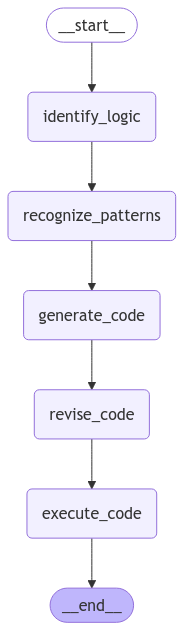

In [38]:
# Import necessary modules
from IPython.display import Image, display

# Adding nodes to the graph for each agent function
graph_builder.add_node("identify_logic", identify_logic)
graph_builder.add_node("recognize_patterns", recognize_patterns)
graph_builder.add_node("generate_code", generate_code)
graph_builder.add_node("revise_code", revise_code)
graph_builder.add_node("execute_code", execute_code)

# Define edges between nodes to establish the flow between agents
graph_builder.add_edge(START, "identify_logic")
graph_builder.add_edge("identify_logic", "recognize_patterns")
graph_builder.add_edge("recognize_patterns", "generate_code")
graph_builder.add_edge("generate_code", "revise_code")
graph_builder.add_edge("revise_code", "execute_code")
graph_builder.add_edge("execute_code", END)

# Compile the graph for execution
graph = graph_builder.compile()

# Display the compiled graph visually
try:
    # Display the graph in Mermaid format with xray view enabled
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("Error displaying the graph:", e)


### Creating function to get task prediction, make prompt, make API calls to model and parse output with retries

In [39]:
def get_task_prediction(challenge_tasks, solutions, task_id, test_input_index, plot=False):
    task_string = json_task_to_string(challenge_tasks, task_id, test_input_index)
    task_data = challenge_tasks[task_id]
    
    train_tasks = task_data['train']
    train_inputs = [t['input'] for t in train_tasks]
    train_outputs = [t['output'] for t in train_tasks]
    test_input = task_data['test'][test_input_index]['input']
    
    # Ensure you have the actual solution
    actual_solution = solutions.get(task_id, [])[test_input_index]
    
    # Predict the grid size
    predicted_grid_size = predict_task_grid_size(train_inputs, train_outputs, [test_input])[0]

    initial_state = {
        'task_string': task_string,
        'task_data': task_data,
        'test_input_index': test_input_index,
        'predicted_grid_size': predicted_grid_size,
        'messages': [],
        'patterns': [],
        'code': '',
        'revised_code': '',
        'prediction': []
    }

    # Invoke the graph or prediction model
    final_state = graph.invoke(initial_state)
    predicted_solution = final_state.get('prediction', [])

    # Add debugging print statements
    if plot:
        try:
            print("Debug - Plotting dimensions:")
            print(f"Test input shape: {np.array(test_input).shape}")
            print(f"Predicted solution shape: {np.array(predicted_solution).shape}")
            print(f"Actual solution shape: {np.array(actual_solution).shape}")
            
            # Only plot if we have valid arrays
            if len(predicted_solution) > 0:
                logger.info(f"Plotting results for task {task_id}, attempt {test_input_index}")
                plot_eval(task_data, f"Task {task_id} Attempt", test_input, predicted_solution, actual_solution)
            else:
                logger.warning("Skipping plot - predicted solution is empty")
        except Exception as e:
            logger.error(f"Error during plotting: {str(e)}")
            plt.close('all')  # Clean up any partial plots

    # Extract messages and return structured output
    messages = final_state.get('messages', [])
    if messages:
        messages = [msg.content if isinstance(msg, AIMessage) else msg for msg in messages]

    output_details = {
        'messages': messages,
        'patterns': final_state.get('patterns', []),
        'code': final_state.get('code', ''),
        'revised_code': final_state.get('revised_code', ''),
        'prediction': predicted_solution
    }

    return output_details

In [40]:
def make_serializable(obj):
    if isinstance(obj, (AIMessage, HumanMessage)):
        return obj.content
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj  # Assume the object is already serializable

def run_model(challenges, solutions, NUM_ATTEMPTS=2, RETRY_ATTEMPTS=3, NUM_TASKS=None):
    submission = {}
    detailed_outputs = {}

    for i, task_id in enumerate(challenges):
        task_attempts = []
        detailed_outputs[task_id] = []

        # Iterate through each test pair for a prediction
        for t, pair in enumerate(challenges[task_id]['test']):
            logger.info(f"Starting task #{i + 1} ({task_id}), pair #{t+1}")

            # Get the predicted grid size
            train_tasks = challenges[task_id]['train']
            train_inputs = [t['input'] for t in train_tasks]
            train_outputs = [t['output'] for t in train_tasks]
            test_input = challenges[task_id]['test'][t]['input']
            predicted_grid_size = predict_task_grid_size(train_inputs, train_outputs, [test_input])[0]

            pair_attempts = {}
            pair_detailed = {
                'predicted_grid_size': predicted_grid_size  # Add the predicted grid size here
            }

            # Make attempts with retries
            for attempt in range(1, NUM_ATTEMPTS + 1):
                attempt_key = f"attempt_{attempt}"
                pair_attempts[attempt_key] = []
                pair_detailed[attempt_key] = {
                    'predicted_grid_size': predicted_grid_size  # Add it to each attempt as well
                }

                # Run retries within the attempt
                for retry in range(RETRY_ATTEMPTS):
                    # Always plot in notebook
                    should_plot = True
                    logger.info(f"Plot flag for task {task_id}, attempt {attempt}, retry {retry}: {should_plot}")

                    try:
                        prediction_details = get_task_prediction(
                            challenge_tasks=challenges,
                            solutions=solutions,
                            task_id=task_id,
                            test_input_index=t,
                            plot=should_plot
                        )

                        # Print prediction details for debugging
                        print(f"\nPrediction details for {attempt_key}, retry {retry}:")
                        print(f"Prediction: {prediction_details['prediction']}")
                        print(f"Expected solution: {solutions[task_id][t]}")

                        # Store valid prediction and exit retry loop on success
                        if prediction_details['prediction']:  # Only store if we have a prediction
                            pair_attempts[attempt_key] = prediction_details['prediction']
                            pair_detailed[attempt_key] = prediction_details
                            
                            # Check if prediction matches solution
                            if prediction_details['prediction'] == solutions[task_id][t]:
                                print(f"Found correct solution in {attempt_key}, retry {retry}")
                                break
                            
                        break  # Exit retry loop if we got any valid prediction
                    except Exception as e:
                        logger.warning(f"Retrying: {e}")
                        if retry == RETRY_ATTEMPTS - 1:
                            pair_attempts[attempt_key] = []
                            pair_detailed[attempt_key] = {'error': str(e)}

            task_attempts.append(pair_attempts)
            detailed_outputs[task_id].append(pair_detailed)

        submission[task_id] = task_attempts

        if NUM_TASKS is not None and i + 1 == NUM_TASKS:
            break

    # Save detailed outputs
    serializable_outputs = make_serializable(detailed_outputs)
    with open('detailed_outputs.json', 'w') as f:
        json.dump(serializable_outputs, f, indent=2)

    return submission

### Creating submission files and comparing it with solutions file

In [41]:
# create submission file
def create_submission_file(submission, file_name='submission.json'):
    """
    Save a submission file to the specified file name
    """
    with open(file_name, "w") as file:
        json.dump(submission, file)

    print (f"Submission saved to {file_name}")

In [42]:
# Create function to compare submission with solutions
def score_submission(submission_file_name, solutions) -> Tuple[float, int]:
    """
    submission_file_name: str, the file name of your submission file
    solutions: dict, the ground truth solutions you'd like to test against
    """
    print(f"Scoring {submission_file_name}\n")

    # Open your submission file
    with open(submission_file_name, "r") as file:
        submission = json.load(file)

    # Filter solutions to include only tasks in the submission
    filtered_solutions = {task_id: solutions[task_id] for task_id in submission if task_id in solutions}

    total_score = 0
    total_tasks = 0

    # Add debugging prints
    #print("Solutions contents:")
    #print(json.dumps(filtered_solutions, indent=2))

    # Loop through each task in your submission to grade it
    for task_id, task_submission in submission.items():
        if task_id not in filtered_solutions:
            print(f"Task {task_id} not found in solutions, skipping.")
            continue

        total_tasks += 1
        task_score = 0
        num_pairs = len(task_submission)

        print(f"\nScoring task {task_id}:")
        print(f"Number of test pairs: {num_pairs}")

        # Go through each task. Most will only have 1
        for pair_index, pair_attempts in enumerate(task_submission):
            print(f"\nScoring Task {task_id} pair #{pair_index+1}")
            print(f"Attempts available: {list(pair_attempts.keys())}")
            pair_correct = False

            # Look at both of your attempts
            for attempt_key, attempt in pair_attempts.items():
                print(f"\nChecking {attempt_key}:")
                print(f"Attempt solution: {attempt}")
                print(f"Correct solution: {filtered_solutions[task_id][pair_index]}")
                
                # check to see if one is correct
                if attempt == filtered_solutions[task_id][pair_index]:
                    print(f"Task Id {task_id} pair {pair_index+1} {attempt_key} matches solution")
                    pair_correct = True
                    break # If it is correct, log it and break the loop

            if pair_correct:
                task_score += 1
                print(f"Pair {pair_index+1} is correct")
            else:
                print(f"Pair {pair_index+1} is incorrect")

        task_score /= num_pairs
        total_score += task_score
        print(f"\nTask {task_id} score: {task_score}")

    final_score = {
        'total_score': total_score,
        'total_tasks_scored': total_tasks,
        'percentage': round(total_score / total_tasks * 100, 2) if total_tasks > 0 else 0
    }
    
    print(f"\nFinal scoring results:")
    print(f"Total score: {final_score['total_score']}")
    print(f"Total tasks: {final_score['total_tasks_scored']}")
    print(f"Percentage: {final_score['percentage']}%")

    return final_score


#### The main function to bring everything together

In [43]:
def main(task_set='training', NUM_TASKS=None, submission_file_name='submission.json'):
    # Load datasets
    challenges, solutions = load_tasks_from_file(task_set=task_sets[task_set])

    # Run the model, passing both challenges and solutions
    submission = run_model(challenges, solutions, NUM_TASKS=NUM_TASKS)

    # Create (and overwrite) a submission file
    create_submission_file(submission, file_name=submission_file_name)

    # Score the submission
    score_result = score_submission(submission_file_name=submission_file_name, solutions=solutions)

    logger.info(f"Final score: {score_result['total_score']} of {score_result['total_tasks_scored']} ({round(score_result['total_score'] / score_result['total_tasks_scored'] * 100, 2)}%)")

    # Optionally, load and display detailed outputs
    try:
        with open('detailed_outputs.json', 'r') as f:
            detailed_outputs = json.load(f)
        # For example, print the detailed outputs
        # print(json.dumps(detailed_outputs, indent=2))
    except Exception as e:
        logger.error(f"Error loading detailed outputs: {e}")


# RUNNING THE MODEL

2024-12-08 11:18:43,925 - INFO - Starting task #1 (00576224), pair #1
2024-12-08 11:18:43,926 - INFO - Plot flag for task 00576224, attempt 1, retry 0: True
2024-12-08 11:18:43,928 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9],
[4, 3],]

Example 2: Output
[
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],
[9, 7, 9, 7, 9, 7],
[3, 4, 3, 4, 3, 4],
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],]

Test
[
[3, 2]
[7, 8]]

Your Response: with predicted grid size: 6x6
Debug - Plotting dimensions:
Test input shape: (2, 2)
Predicted solution shape: (6, 6)
Actual solution shape: (6, 6)
2024-12-08 11:19:07,535 - INFO - Plotting results for task 00576224, attempt 0


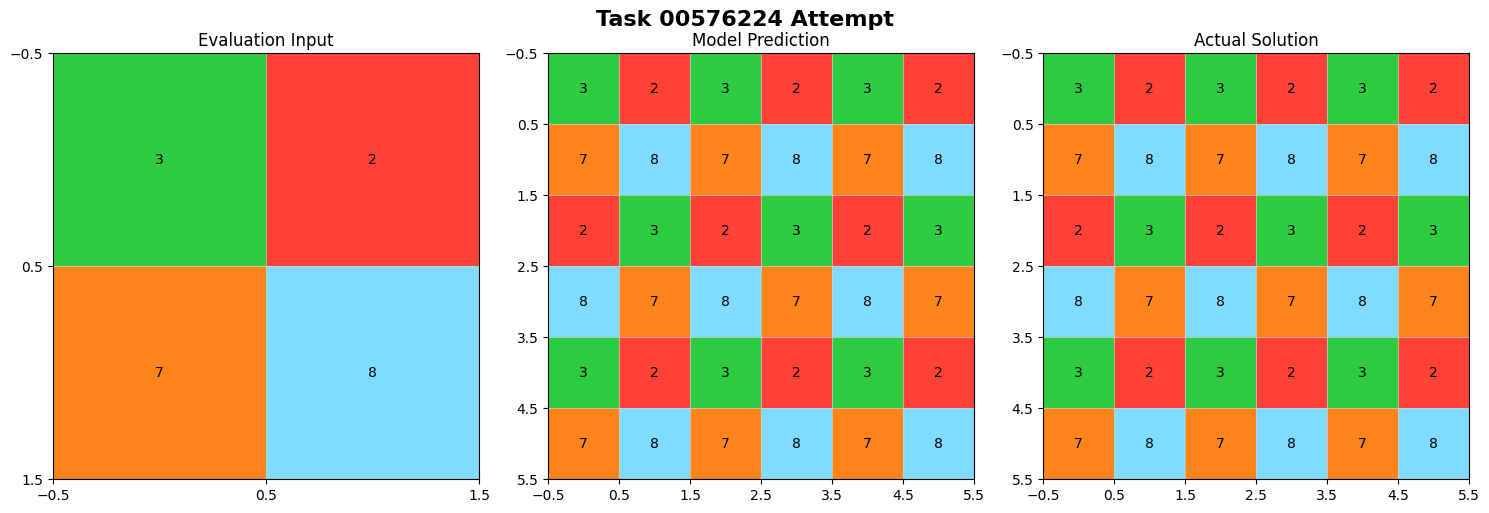


Prediction details for attempt_1, retry 0:
Prediction: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
Expected solution: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
Found correct solution in attempt_1, retry 0
2024-12-08 11:19:08,210 - INFO - Plot flag for task 00576224, attempt 2, retry 0: True
2024-12-08 11:19:08,212 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 6],
[6, 4],]

Example 1: Output
[
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],
[6, 8, 6, 8, 6, 8],
[4, 6, 4, 6, 4, 6],
[8, 6, 8, 6, 8, 6],
[6, 4, 6, 4, 6, 4],]

Example 2: Input
[
[7, 9],
[4, 3],]

Example 2: Output
[
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],
[9, 7, 9, 7, 9, 7],
[3, 4, 3, 4, 3, 4],
[7, 9, 7, 9, 7, 9],
[4, 3, 4, 3, 4, 3],]

Test
[
[3, 2]
[7, 8]]

Your Response: with predicted grid size: 6x6
Debug - Plotting dimensions:
Test input shape:

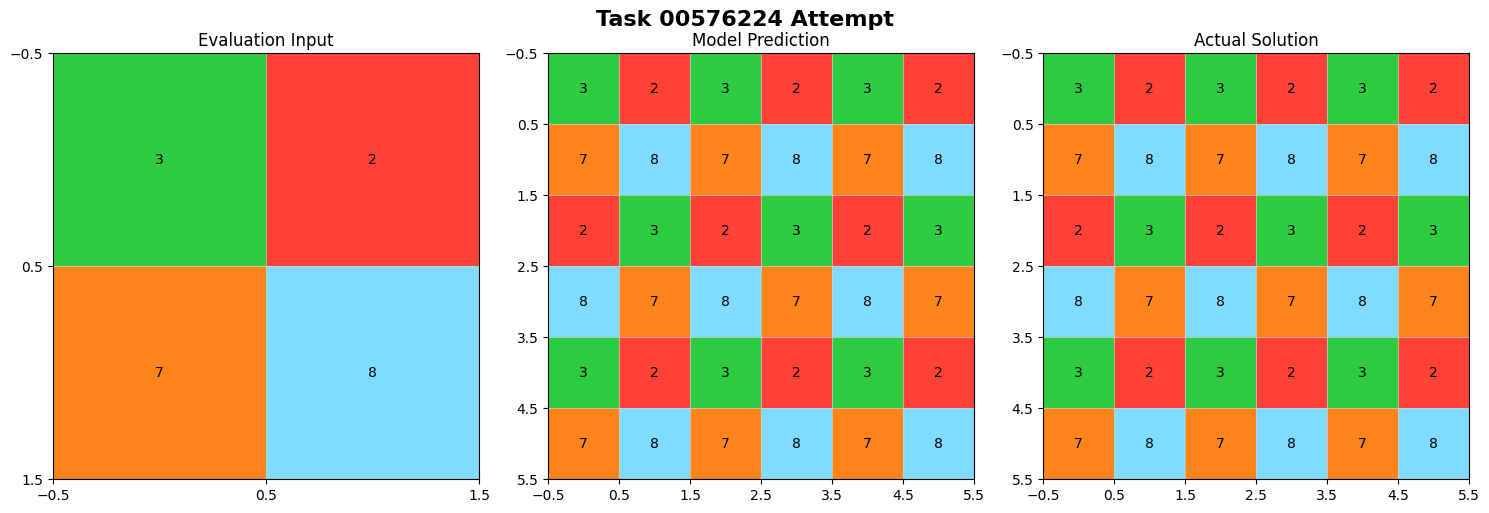


Prediction details for attempt_2, retry 0:
Prediction: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
Expected solution: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
Found correct solution in attempt_2, retry 0
2024-12-08 11:19:28,606 - INFO - Starting task #2 (17cae0c1), pair #1
2024-12-08 11:19:28,607 - INFO - Plot flag for task 17cae0c1, attempt 1, retry 0: True
2024-12-08 11:19:28,609 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[5, 5, 5, 0, 0, 0, 0, 0, 5],
[5, 0, 5, 0, 5, 0, 0, 5, 0],
[5, 5, 5, 0, 0, 0, 5, 0, 0],]

Example 1: Output
[
[3, 3, 3, 4, 4, 4, 9, 9, 9],
[3, 3, 3, 4, 4, 4, 9, 9, 9],
[3, 3, 3, 4, 4, 4, 9, 9, 9],]

Example 2: Input
[
[0, 0, 5, 0, 0, 0, 0, 0, 0],
[0, 5, 0, 0, 0, 0, 0, 5, 0],
[5, 0, 0, 5, 5, 5, 0, 0, 0],]

Example 2: Output
[
[9, 9, 9, 1, 1, 1, 4, 4, 4],
[9, 9, 9, 1, 1, 1, 4, 4, 4],

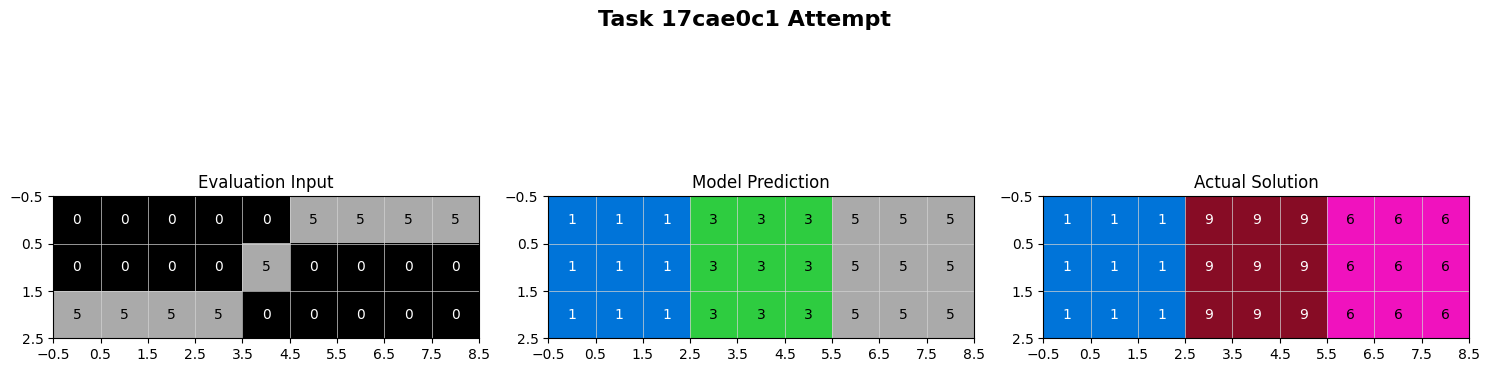


Prediction details for attempt_1, retry 0:
Prediction: [[1, 1, 1, 3, 3, 3, 5, 5, 5], [1, 1, 1, 3, 3, 3, 5, 5, 5], [1, 1, 1, 3, 3, 3, 5, 5, 5]]
Expected solution: [[1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6]]
2024-12-08 11:19:47,923 - INFO - Plot flag for task 17cae0c1, attempt 2, retry 0: True
2024-12-08 11:19:47,925 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[5, 5, 5, 0, 0, 0, 0, 0, 5],
[5, 0, 5, 0, 5, 0, 0, 5, 0],
[5, 5, 5, 0, 0, 0, 5, 0, 0],]

Example 1: Output
[
[3, 3, 3, 4, 4, 4, 9, 9, 9],
[3, 3, 3, 4, 4, 4, 9, 9, 9],
[3, 3, 3, 4, 4, 4, 9, 9, 9],]

Example 2: Input
[
[0, 0, 5, 0, 0, 0, 0, 0, 0],
[0, 5, 0, 0, 0, 0, 0, 5, 0],
[5, 0, 0, 5, 5, 5, 0, 0, 0],]

Example 2: Output
[
[9, 9, 9, 1, 1, 1, 4, 4, 4],
[9, 9, 9, 1, 1, 1, 4, 4, 4],
[9, 9, 9, 1, 1, 1, 4, 4, 4],]

Example 3: Input
[
[5, 5, 5, 5, 5, 5, 0, 0, 0],
[0, 0, 0, 5, 0, 5, 0, 0, 0],
[0, 0, 0, 5, 5, 5, 5, 5, 5],]

Example 3: Output
[
[6, 6, 6, 3, 3, 3, 1,

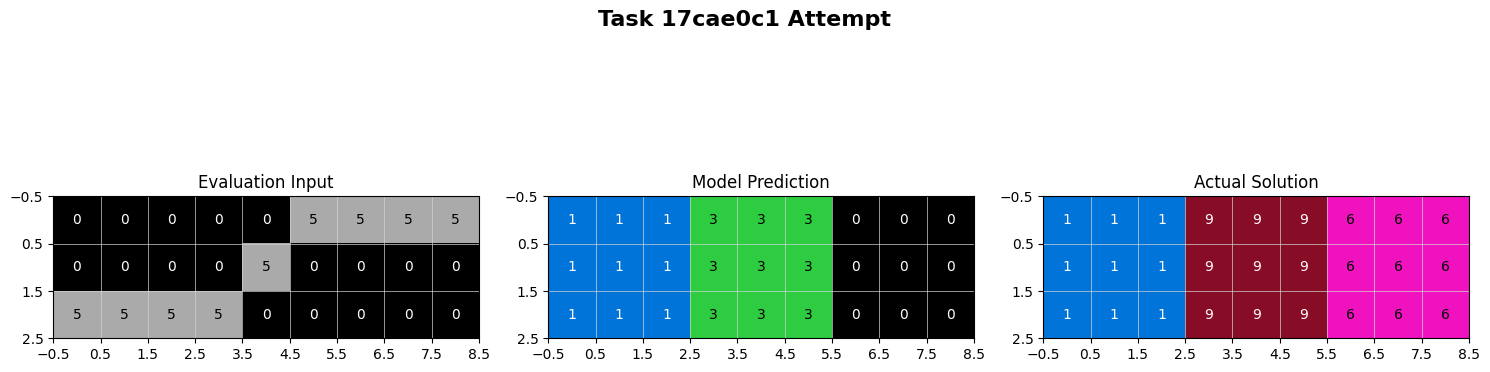


Prediction details for attempt_2, retry 0:
Prediction: [[1, 1, 1, 3, 3, 3, 0, 0, 0], [1, 1, 1, 3, 3, 3, 0, 0, 0], [1, 1, 1, 3, 3, 3, 0, 0, 0]]
Expected solution: [[1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6]]
2024-12-08 11:20:08,311 - INFO - Starting task #3 (2072aba6), pair #1
2024-12-08 11:20:08,312 - INFO - Plot flag for task 2072aba6, attempt 1, retry 0: True
2024-12-08 11:20:08,314 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 5, 0],
[5, 5, 5],
[0, 5, 0],]

Example 1: Output
[
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[1, 2, 1, 2, 1, 2],
[2, 1, 2, 1, 2, 1],
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],]

Example 2: Input
[
[5, 0, 0],
[0, 5, 0],
[0, 0, 5],]

Example 2: Output
[
[1, 2, 0, 0, 0, 0],
[2, 1, 0, 0, 0, 0],
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[0, 0, 0, 0, 1, 2],
[0, 0, 0, 0, 2, 1],]

Example 3: Input
[
[0, 5, 0],
[0, 5, 5],
[5, 5, 0],]

Example 3: Output
[
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[0, 0, 

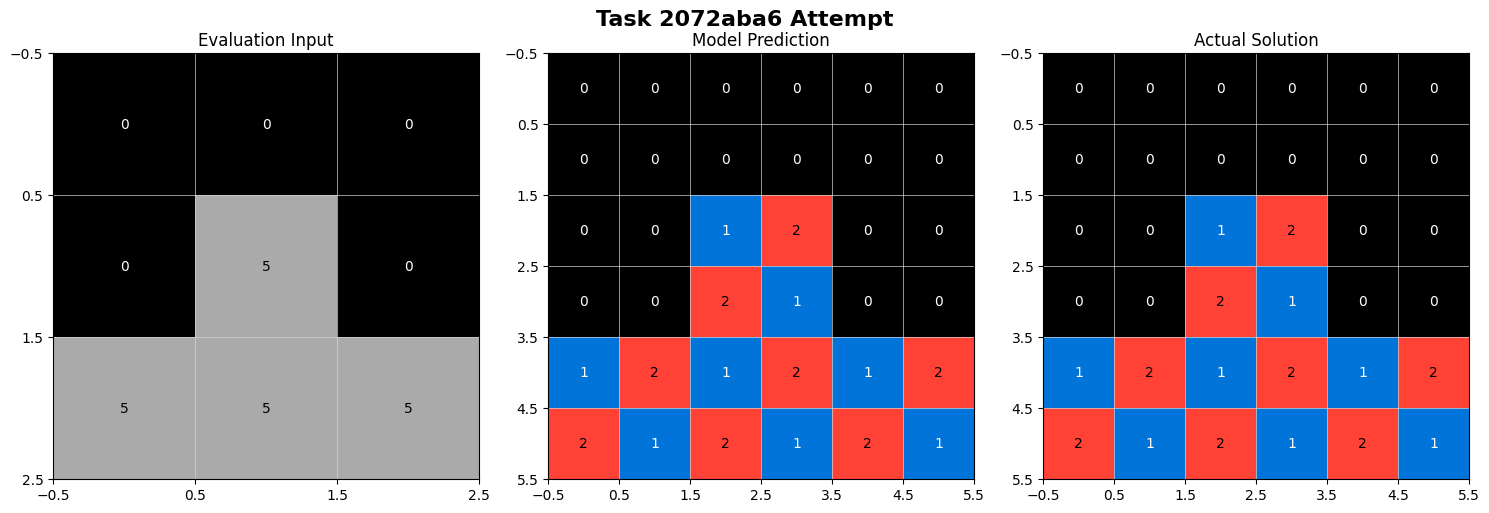


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 1, 2, 0, 0], [0, 0, 2, 1, 0, 0], [1, 2, 1, 2, 1, 2], [2, 1, 2, 1, 2, 1]]
Expected solution: [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 1, 2, 0, 0], [0, 0, 2, 1, 0, 0], [1, 2, 1, 2, 1, 2], [2, 1, 2, 1, 2, 1]]
Found correct solution in attempt_1, retry 0
2024-12-08 11:20:25,898 - INFO - Plot flag for task 2072aba6, attempt 2, retry 0: True
2024-12-08 11:20:25,900 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 5, 0],
[5, 5, 5],
[0, 5, 0],]

Example 1: Output
[
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[1, 2, 1, 2, 1, 2],
[2, 1, 2, 1, 2, 1],
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],]

Example 2: Input
[
[5, 0, 0],
[0, 5, 0],
[0, 0, 5],]

Example 2: Output
[
[1, 2, 0, 0, 0, 0],
[2, 1, 0, 0, 0, 0],
[0, 0, 1, 2, 0, 0],
[0, 0, 2, 1, 0, 0],
[0, 0, 0, 0, 1, 2],
[0, 0, 0, 0, 2, 1],]

Example 3: Input
[
[0, 5, 0],
[0, 5, 5],
[5, 5, 0],]

Example 3: Output
[
[0, 0,

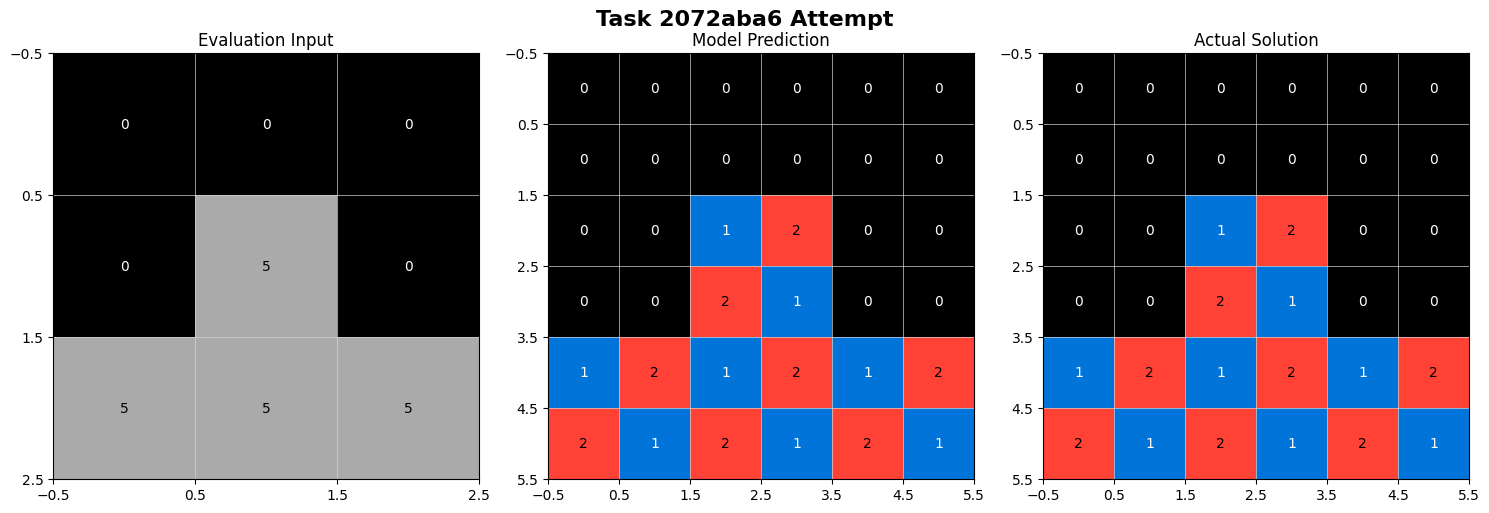


Prediction details for attempt_2, retry 0:
Prediction: [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 1, 2, 0, 0], [0, 0, 2, 1, 0, 0], [1, 2, 1, 2, 1, 2], [2, 1, 2, 1, 2, 1]]
Expected solution: [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 1, 2, 0, 0], [0, 0, 2, 1, 0, 0], [1, 2, 1, 2, 1, 2], [2, 1, 2, 1, 2, 1]]
Found correct solution in attempt_2, retry 0
2024-12-08 11:20:50,340 - INFO - Starting task #4 (27a77e38), pair #1
2024-12-08 11:20:50,341 - INFO - Plot flag for task 27a77e38, attempt 1, retry 0: True
2024-12-08 11:20:50,345 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[2, 2, 3],
[5, 5, 5],
[0, 0, 0],]

Example 1: Output
[
[2, 2, 3],
[5, 5, 5],
[0, 2, 0],]

Example 2: Input
[
[3, 6, 4, 2, 4],
[8, 4, 3, 3, 4],
[5, 5, 5, 5, 5],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],]

Example 2: Output
[
[3, 6, 4, 2, 4],
[8, 4, 3, 3, 4],
[5, 5, 5, 5, 5],
[0, 0, 0, 0, 0],
[0, 0, 4, 0, 0],]

Example 3: Input
[
[1, 9, 9, 6, 1, 8, 4],
[4, 6, 7, 8, 9, 7, 1],
[9, 3, 1, 4, 1,

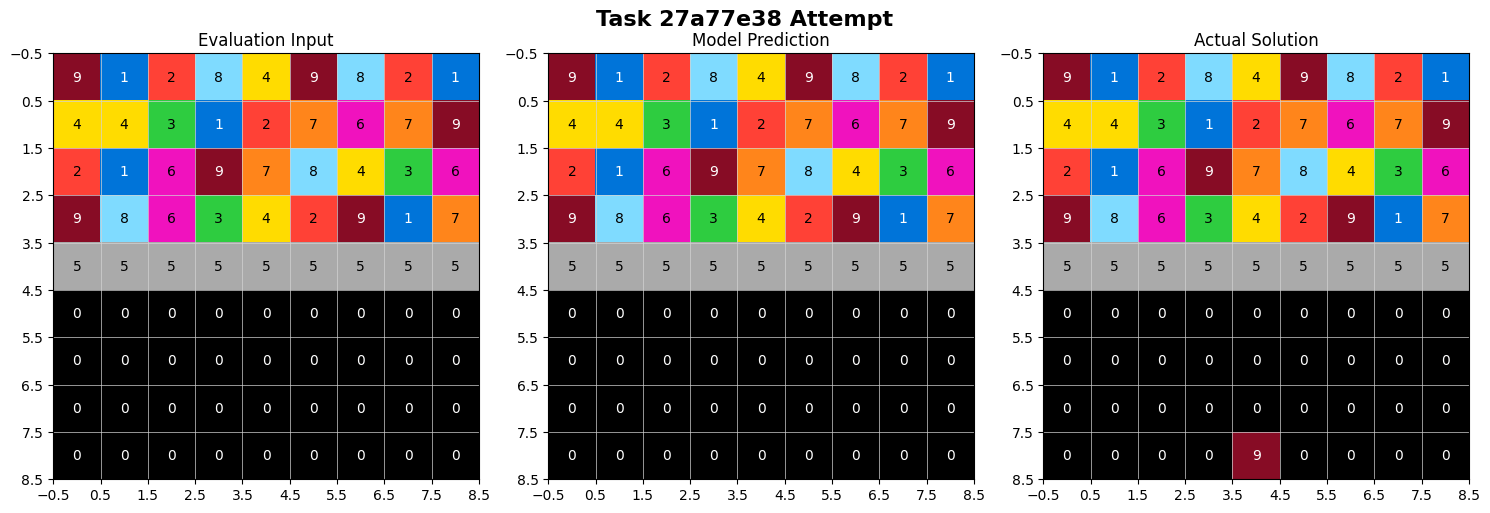


Prediction details for attempt_1, retry 0:
Prediction: [[9, 1, 2, 8, 4, 9, 8, 2, 1], [4, 4, 3, 1, 2, 7, 6, 7, 9], [2, 1, 6, 9, 7, 8, 4, 3, 6], [9, 8, 6, 3, 4, 2, 9, 1, 7], [5, 5, 5, 5, 5, 5, 5, 5, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Expected solution: [[9, 1, 2, 8, 4, 9, 8, 2, 1], [4, 4, 3, 1, 2, 7, 6, 7, 9], [2, 1, 6, 9, 7, 8, 4, 3, 6], [9, 8, 6, 3, 4, 2, 9, 1, 7], [5, 5, 5, 5, 5, 5, 5, 5, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 9, 0, 0, 0, 0]]
2024-12-08 11:21:13,492 - INFO - Plot flag for task 27a77e38, attempt 2, retry 0: True
2024-12-08 11:21:13,494 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[2, 2, 3],
[5, 5, 5],
[0, 0, 0],]

Example 1: Output
[
[2, 2, 3],
[5, 5, 5],
[0, 2, 0],]

Example 2: Input
[
[3, 6, 4, 2, 4],
[8, 4, 3, 3, 4],
[5, 5, 5, 5, 5],
[0, 0, 0, 0, 0],
[0, 0, 0, 0, 0],]

Example 2: Output
[


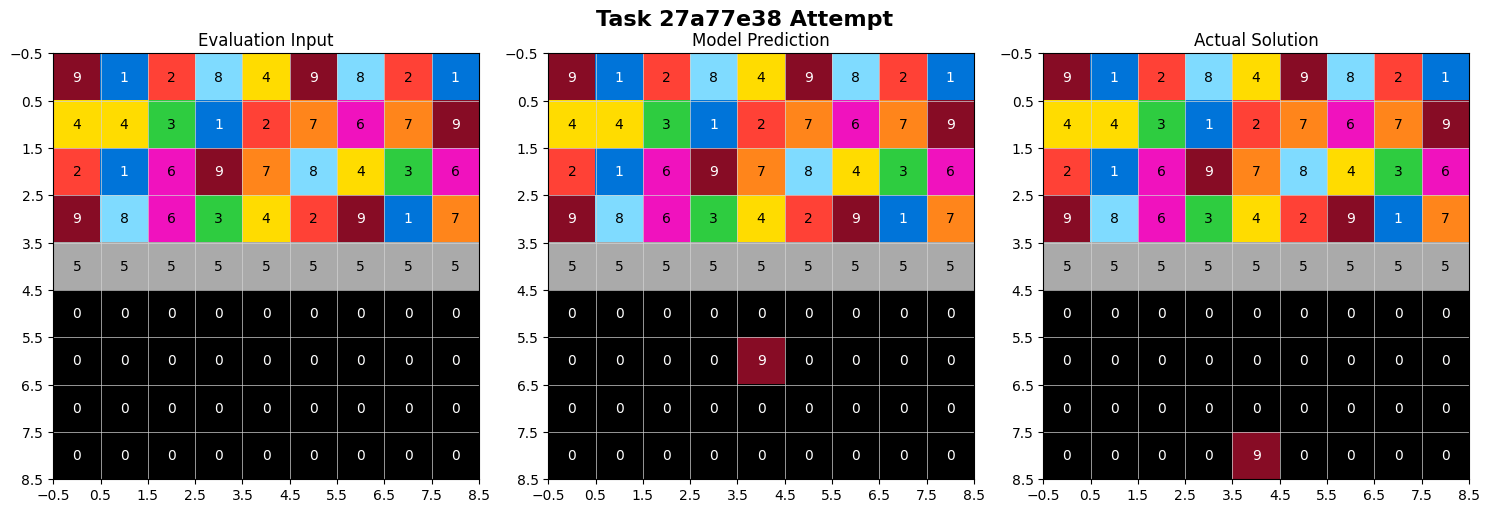


Prediction details for attempt_2, retry 0:
Prediction: [[9, 1, 2, 8, 4, 9, 8, 2, 1], [4, 4, 3, 1, 2, 7, 6, 7, 9], [2, 1, 6, 9, 7, 8, 4, 3, 6], [9, 8, 6, 3, 4, 2, 9, 1, 7], [5, 5, 5, 5, 5, 5, 5, 5, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 9, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
Expected solution: [[9, 1, 2, 8, 4, 9, 8, 2, 1], [4, 4, 3, 1, 2, 7, 6, 7, 9], [2, 1, 6, 9, 7, 8, 4, 3, 6], [9, 8, 6, 3, 4, 2, 9, 1, 7], [5, 5, 5, 5, 5, 5, 5, 5, 5], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 9, 0, 0, 0, 0]]
2024-12-08 11:21:37,458 - INFO - Starting task #5 (31d5ba1a), pair #1
2024-12-08 11:21:37,459 - INFO - Plot flag for task 31d5ba1a, attempt 1, retry 0: True
2024-12-08 11:21:37,461 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 0, 9, 0],
[9, 0, 0, 9, 0],
[0, 9, 9, 9, 9],
[4, 0, 0, 4, 0],
[4, 4, 0, 4, 4],
[4, 4, 4, 0, 4],]

Example 1: Output
[
[0, 6, 0, 0, 0],
[0, 6

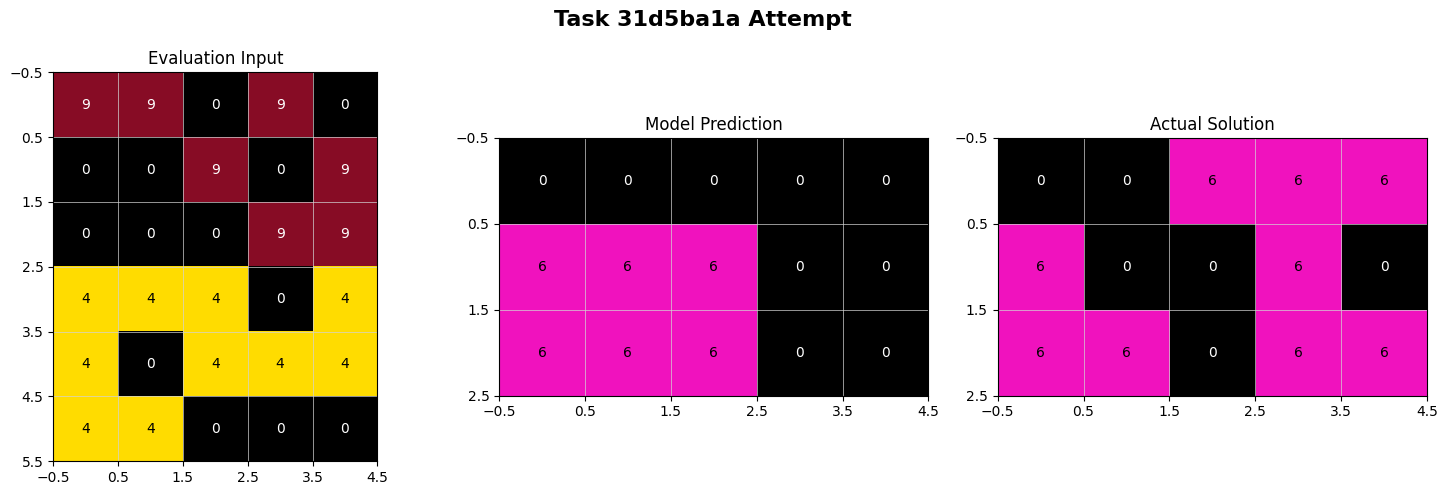


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0, 0, 0, 0], [6, 6, 6, 0, 0], [6, 6, 6, 0, 0]]
Expected solution: [[0, 0, 6, 6, 6], [6, 0, 0, 6, 0], [6, 6, 0, 6, 6]]
2024-12-08 11:21:57,115 - INFO - Plot flag for task 31d5ba1a, attempt 2, retry 0: True
2024-12-08 11:21:57,118 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 0, 9, 0],
[9, 0, 0, 9, 0],
[0, 9, 9, 9, 9],
[4, 0, 0, 4, 0],
[4, 4, 0, 4, 4],
[4, 4, 4, 0, 4],]

Example 1: Output
[
[0, 6, 0, 0, 0],
[0, 6, 0, 0, 6],
[6, 0, 0, 6, 0],]

Example 2: Input
[
[9, 0, 0, 9, 9],
[0, 0, 0, 0, 0],
[0, 0, 9, 0, 9],
[0, 0, 4, 4, 0],
[4, 4, 4, 0, 0],
[4, 0, 4, 0, 4],]

Example 2: Output
[
[6, 0, 6, 0, 6],
[6, 6, 6, 0, 0],
[6, 0, 0, 0, 0],]

Example 3: Input
[
[0, 9, 0, 0, 0],
[0, 9, 9, 0, 9],
[9, 0, 0, 0, 9],
[4, 4, 0, 4, 0],
[0, 4, 4, 4, 0],
[4, 4, 0, 0, 0],]

Example 3: Output
[
[6, 0, 0, 6, 0],
[0, 0, 0, 6, 6],
[0, 6, 0, 0, 6],]

Example 4: Input
[
[0, 0, 9, 9, 0],
[9, 9, 0, 9, 9],
[0, 9, 0, 0, 0

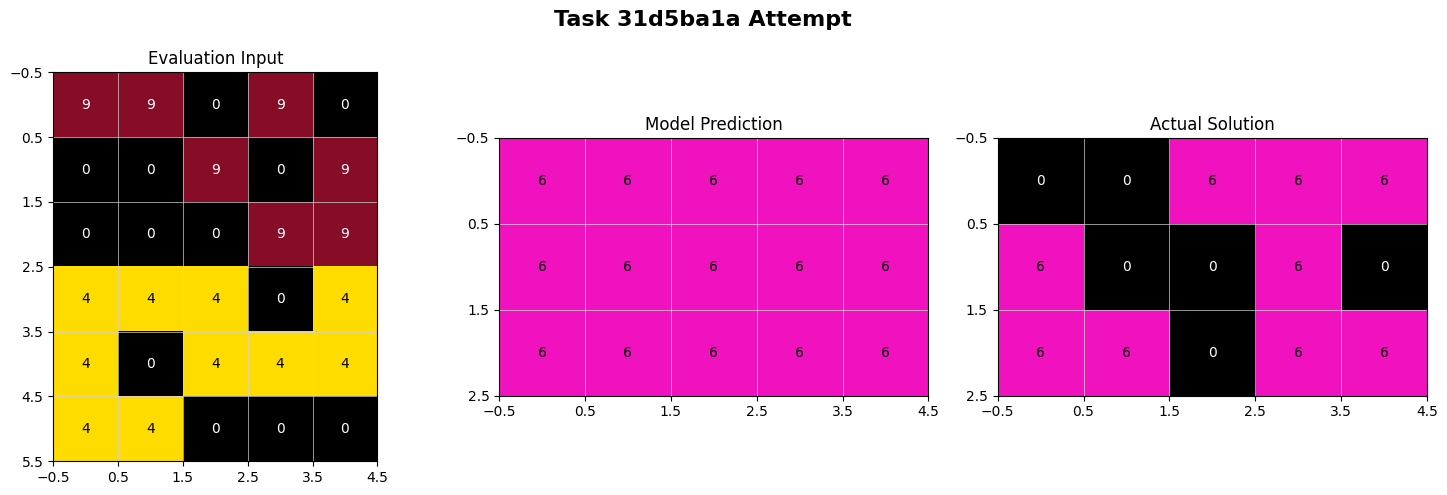


Prediction details for attempt_2, retry 0:
Prediction: [[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], [6, 6, 6, 6, 6]]
Expected solution: [[0, 0, 6, 6, 6], [6, 0, 0, 6, 0], [6, 6, 0, 6, 6]]
2024-12-08 11:22:16,865 - INFO - Starting task #5 (31d5ba1a), pair #2
2024-12-08 11:22:16,868 - INFO - Plot flag for task 31d5ba1a, attempt 1, retry 0: True
2024-12-08 11:22:16,872 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 0, 9, 0],
[9, 0, 0, 9, 0],
[0, 9, 9, 9, 9],
[4, 0, 0, 4, 0],
[4, 4, 0, 4, 4],
[4, 4, 4, 0, 4],]

Example 1: Output
[
[0, 6, 0, 0, 0],
[0, 6, 0, 0, 6],
[6, 0, 0, 6, 0],]

Example 2: Input
[
[9, 0, 0, 9, 9],
[0, 0, 0, 0, 0],
[0, 0, 9, 0, 9],
[0, 0, 4, 4, 0],
[4, 4, 4, 0, 0],
[4, 0, 4, 0, 4],]

Example 2: Output
[
[6, 0, 6, 0, 6],
[6, 6, 6, 0, 0],
[6, 0, 0, 0, 0],]

Example 3: Input
[
[0, 9, 0, 0, 0],
[0, 9, 9, 0, 9],
[9, 0, 0, 0, 9],
[4, 4, 0, 4, 0],
[0, 4, 4, 4, 0],
[4, 4, 0, 0, 0],]

Example 3: Output
[
[6, 0, 0, 6, 0],
[0, 0, 0, 6, 6],
[0, 6, 0, 0, 6],

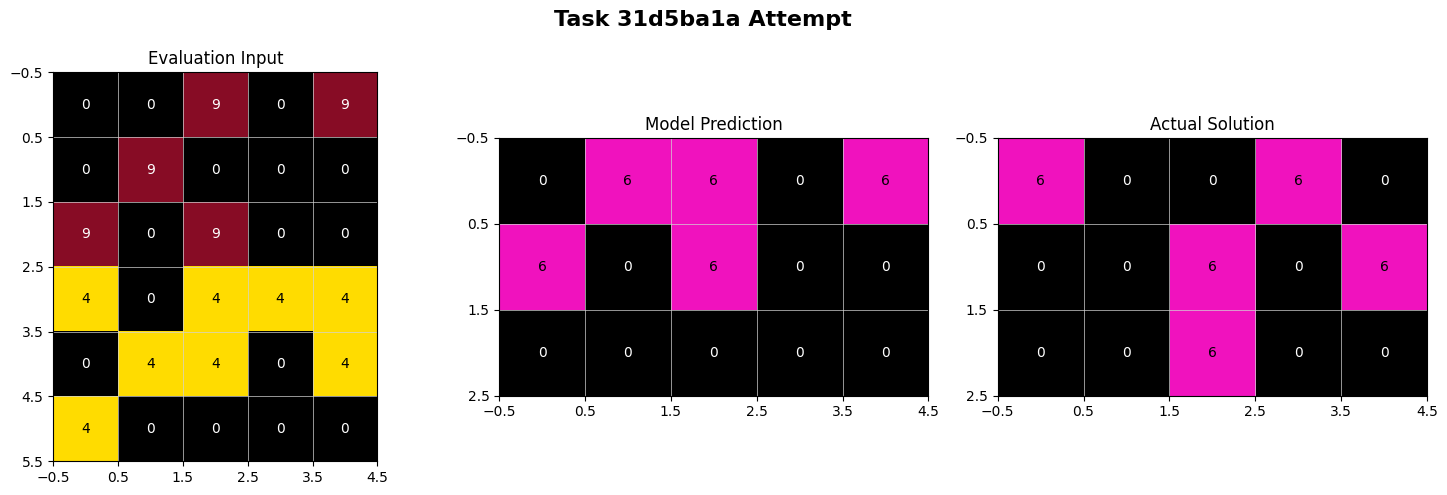


Prediction details for attempt_1, retry 0:
Prediction: [[0, 6, 6, 0, 6], [6, 0, 6, 0, 0], [0, 0, 0, 0, 0]]
Expected solution: [[6, 0, 0, 6, 0], [0, 0, 6, 0, 6], [0, 0, 6, 0, 0]]
2024-12-08 11:22:38,646 - INFO - Plot flag for task 31d5ba1a, attempt 2, retry 0: True
2024-12-08 11:22:38,647 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 0, 9, 0],
[9, 0, 0, 9, 0],
[0, 9, 9, 9, 9],
[4, 0, 0, 4, 0],
[4, 4, 0, 4, 4],
[4, 4, 4, 0, 4],]

Example 1: Output
[
[0, 6, 0, 0, 0],
[0, 6, 0, 0, 6],
[6, 0, 0, 6, 0],]

Example 2: Input
[
[9, 0, 0, 9, 9],
[0, 0, 0, 0, 0],
[0, 0, 9, 0, 9],
[0, 0, 4, 4, 0],
[4, 4, 4, 0, 0],
[4, 0, 4, 0, 4],]

Example 2: Output
[
[6, 0, 6, 0, 6],
[6, 6, 6, 0, 0],
[6, 0, 0, 0, 0],]

Example 3: Input
[
[0, 9, 0, 0, 0],
[0, 9, 9, 0, 9],
[9, 0, 0, 0, 9],
[4, 4, 0, 4, 0],
[0, 4, 4, 4, 0],
[4, 4, 0, 0, 0],]

Example 3: Output
[
[6, 0, 0, 6, 0],
[0, 0, 0, 6, 6],
[0, 6, 0, 0, 6],]

Example 4: Input
[
[0, 0, 9, 9, 0],
[9, 9, 0, 9, 9],
[0, 9, 0, 0, 0

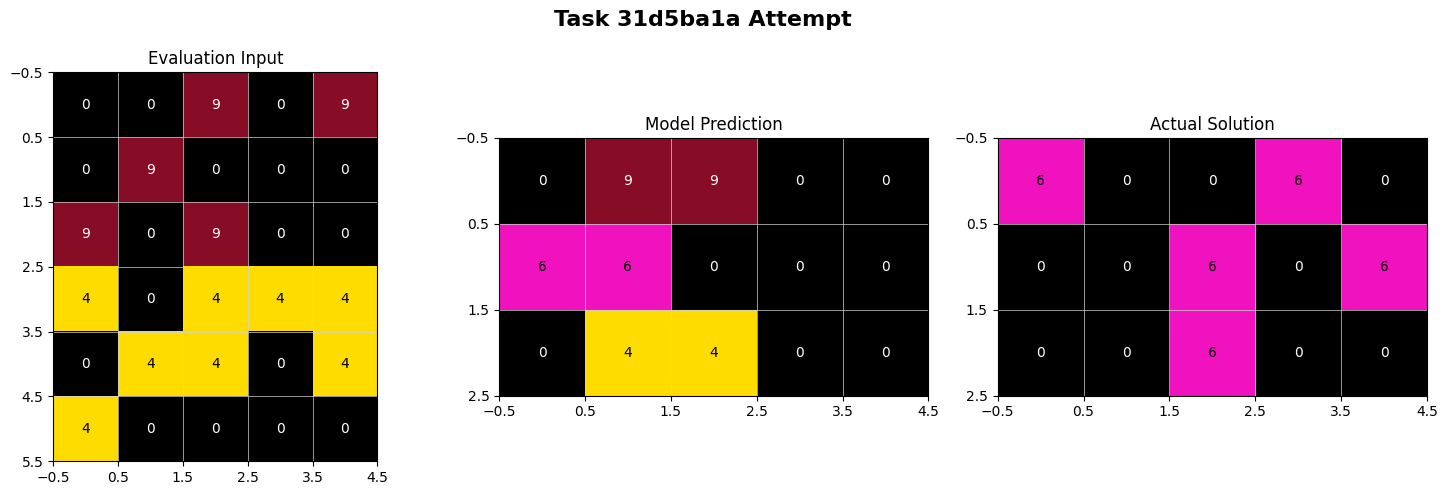


Prediction details for attempt_2, retry 0:
Prediction: [[0, 9, 9, 0, 0], [6, 6, 0, 0, 0], [0, 4, 4, 0, 0]]
Expected solution: [[6, 0, 0, 6, 0], [0, 0, 6, 0, 6], [0, 0, 6, 0, 0]]
2024-12-08 11:23:13,215 - INFO - Starting task #6 (34b99a2b), pair #1
2024-12-08 11:23:13,216 - INFO - Plot flag for task 34b99a2b, attempt 1, retry 0: True
2024-12-08 11:23:13,221 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 8, 0, 0, 4, 0, 5, 5, 0],
[8, 8, 0, 8, 4, 0, 0, 5, 5],
[0, 0, 0, 0, 4, 0, 0, 5, 0],
[8, 8, 0, 0, 4, 0, 5, 5, 5],
[8, 0, 0, 8, 4, 0, 0, 0, 5],]

Example 1: Output
[
[2, 0, 2, 0],
[2, 2, 2, 0],
[0, 0, 2, 0],
[2, 0, 2, 2],
[2, 0, 0, 0],]

Example 2: Input
[
[0, 8, 0, 0, 4, 5, 0, 5, 0],
[0, 8, 0, 8, 4, 5, 0, 5, 5],
[0, 8, 0, 8, 4, 0, 0, 0, 5],
[0, 8, 0, 8, 4, 0, 5, 0, 5],
[0, 0, 0, 8, 4, 0, 0, 5, 0],]

Example 2: Output
[
[2, 2, 2, 0],
[2, 2, 2, 0],
[0, 2, 0, 0],
[0, 0, 0, 0],
[0, 0, 2, 2],]

Example 3: Input
[
[0, 8, 0, 0, 4, 0, 5, 5, 0],
[8, 8, 0, 8, 4, 5, 0,

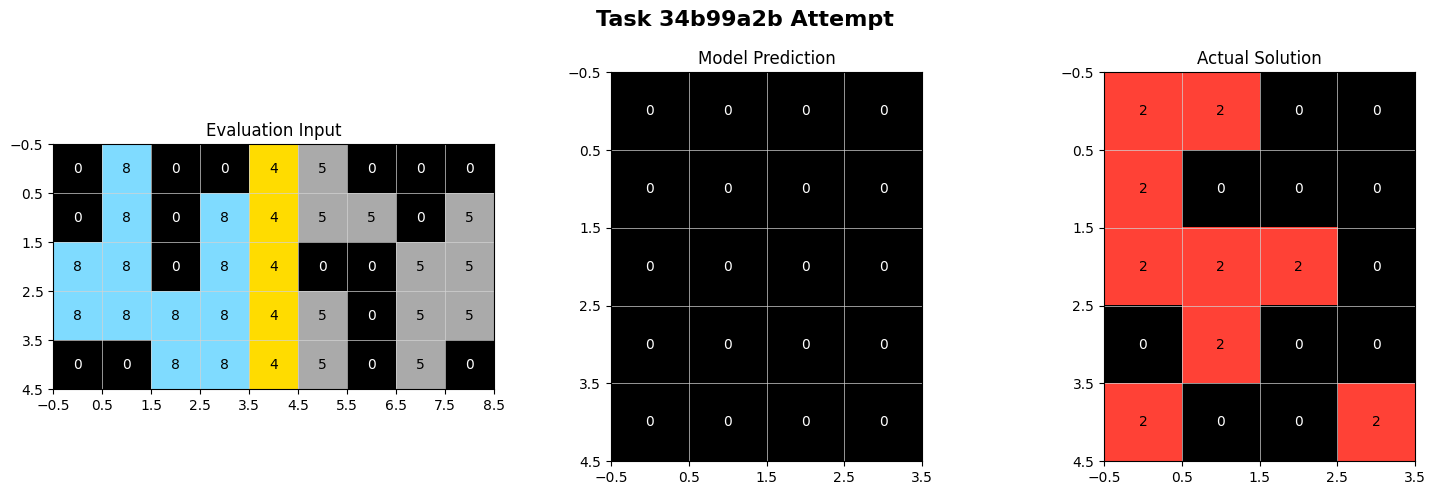


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Expected solution: [[2, 2, 0, 0], [2, 0, 0, 0], [2, 2, 2, 0], [0, 2, 0, 0], [2, 0, 0, 2]]
2024-12-08 11:23:40,128 - INFO - Plot flag for task 34b99a2b, attempt 2, retry 0: True
2024-12-08 11:23:40,130 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 8, 0, 0, 4, 0, 5, 5, 0],
[8, 8, 0, 8, 4, 0, 0, 5, 5],
[0, 0, 0, 0, 4, 0, 0, 5, 0],
[8, 8, 0, 0, 4, 0, 5, 5, 5],
[8, 0, 0, 8, 4, 0, 0, 0, 5],]

Example 1: Output
[
[2, 0, 2, 0],
[2, 2, 2, 0],
[0, 0, 2, 0],
[2, 0, 2, 2],
[2, 0, 0, 0],]

Example 2: Input
[
[0, 8, 0, 0, 4, 5, 0, 5, 0],
[0, 8, 0, 8, 4, 5, 0, 5, 5],
[0, 8, 0, 8, 4, 0, 0, 0, 5],
[0, 8, 0, 8, 4, 0, 5, 0, 5],
[0, 0, 0, 8, 4, 0, 0, 5, 0],]

Example 2: Output
[
[2, 2, 2, 0],
[2, 2, 2, 0],
[0, 2, 0, 0],
[0, 0, 0, 0],
[0, 0, 2, 2],]

Example 3: Input
[
[0, 8, 0, 0, 4, 0, 5, 5, 0],
[8, 8, 0, 8, 4, 5, 0, 0, 5],
[8, 8, 0, 0, 4, 5, 0, 0,

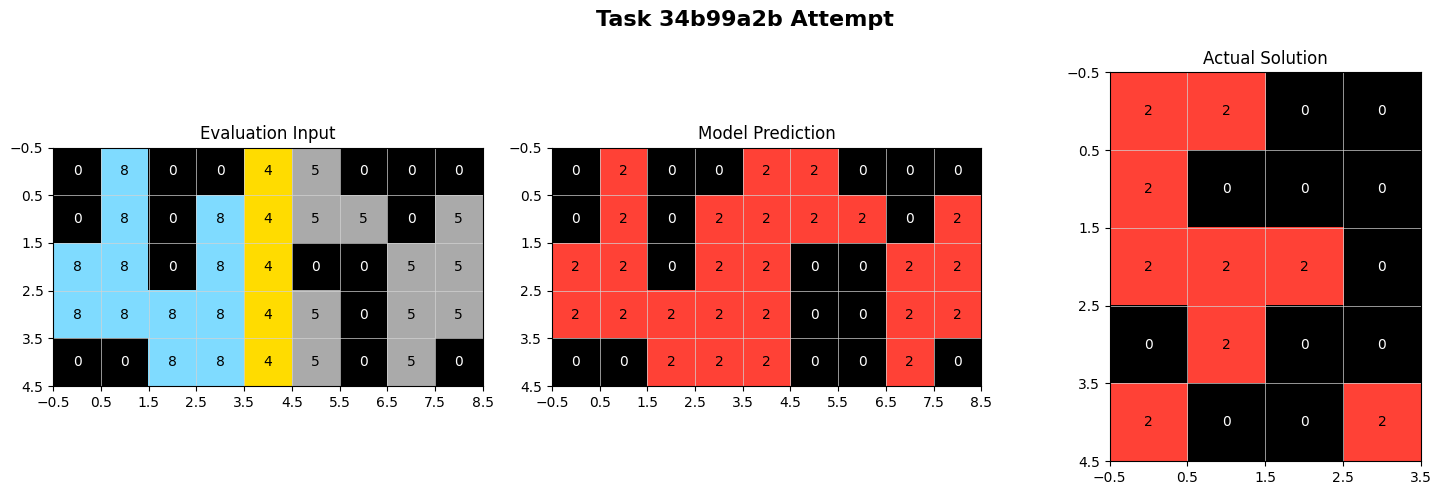


Prediction details for attempt_2, retry 0:
Prediction: [[0, 2, 0, 0, 2, 2, 0, 0, 0], [0, 2, 0, 2, 2, 2, 2, 0, 2], [2, 2, 0, 2, 2, 0, 0, 2, 2], [2, 2, 2, 2, 2, 0, 0, 2, 2], [0, 0, 2, 2, 2, 0, 0, 2, 0]]
Expected solution: [[2, 2, 0, 0], [2, 0, 0, 0], [2, 2, 2, 0], [0, 2, 0, 0], [2, 0, 0, 2]]
2024-12-08 11:24:08,044 - INFO - Starting task #7 (4cd1b7b2), pair #1
2024-12-08 11:24:08,045 - INFO - Plot flag for task 4cd1b7b2, attempt 1, retry 0: True
2024-12-08 11:24:08,047 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[1, 0, 3, 4],
[0, 0, 2, 1],
[2, 1, 4, 0],
[0, 3, 1, 2],]

Example 1: Output
[
[1, 2, 3, 4],
[3, 4, 2, 1],
[2, 1, 4, 3],
[4, 3, 1, 2],]

Example 2: Input
[
[0, 4, 2, 3],
[4, 1, 0, 2],
[0, 3, 4, 0],
[3, 0, 1, 4],]

Example 2: Output
[
[1, 4, 2, 3],
[4, 1, 3, 2],
[2, 3, 4, 1],
[3, 2, 1, 4],]

Example 3: Input
[
[3, 0, 2, 1],
[1, 0, 0, 0],
[4, 3, 0, 2],
[0, 1, 4, 3],]

Example 3: Output
[
[3, 4, 2, 1],
[1, 2, 3, 4],
[4, 3, 1, 2],
[2, 1, 4, 3],]

Test
[


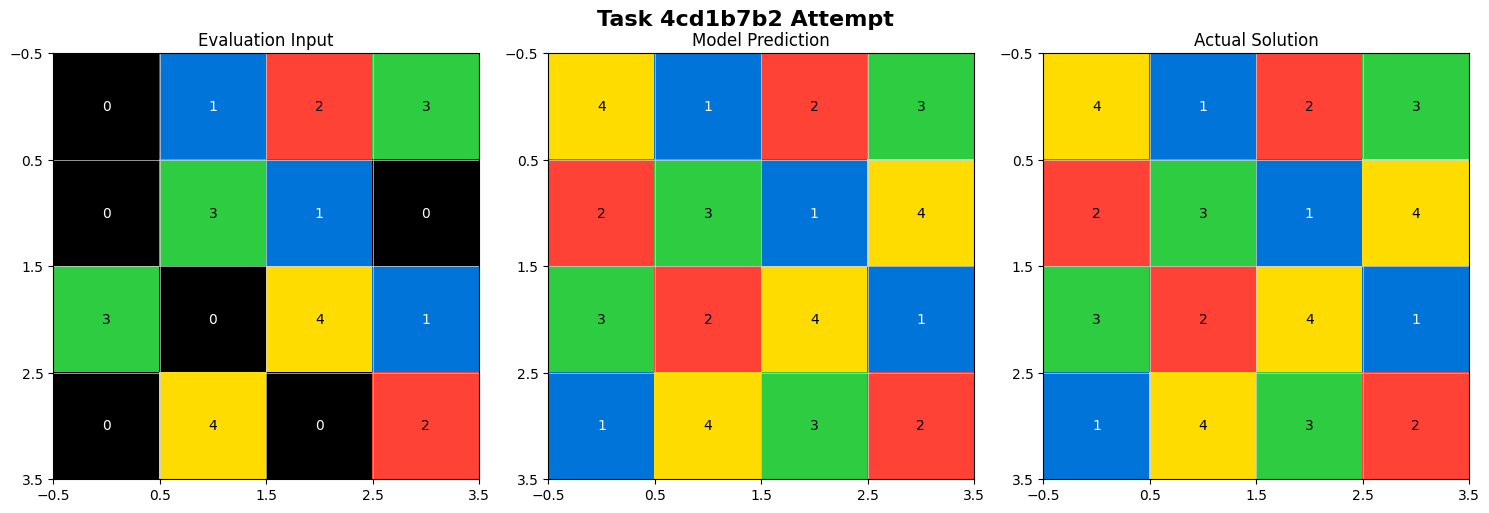


Prediction details for attempt_1, retry 0:
Prediction: [[4, 1, 2, 3], [2, 3, 1, 4], [3, 2, 4, 1], [1, 4, 3, 2]]
Expected solution: [[4, 1, 2, 3], [2, 3, 1, 4], [3, 2, 4, 1], [1, 4, 3, 2]]
Found correct solution in attempt_1, retry 0
2024-12-08 11:24:31,847 - INFO - Plot flag for task 4cd1b7b2, attempt 2, retry 0: True
2024-12-08 11:24:31,849 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[1, 0, 3, 4],
[0, 0, 2, 1],
[2, 1, 4, 0],
[0, 3, 1, 2],]

Example 1: Output
[
[1, 2, 3, 4],
[3, 4, 2, 1],
[2, 1, 4, 3],
[4, 3, 1, 2],]

Example 2: Input
[
[0, 4, 2, 3],
[4, 1, 0, 2],
[0, 3, 4, 0],
[3, 0, 1, 4],]

Example 2: Output
[
[1, 4, 2, 3],
[4, 1, 3, 2],
[2, 3, 4, 1],
[3, 2, 1, 4],]

Example 3: Input
[
[3, 0, 2, 1],
[1, 0, 0, 0],
[4, 3, 0, 2],
[0, 1, 4, 3],]

Example 3: Output
[
[3, 4, 2, 1],
[1, 2, 3, 4],
[4, 3, 1, 2],
[2, 1, 4, 3],]

Test
[
[0, 1, 2, 3]
[0, 3, 1, 0]
[3, 0, 4, 1]
[0, 4, 0, 2]]

Your Response: with predicted grid size: 4x4
Debug - Plotting dimensions:


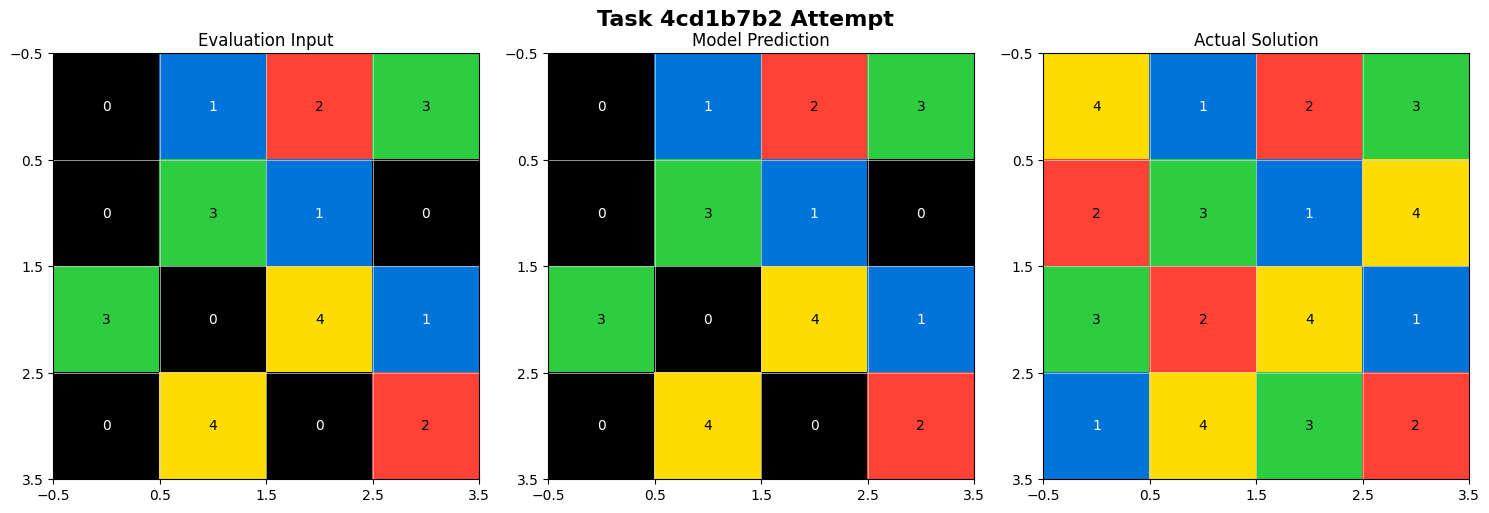


Prediction details for attempt_2, retry 0:
Prediction: [[0, 1, 2, 3], [0, 3, 1, 0], [3, 0, 4, 1], [0, 4, 0, 2]]
Expected solution: [[4, 1, 2, 3], [2, 3, 1, 4], [3, 2, 4, 1], [1, 4, 3, 2]]
2024-12-08 11:24:56,763 - INFO - Starting task #8 (59341089), pair #1
2024-12-08 11:24:56,764 - INFO - Plot flag for task 59341089, attempt 1, retry 0: True
2024-12-08 11:24:56,766 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[7, 5, 7],
[5, 5, 7],
[7, 7, 5],]

Example 1: Output
[
[7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7],
[7, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7],
[5, 7, 7, 7, 7, 5, 5, 7, 7, 7, 7, 5],]

Example 2: Input
[
[7, 7, 8],
[5, 8, 8],
[5, 8, 8],]

Example 2: Output
[
[8, 7, 7, 7, 7, 8, 8, 7, 7, 7, 7, 8],
[8, 8, 5, 5, 8, 8, 8, 8, 5, 5, 8, 8],
[8, 8, 5, 5, 8, 8, 8, 8, 5, 5, 8, 8],]

Example 3: Input
[
[8, 8, 8],
[5, 5, 7],
[5, 7, 8],]

Example 3: Output
[
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
[7, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7],
[8, 7, 5, 5, 7, 8, 8, 7, 5, 5, 7, 8],]

Examp

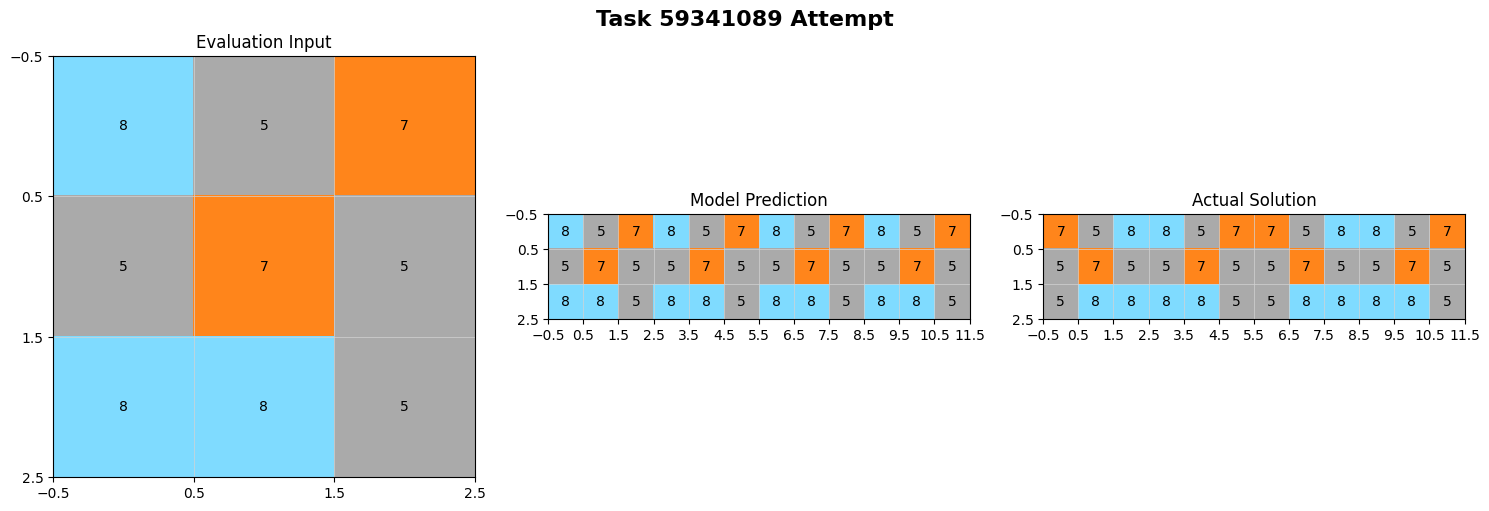


Prediction details for attempt_1, retry 0:
Prediction: [[8, 5, 7, 8, 5, 7, 8, 5, 7, 8, 5, 7], [5, 7, 5, 5, 7, 5, 5, 7, 5, 5, 7, 5], [8, 8, 5, 8, 8, 5, 8, 8, 5, 8, 8, 5]]
Expected solution: [[7, 5, 8, 8, 5, 7, 7, 5, 8, 8, 5, 7], [5, 7, 5, 5, 7, 5, 5, 7, 5, 5, 7, 5], [5, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 5]]
2024-12-08 11:25:18,993 - INFO - Plot flag for task 59341089, attempt 2, retry 0: True
2024-12-08 11:25:18,995 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[7, 5, 7],
[5, 5, 7],
[7, 7, 5],]

Example 1: Output
[
[7, 5, 7, 7, 5, 7, 7, 5, 7, 7, 5, 7],
[7, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7],
[5, 7, 7, 7, 7, 5, 5, 7, 7, 7, 7, 5],]

Example 2: Input
[
[7, 7, 8],
[5, 8, 8],
[5, 8, 8],]

Example 2: Output
[
[8, 7, 7, 7, 7, 8, 8, 7, 7, 7, 7, 8],
[8, 8, 5, 5, 8, 8, 8, 8, 5, 5, 8, 8],
[8, 8, 5, 5, 8, 8, 8, 8, 5, 5, 8, 8],]

Example 3: Input
[
[8, 8, 8],
[5, 5, 7],
[5, 7, 8],]

Example 3: Output
[
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
[7, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 7],

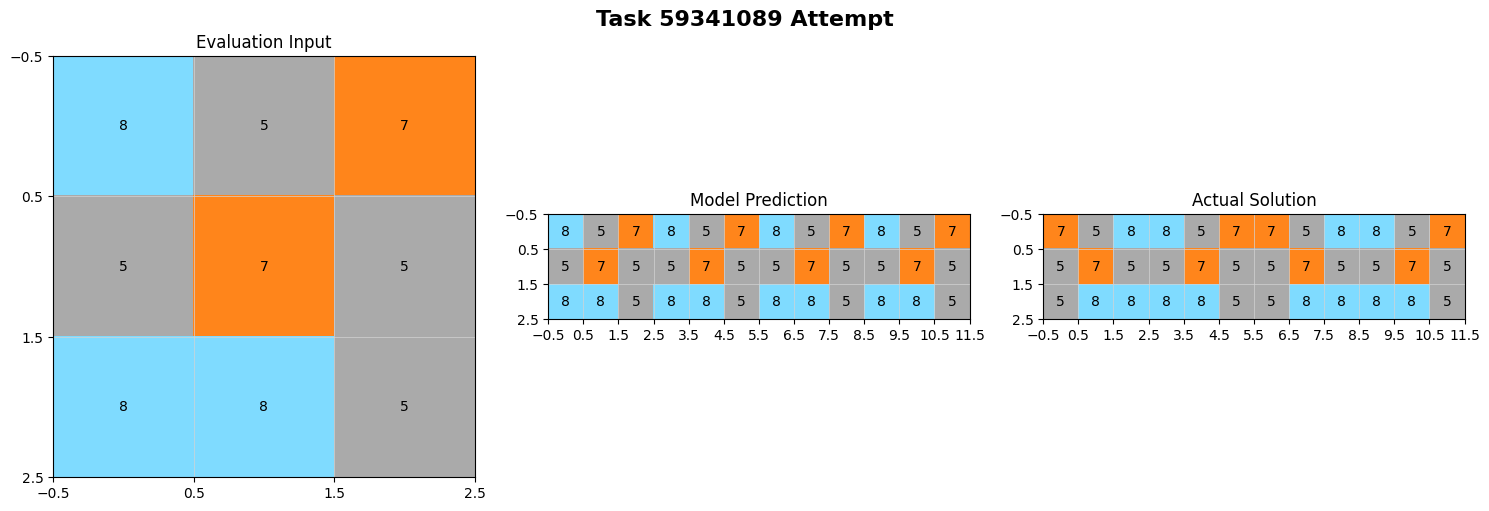


Prediction details for attempt_2, retry 0:
Prediction: [[8, 5, 7, 8, 5, 7, 8, 5, 7, 8, 5, 7], [5, 7, 5, 5, 7, 5, 5, 7, 5, 5, 7, 5], [8, 8, 5, 8, 8, 5, 8, 8, 5, 8, 8, 5]]
Expected solution: [[7, 5, 8, 8, 5, 7, 7, 5, 8, 8, 5, 7], [5, 7, 5, 5, 7, 5, 5, 7, 5, 5, 7, 5], [5, 8, 8, 8, 8, 5, 5, 8, 8, 8, 8, 5]]
2024-12-08 11:25:38,476 - INFO - Starting task #9 (62b74c02), pair #1
2024-12-08 11:25:38,477 - INFO - Plot flag for task 62b74c02, attempt 1, retry 0: True
2024-12-08 11:25:38,479 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 2, 8, 0, 0, 0, 0, 0, 0, 0],
[1, 8, 1, 0, 0, 0, 0, 0, 0, 0],
[1, 8, 1, 0, 0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[8, 2, 8, 8, 8, 8, 8, 8, 2, 8],
[1, 8, 1, 1, 1, 1, 1, 1, 8, 1],
[1, 8, 1, 1, 1, 1, 1, 1, 8, 1],]

Example 2: Input
[
[3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 

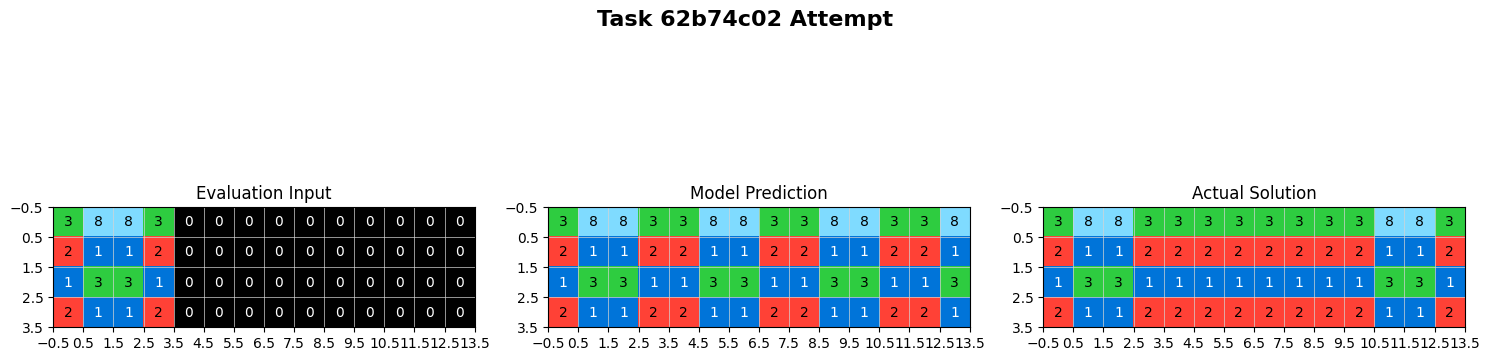


Prediction details for attempt_1, retry 0:
Prediction: [[3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8], [2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1], [1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3], [2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1]]
Expected solution: [[3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3], [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2], [1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1], [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2]]
2024-12-08 11:26:04,075 - INFO - Plot flag for task 62b74c02, attempt 2, retry 0: True
2024-12-08 11:26:04,077 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 2, 8, 0, 0, 0, 0, 0, 0, 0],
[1, 8, 1, 0, 0, 0, 0, 0, 0, 0],
[1, 8, 1, 0, 0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[8, 2, 8, 8, 8, 8, 8, 8, 2, 8],
[1, 8, 1, 1, 1, 1, 1, 1, 8, 1],
[1, 8, 1, 1, 1, 1, 1, 1, 8, 1],]

Example 2: Input
[
[3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],

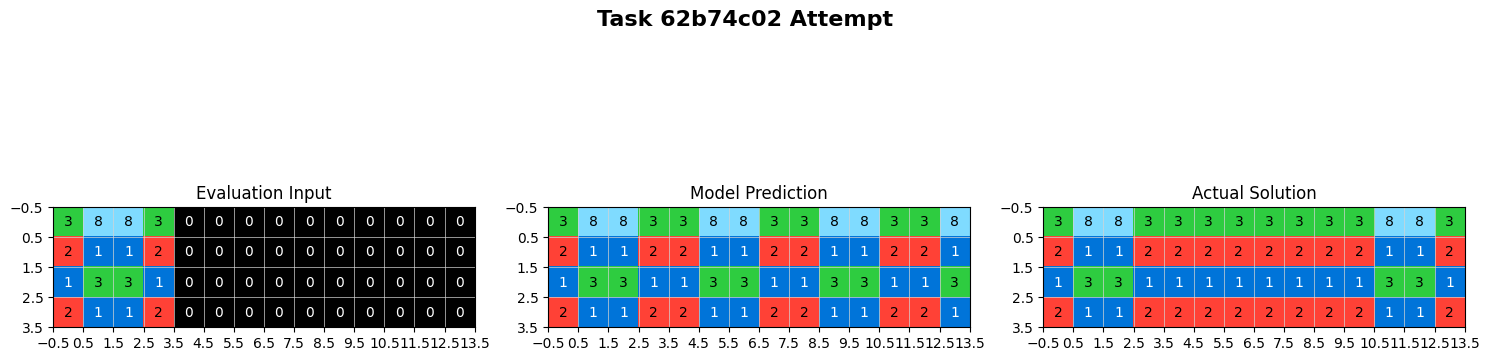


Prediction details for attempt_2, retry 0:
Prediction: [[3, 8, 8, 3, 3, 8, 8, 3, 3, 8, 8, 3, 3, 8], [2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1], [1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3], [2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1]]
Expected solution: [[3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 3], [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2], [1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1], [2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2]]
2024-12-08 11:26:26,453 - INFO - Starting task #10 (66e6c45b), pair #1
2024-12-08 11:26:26,454 - INFO - Plot flag for task 66e6c45b, attempt 1, retry 0: True
2024-12-08 11:26:26,457 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 0],
[0, 3, 4, 0],
[0, 7, 6, 0],
[0, 0, 0, 0],]

Example 1: Output
[
[3, 0, 0, 4],
[0, 0, 0, 0],
[0, 0, 0, 0],
[7, 0, 0, 6],]

Example 2: Input
[
[0, 0, 0, 0],
[0, 5, 6, 0],
[0, 8, 3, 0],
[0, 0, 0, 0],]

Example 2: Output
[
[5, 0, 0, 6],
[0, 0, 0, 0],
[0, 0, 0, 0],
[8, 0, 0, 3],]

Test
[
[0, 0, 0, 0]
[0, 

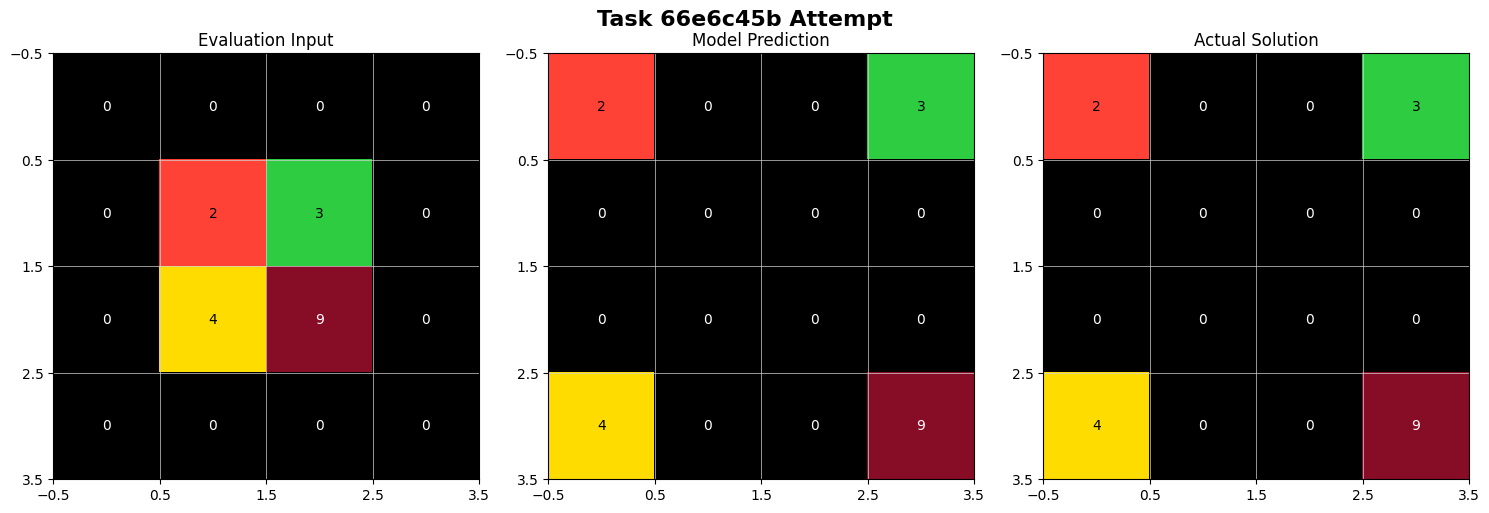


Prediction details for attempt_1, retry 0:
Prediction: [[2, 0, 0, 3], [0, 0, 0, 0], [0, 0, 0, 0], [4, 0, 0, 9]]
Expected solution: [[2, 0, 0, 3], [0, 0, 0, 0], [0, 0, 0, 0], [4, 0, 0, 9]]
Found correct solution in attempt_1, retry 0
2024-12-08 11:26:50,092 - INFO - Plot flag for task 66e6c45b, attempt 2, retry 0: True
2024-12-08 11:26:50,095 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 0],
[0, 3, 4, 0],
[0, 7, 6, 0],
[0, 0, 0, 0],]

Example 1: Output
[
[3, 0, 0, 4],
[0, 0, 0, 0],
[0, 0, 0, 0],
[7, 0, 0, 6],]

Example 2: Input
[
[0, 0, 0, 0],
[0, 5, 6, 0],
[0, 8, 3, 0],
[0, 0, 0, 0],]

Example 2: Output
[
[5, 0, 0, 6],
[0, 0, 0, 0],
[0, 0, 0, 0],
[8, 0, 0, 3],]

Test
[
[0, 0, 0, 0]
[0, 2, 3, 0]
[0, 4, 9, 0]
[0, 0, 0, 0]]

Your Response: with predicted grid size: 4x4
Debug - Plotting dimensions:
Test input shape: (4, 4)
Predicted solution shape: (4, 4)
Actual solution shape: (4, 4)
2024-12-08 11:27:12,939 - INFO - Plotting results for task 66e6c45b

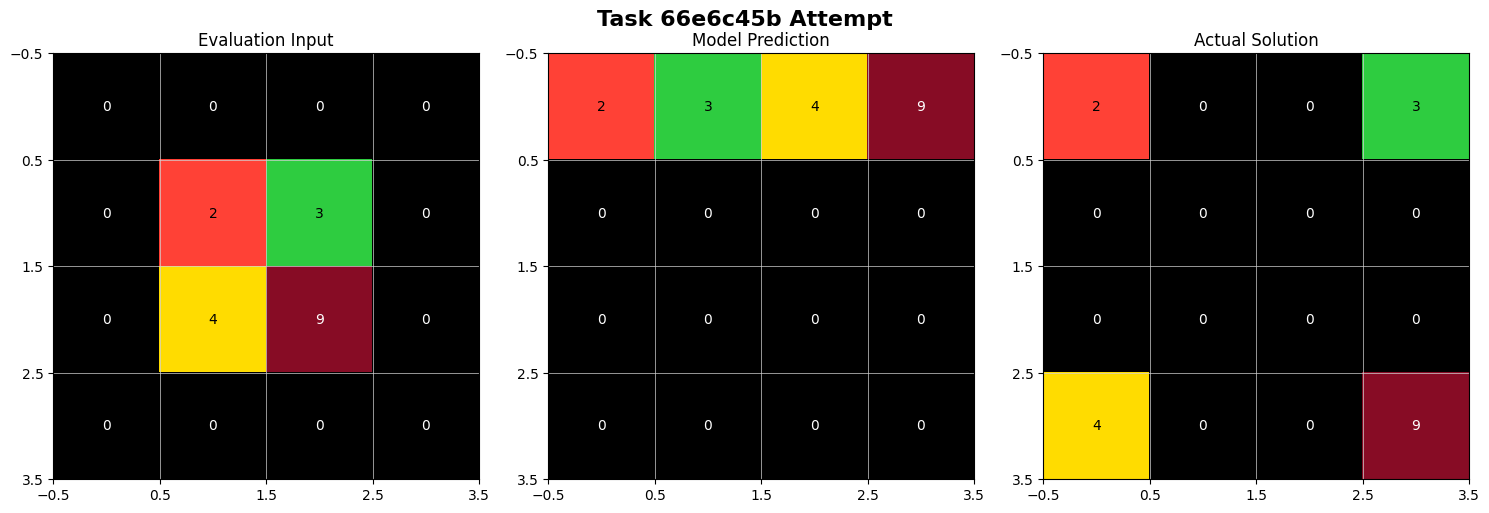


Prediction details for attempt_2, retry 0:
Prediction: [[2, 3, 4, 9], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Expected solution: [[2, 0, 0, 3], [0, 0, 0, 0], [0, 0, 0, 0], [4, 0, 0, 9]]
2024-12-08 11:27:13,474 - INFO - Starting task #11 (66f2d22f), pair #1
2024-12-08 11:27:13,475 - INFO - Plot flag for task 66f2d22f, attempt 1, retry 0: True
2024-12-08 11:27:13,477 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 3, 3, 3, 3, 3, 2, 2, 2, 0, 0, 0, 0],
[3, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0],
[3, 0, 0, 3, 3, 0, 0, 0, 0, 2, 2, 2, 2, 0],
[0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2, 0, 2],]

Example 1: Output
[
[0, 0, 0, 0, 0, 0, 0],
[0, 5, 5, 5, 5, 0, 5],
[0, 5, 0, 0, 0, 0, 5],
[5, 5, 5, 0, 0, 0, 0],]

Example 2: Input
[
[3, 3, 3, 0, 0, 3, 0, 2, 0, 0, 0, 2, 2, 2],
[0, 3, 3, 3, 3, 0, 3, 2, 0, 0, 0, 0, 0, 2],
[0, 0, 3, 0, 3, 3, 3, 0, 0, 2, 2, 0, 2, 2],
[0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2],]

Example 2: Output
[
[0, 0, 0, 5, 0, 0, 0],
[0, 0, 0, 0, 0, 5, 0],


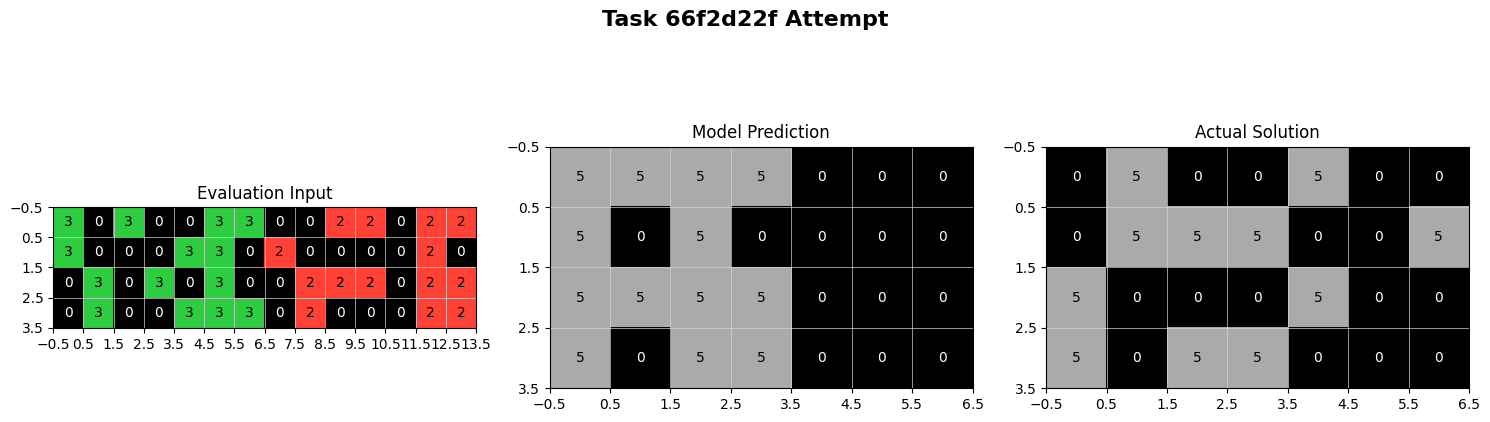


Prediction details for attempt_1, retry 0:
Prediction: [[5, 5, 5, 5, 0, 0, 0], [5, 0, 5, 0, 0, 0, 0], [5, 5, 5, 5, 0, 0, 0], [5, 0, 5, 5, 0, 0, 0]]
Expected solution: [[0, 5, 0, 0, 5, 0, 0], [0, 5, 5, 5, 0, 0, 5], [5, 0, 0, 0, 5, 0, 0], [5, 0, 5, 5, 0, 0, 0]]
2024-12-08 11:27:40,982 - INFO - Plot flag for task 66f2d22f, attempt 2, retry 0: True
2024-12-08 11:27:40,986 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 3, 3, 3, 3, 3, 2, 2, 2, 0, 0, 0, 0],
[3, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0],
[3, 0, 0, 3, 3, 0, 0, 0, 0, 2, 2, 2, 2, 0],
[0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 2, 0, 2],]

Example 1: Output
[
[0, 0, 0, 0, 0, 0, 0],
[0, 5, 5, 5, 5, 0, 5],
[0, 5, 0, 0, 0, 0, 5],
[5, 5, 5, 0, 0, 0, 0],]

Example 2: Input
[
[3, 3, 3, 0, 0, 3, 0, 2, 0, 0, 0, 2, 2, 2],
[0, 3, 3, 3, 3, 0, 3, 2, 0, 0, 0, 0, 0, 2],
[0, 0, 3, 0, 3, 3, 3, 0, 0, 2, 2, 0, 2, 2],
[0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2],]

Example 2: Output
[
[0, 0, 0, 5, 0, 0, 0],
[0, 0, 0, 0, 0, 5, 0],

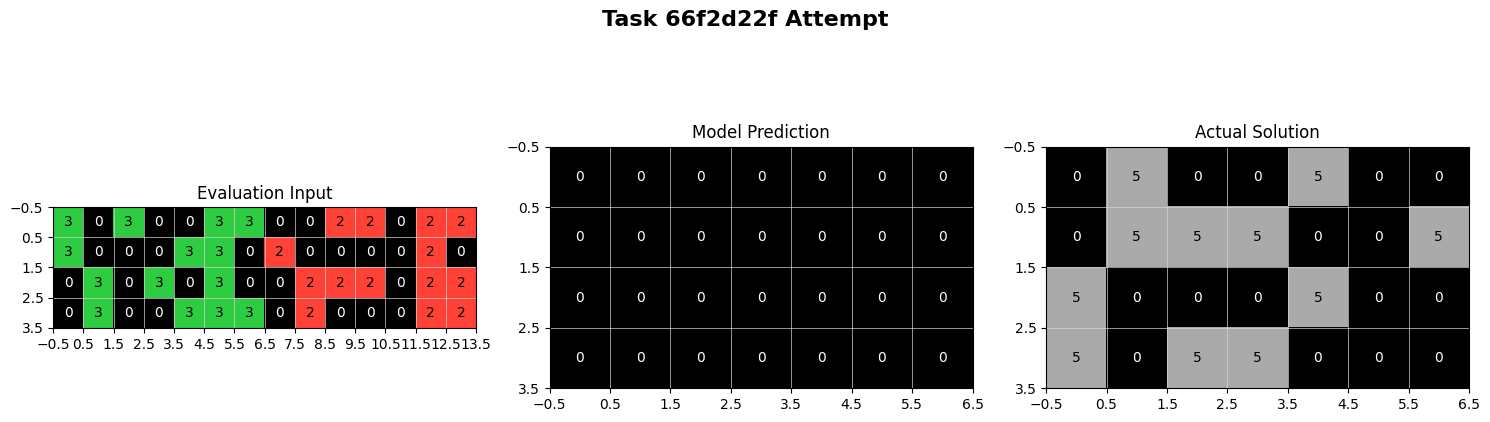


Prediction details for attempt_2, retry 0:
Prediction: [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]
Expected solution: [[0, 5, 0, 0, 5, 0, 0], [0, 5, 5, 5, 0, 0, 5], [5, 0, 0, 0, 5, 0, 0], [5, 0, 5, 5, 0, 0, 0]]
2024-12-08 11:28:02,570 - INFO - Starting task #12 (68b67ca3), pair #1
2024-12-08 11:28:02,572 - INFO - Plot flag for task 68b67ca3, attempt 1, retry 0: True
2024-12-08 11:28:02,574 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[2, 0, 2, 0, 1, 0],
[0, 0, 0, 0, 0, 0],
[2, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[3, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[2, 2, 1],
[2, 1, 0],
[3, 0, 0],]

Example 2: Input
[
[3, 0, 0, 0, 2, 0],
[0, 0, 0, 0, 0, 0],
[8, 0, 0, 0, 8, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[3, 0, 2],
[8, 0, 8],
[0, 1, 0],]

Example 3: Input
[
[1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 2, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[6, 0, 0, 0

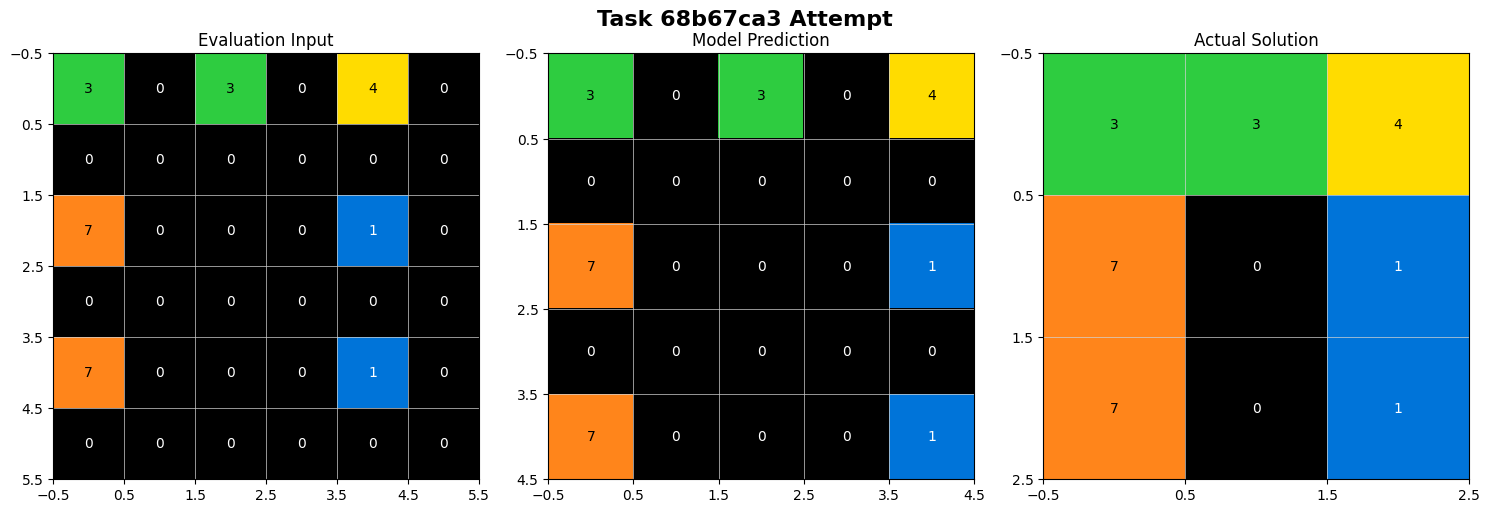


Prediction details for attempt_1, retry 0:
Prediction: [[3, 0, 3, 0, 4], [0, 0, 0, 0, 0], [7, 0, 0, 0, 1], [0, 0, 0, 0, 0], [7, 0, 0, 0, 1]]
Expected solution: [[3, 3, 4], [7, 0, 1], [7, 0, 1]]
2024-12-08 11:28:26,423 - INFO - Plot flag for task 68b67ca3, attempt 2, retry 0: True
2024-12-08 11:28:26,426 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[2, 0, 2, 0, 1, 0],
[0, 0, 0, 0, 0, 0],
[2, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[3, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[2, 2, 1],
[2, 1, 0],
[3, 0, 0],]

Example 2: Input
[
[3, 0, 0, 0, 2, 0],
[0, 0, 0, 0, 0, 0],
[8, 0, 0, 0, 8, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[3, 0, 2],
[8, 0, 8],
[0, 1, 0],]

Example 3: Input
[
[1, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 2, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[6, 0, 0, 0, 6, 0],
[0, 0, 0, 0, 0, 0],]

Example 3: Output
[
[1, 0, 0],
[0, 2, 0],
[6, 0, 6],]

Test
[
[3, 0, 3, 0, 4, 0]
[0, 0, 0, 0, 0, 0]
[7, 0,

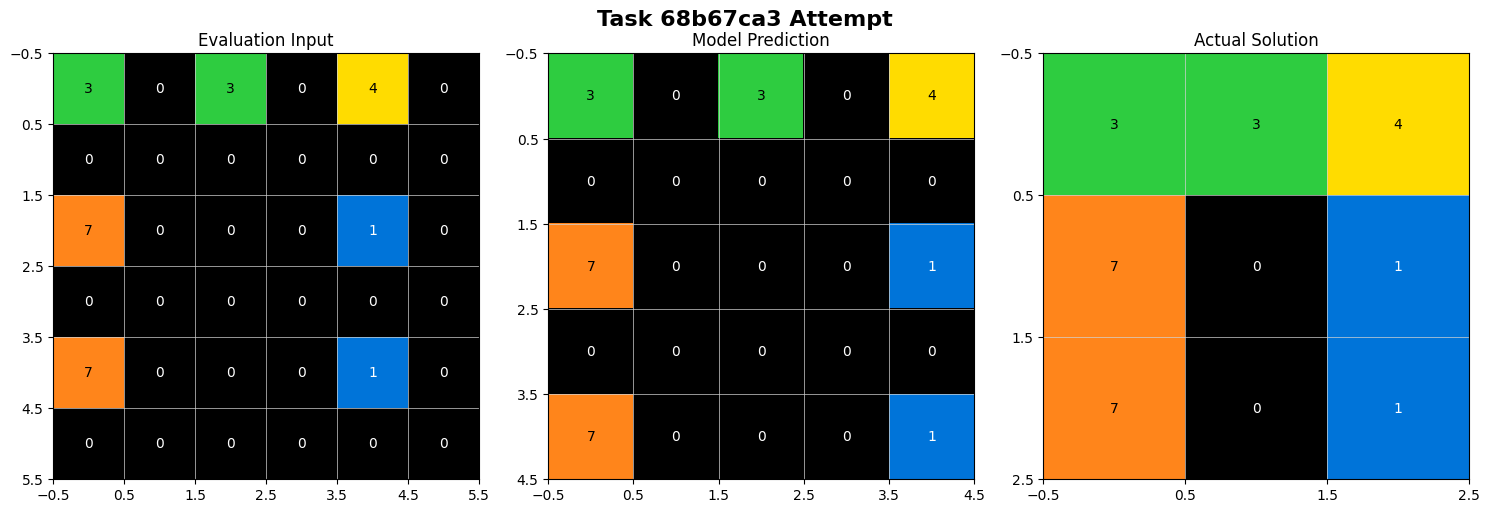


Prediction details for attempt_2, retry 0:
Prediction: [[3, 0, 3, 0, 4], [0, 0, 0, 0, 0], [7, 0, 0, 0, 1], [0, 0, 0, 0, 0], [7, 0, 0, 0, 1]]
Expected solution: [[3, 3, 4], [7, 0, 1], [7, 0, 1]]
2024-12-08 11:28:41,885 - INFO - Starting task #13 (6ea4a07e), pair #1
2024-12-08 11:28:41,886 - INFO - Plot flag for task 6ea4a07e, attempt 1, retry 0: True
2024-12-08 11:28:41,888 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 0, 0],
[0, 8, 0],
[0, 0, 0],]

Example 1: Output
[
[0, 2, 2],
[2, 0, 2],
[2, 2, 2],]

Example 2: Input
[
[0, 0, 3],
[0, 3, 0],
[3, 0, 0],]

Example 2: Output
[
[1, 1, 0],
[1, 0, 1],
[0, 1, 1],]

Example 3: Input
[
[5, 0, 0],
[5, 5, 0],
[5, 0, 0],]

Example 3: Output
[
[0, 4, 4],
[0, 0, 4],
[0, 4, 4],]

Example 4: Input
[
[5, 5, 5],
[0, 0, 5],
[0, 0, 0],]

Example 4: Output
[
[0, 0, 0],
[4, 4, 0],
[4, 4, 4],]

Example 5: Input
[
[0, 8, 0],
[0, 8, 0],
[8, 0, 0],]

Example 5: Output
[
[2, 0, 2],
[2, 0, 2],
[0, 2, 2],]

Example 6: Input
[
[8, 

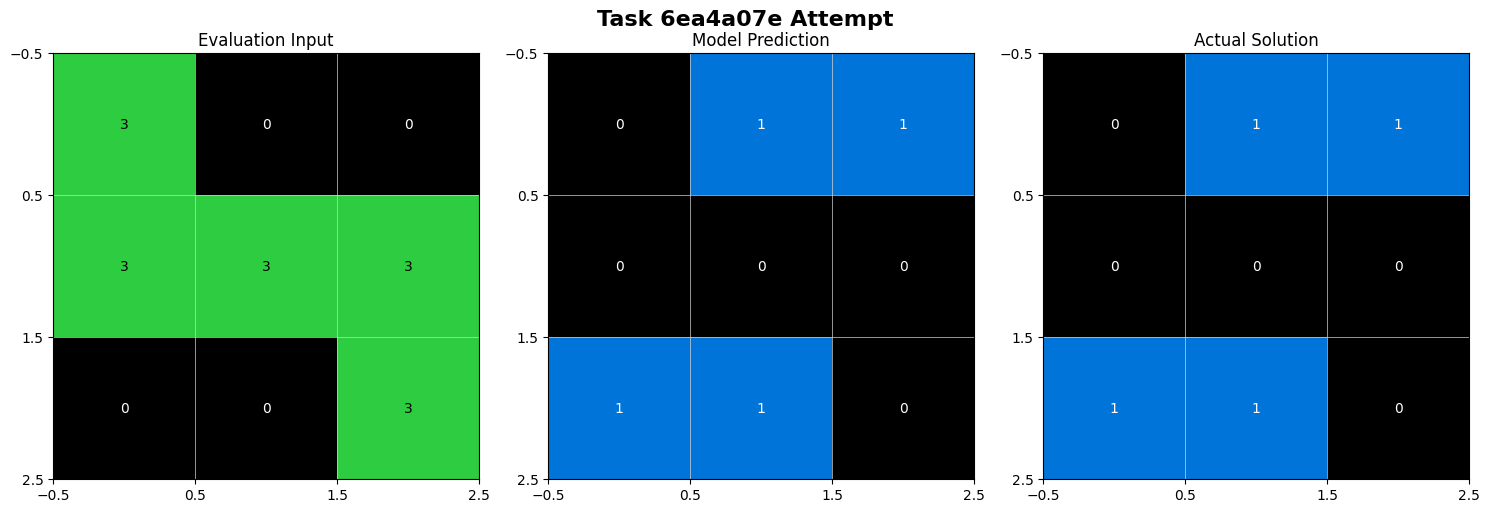


Prediction details for attempt_1, retry 0:
Prediction: [[0, 1, 1], [0, 0, 0], [1, 1, 0]]
Expected solution: [[0, 1, 1], [0, 0, 0], [1, 1, 0]]
Found correct solution in attempt_1, retry 0
2024-12-08 11:29:07,148 - INFO - Plot flag for task 6ea4a07e, attempt 2, retry 0: True
2024-12-08 11:29:07,149 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 0, 0],
[0, 8, 0],
[0, 0, 0],]

Example 1: Output
[
[0, 2, 2],
[2, 0, 2],
[2, 2, 2],]

Example 2: Input
[
[0, 0, 3],
[0, 3, 0],
[3, 0, 0],]

Example 2: Output
[
[1, 1, 0],
[1, 0, 1],
[0, 1, 1],]

Example 3: Input
[
[5, 0, 0],
[5, 5, 0],
[5, 0, 0],]

Example 3: Output
[
[0, 4, 4],
[0, 0, 4],
[0, 4, 4],]

Example 4: Input
[
[5, 5, 5],
[0, 0, 5],
[0, 0, 0],]

Example 4: Output
[
[0, 0, 0],
[4, 4, 0],
[4, 4, 4],]

Example 5: Input
[
[0, 8, 0],
[0, 8, 0],
[8, 0, 0],]

Example 5: Output
[
[2, 0, 2],
[2, 0, 2],
[0, 2, 2],]

Example 6: Input
[
[8, 0, 8],
[0, 8, 0],
[0, 8, 0],]

Example 6: Output
[
[0, 2, 0],
[2, 0, 2],
[2, 0

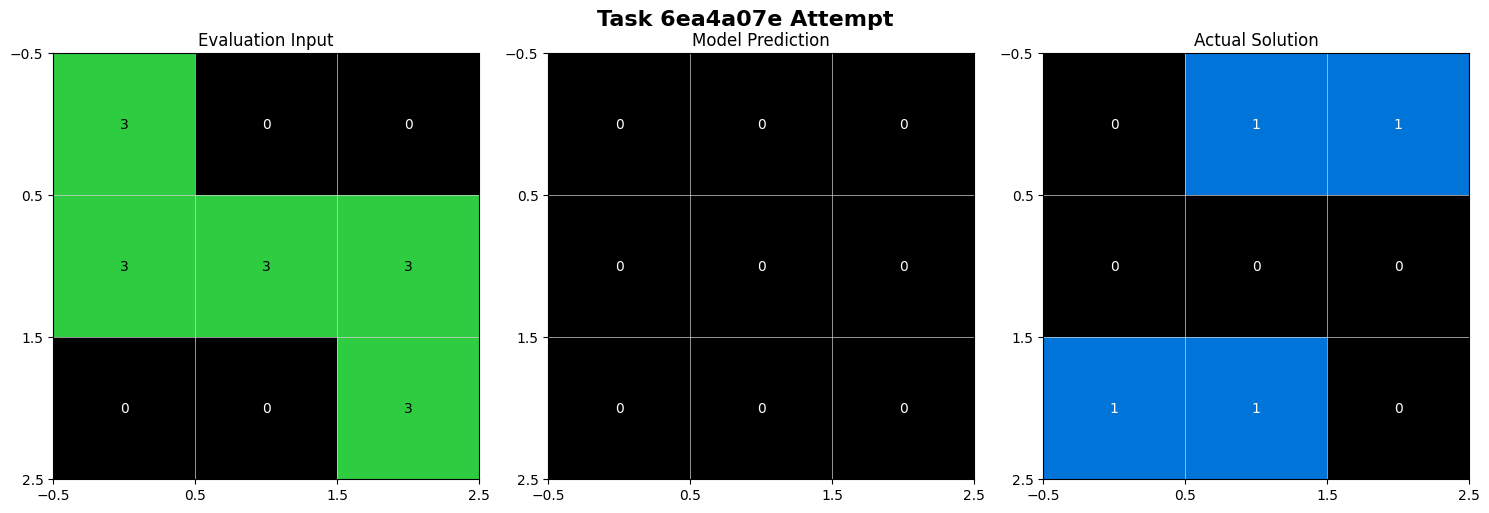


Prediction details for attempt_2, retry 0:
Prediction: [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
Expected solution: [[0, 1, 1], [0, 0, 0], [1, 1, 0]]
2024-12-08 11:29:36,933 - INFO - Starting task #13 (6ea4a07e), pair #2
2024-12-08 11:29:36,935 - INFO - Plot flag for task 6ea4a07e, attempt 1, retry 0: True
2024-12-08 11:29:36,938 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 0, 0],
[0, 8, 0],
[0, 0, 0],]

Example 1: Output
[
[0, 2, 2],
[2, 0, 2],
[2, 2, 2],]

Example 2: Input
[
[0, 0, 3],
[0, 3, 0],
[3, 0, 0],]

Example 2: Output
[
[1, 1, 0],
[1, 0, 1],
[0, 1, 1],]

Example 3: Input
[
[5, 0, 0],
[5, 5, 0],
[5, 0, 0],]

Example 3: Output
[
[0, 4, 4],
[0, 0, 4],
[0, 4, 4],]

Example 4: Input
[
[5, 5, 5],
[0, 0, 5],
[0, 0, 0],]

Example 4: Output
[
[0, 0, 0],
[4, 4, 0],
[4, 4, 4],]

Example 5: Input
[
[0, 8, 0],
[0, 8, 0],
[8, 0, 0],]

Example 5: Output
[
[2, 0, 2],
[2, 0, 2],
[0, 2, 2],]

Example 6: Input
[
[8, 0, 8],
[0, 8, 0],
[0, 8, 0],]

Example 6: Output
[
[

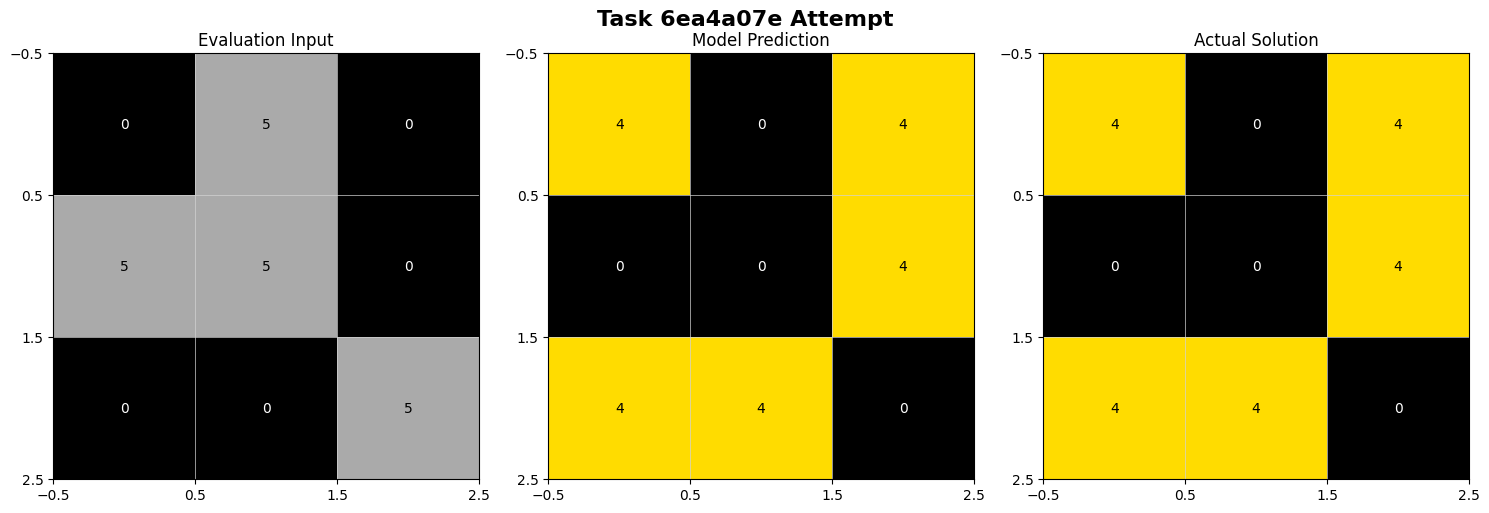


Prediction details for attempt_1, retry 0:
Prediction: [[4, 0, 4], [0, 0, 4], [4, 4, 0]]
Expected solution: [[4, 0, 4], [0, 0, 4], [4, 4, 0]]
Found correct solution in attempt_1, retry 0
2024-12-08 11:30:11,562 - INFO - Plot flag for task 6ea4a07e, attempt 2, retry 0: True
2024-12-08 11:30:11,566 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 0, 0],
[0, 8, 0],
[0, 0, 0],]

Example 1: Output
[
[0, 2, 2],
[2, 0, 2],
[2, 2, 2],]

Example 2: Input
[
[0, 0, 3],
[0, 3, 0],
[3, 0, 0],]

Example 2: Output
[
[1, 1, 0],
[1, 0, 1],
[0, 1, 1],]

Example 3: Input
[
[5, 0, 0],
[5, 5, 0],
[5, 0, 0],]

Example 3: Output
[
[0, 4, 4],
[0, 0, 4],
[0, 4, 4],]

Example 4: Input
[
[5, 5, 5],
[0, 0, 5],
[0, 0, 0],]

Example 4: Output
[
[0, 0, 0],
[4, 4, 0],
[4, 4, 4],]

Example 5: Input
[
[0, 8, 0],
[0, 8, 0],
[8, 0, 0],]

Example 5: Output
[
[2, 0, 2],
[2, 0, 2],
[0, 2, 2],]

Example 6: Input
[
[8, 0, 8],
[0, 8, 0],
[0, 8, 0],]

Example 6: Output
[
[0, 2, 0],
[2, 0, 2],
[2, 0

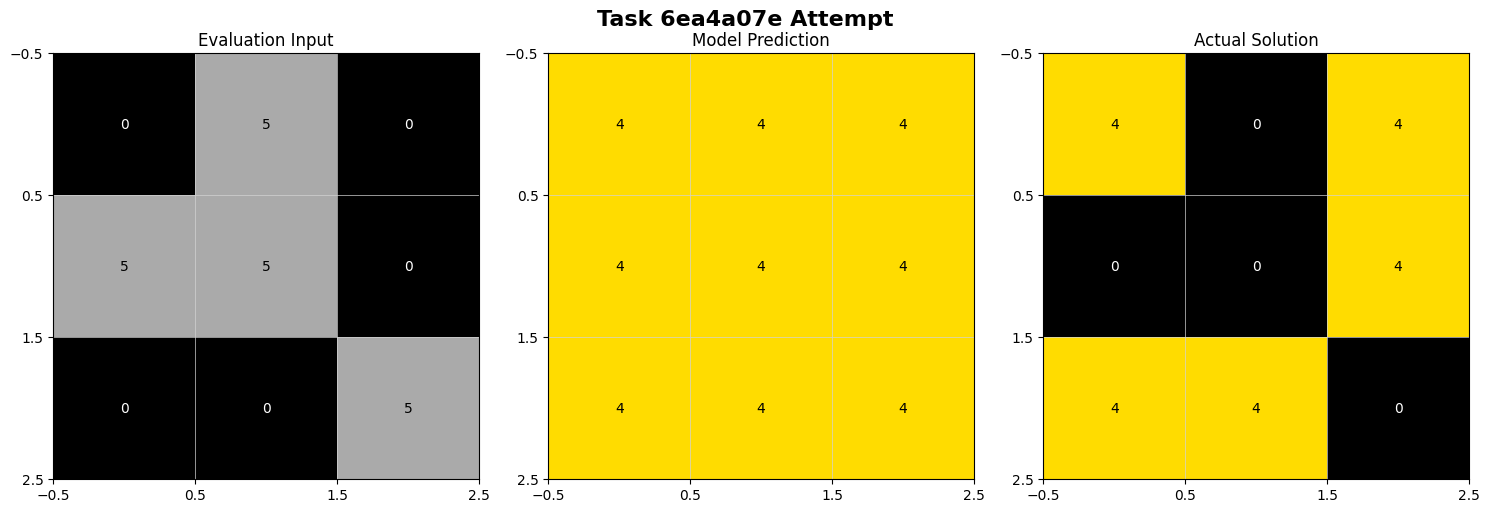


Prediction details for attempt_2, retry 0:
Prediction: [[4, 4, 4], [4, 4, 4], [4, 4, 4]]
Expected solution: [[4, 0, 4], [0, 0, 4], [4, 4, 0]]
2024-12-08 11:30:42,636 - INFO - Starting task #14 (72207abc), pair #1
2024-12-08 11:30:42,637 - INFO - Plot flag for task 72207abc, attempt 1, retry 0: True
2024-12-08 11:30:42,642 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[2, 3, 0, 2, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 2: Input
[
[0, 0, 0, 0, 0, 0, 0, 0,

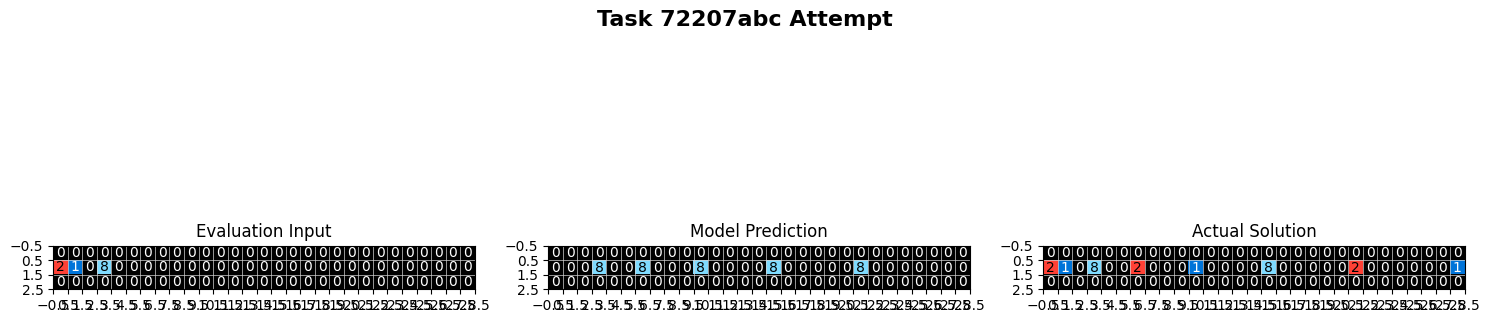


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 8, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Expected solution: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 8, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
2024-12-08 11:31:06,140 - INFO - Plot flag for task 72207abc, attempt 2, retry 0: True
2024-12-08 11:31:06,143 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0

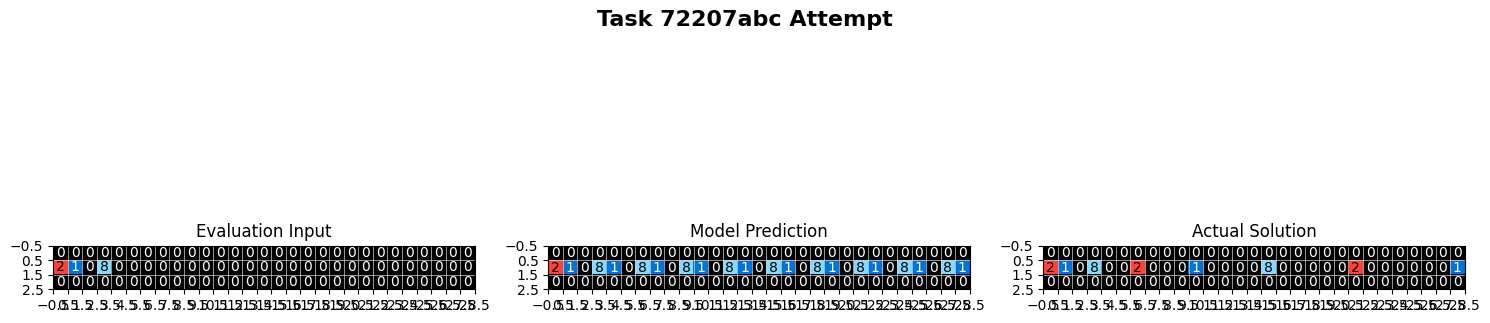


Prediction details for attempt_2, retry 0:
Prediction: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 8, 1, 0, 8, 1, 0, 8, 1, 0, 8, 1, 0, 8, 1, 0, 8, 1, 0, 8, 1, 0, 8, 1, 0, 8, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Expected solution: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 8, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
2024-12-08 11:31:36,648 - INFO - Starting task #15 (8ba14f53), pair #1
2024-12-08 11:31:36,649 - INFO - Plot flag for task 8ba14f53, attempt 1, retry 0: True
2024-12-08 11:31:36,653 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 4, 4, 4, 6, 6, 6, 6, 6],
[0, 4, 0, 4, 6, 0, 0, 0, 6],
[0, 4, 4, 4, 6, 0, 0, 0, 6],
[0, 0, 0, 0, 6, 6, 6, 6, 6],]

Example 1: Outp

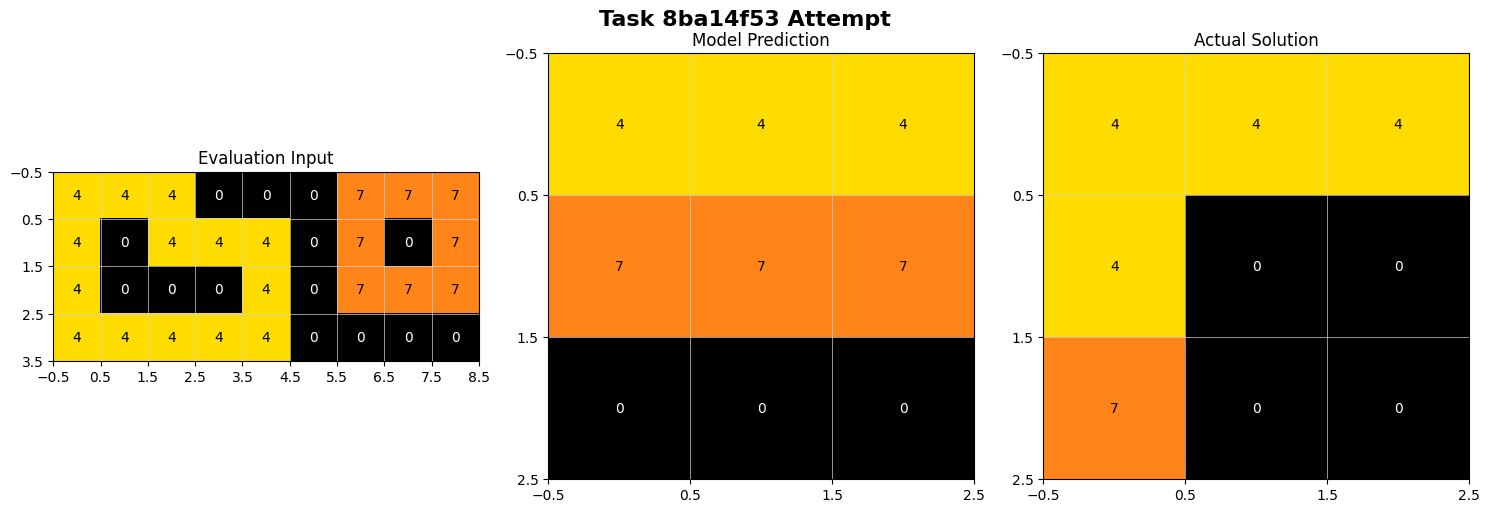


Prediction details for attempt_1, retry 1:
Prediction: [[4, 4, 4], [7, 7, 7], [0, 0, 0]]
Expected solution: [[4, 4, 4], [4, 0, 0], [7, 0, 0]]
2024-12-08 11:32:39,354 - INFO - Plot flag for task 8ba14f53, attempt 2, retry 0: True
2024-12-08 11:32:39,356 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 4, 4, 4, 6, 6, 6, 6, 6],
[0, 4, 0, 4, 6, 0, 0, 0, 6],
[0, 4, 4, 4, 6, 0, 0, 0, 6],
[0, 0, 0, 0, 6, 6, 6, 6, 6],]

Example 1: Output
[
[4, 0, 0],
[6, 6, 6],
[6, 6, 6],]

Example 2: Input
[
[7, 7, 7, 0, 0, 0, 0, 0, 0],
[7, 0, 7, 7, 0, 8, 8, 8, 8],
[7, 0, 0, 7, 0, 8, 0, 0, 8],
[7, 7, 7, 7, 0, 8, 8, 8, 8],]

Example 2: Output
[
[7, 7, 7],
[8, 8, 0],
[0, 0, 0],]

Example 3: Input
[
[9, 9, 9, 9, 0, 5, 5, 5, 5],
[9, 0, 0, 9, 0, 5, 0, 0, 5],
[9, 9, 0, 9, 0, 5, 0, 5, 5],
[0, 9, 9, 9, 0, 5, 5, 5, 0],]

Example 3: Output
[
[9, 9, 9],
[5, 5, 5],
[0, 0, 0],]

Example 4: Input
[
[3, 3, 3, 3, 0, 1, 1, 1, 0],
[3, 0, 0, 3, 0, 1, 0, 1, 0],
[3, 0, 0, 3, 0, 1, 0, 1, 0],
[3, 3, 3,

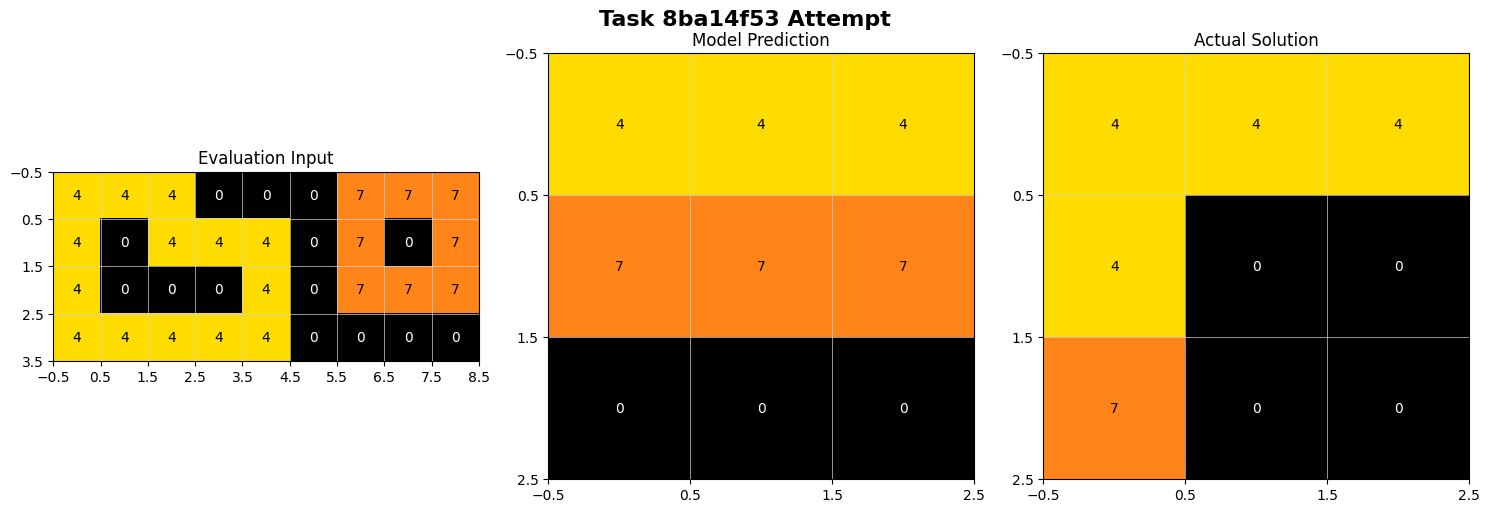


Prediction details for attempt_2, retry 0:
Prediction: [[4, 4, 4], [7, 7, 7], [0, 0, 0]]
Expected solution: [[4, 4, 4], [4, 0, 0], [7, 0, 0]]
2024-12-08 11:33:13,440 - INFO - Starting task #16 (a8610ef7), pair #1
2024-12-08 11:33:13,442 - INFO - Plot flag for task a8610ef7, attempt 1, retry 0: True
2024-12-08 11:33:13,445 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 8, 8, 0, 0, 0],
[0, 0, 8, 8, 0, 8],
[0, 8, 0, 0, 0, 0],
[8, 8, 0, 0, 8, 8],
[8, 0, 8, 8, 8, 8],
[0, 0, 0, 0, 8, 8],]

Example 1: Output
[
[5, 5, 5, 0, 0, 0],
[0, 0, 2, 2, 0, 2],
[0, 2, 0, 0, 0, 0],
[5, 2, 0, 0, 5, 5],
[5, 0, 2, 2, 5, 2],
[0, 0, 0, 0, 5, 5],]

Example 2: Input
[
[8, 8, 0, 8, 8, 0],
[8, 0, 8, 8, 8, 0],
[0, 0, 8, 8, 8, 8],
[0, 8, 0, 0, 8, 8],
[8, 8, 0, 8, 0, 8],
[8, 0, 0, 8, 0, 8],]

Example 2: Output
[
[2, 5, 0, 2, 5, 0],
[2, 0, 5, 2, 5, 0],
[0, 0, 5, 5, 2, 2],
[0, 5, 0, 0, 2, 2],
[2, 5, 0, 2, 0, 5],
[2, 0, 0, 2, 0, 5],]

Example 3: Input
[
[0, 8, 0, 8, 8, 8],
[8, 8, 8, 8, 8,

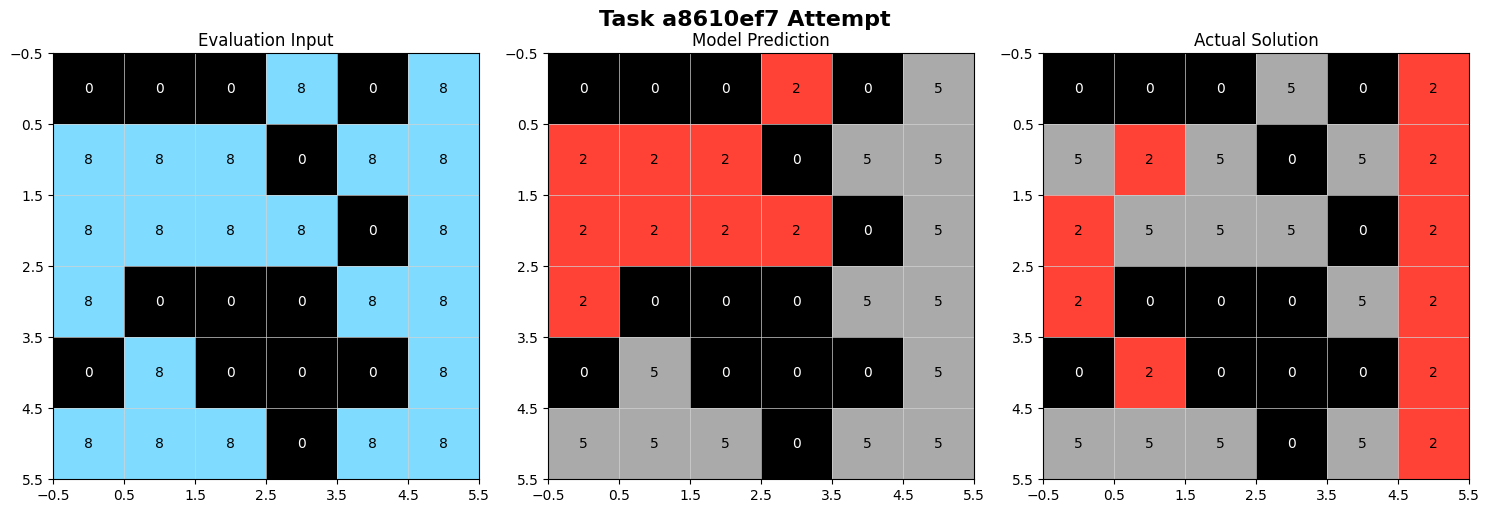


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0, 0, 2, 0, 5], [2, 2, 2, 0, 5, 5], [2, 2, 2, 2, 0, 5], [2, 0, 0, 0, 5, 5], [0, 5, 0, 0, 0, 5], [5, 5, 5, 0, 5, 5]]
Expected solution: [[0, 0, 0, 5, 0, 2], [5, 2, 5, 0, 5, 2], [2, 5, 5, 5, 0, 2], [2, 0, 0, 0, 5, 2], [0, 2, 0, 0, 0, 2], [5, 5, 5, 0, 5, 2]]
2024-12-08 11:33:50,198 - INFO - Plot flag for task a8610ef7, attempt 2, retry 0: True
2024-12-08 11:33:50,201 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[8, 8, 8, 0, 0, 0],
[0, 0, 8, 8, 0, 8],
[0, 8, 0, 0, 0, 0],
[8, 8, 0, 0, 8, 8],
[8, 0, 8, 8, 8, 8],
[0, 0, 0, 0, 8, 8],]

Example 1: Output
[
[5, 5, 5, 0, 0, 0],
[0, 0, 2, 2, 0, 2],
[0, 2, 0, 0, 0, 0],
[5, 2, 0, 0, 5, 5],
[5, 0, 2, 2, 5, 2],
[0, 0, 0, 0, 5, 5],]

Example 2: Input
[
[8, 8, 0, 8, 8, 0],
[8, 0, 8, 8, 8, 0],
[0, 0, 8, 8, 8, 8],
[0, 8, 0, 0, 8, 8],
[8, 8, 0, 8, 0, 8],
[8, 0, 0, 8, 0, 8],]

Example 2: Output
[
[2, 5, 0, 2, 5, 0],
[2, 0, 5, 2, 5, 0],
[0, 0, 5, 5, 2, 2],
[0, 5, 0, 0, 

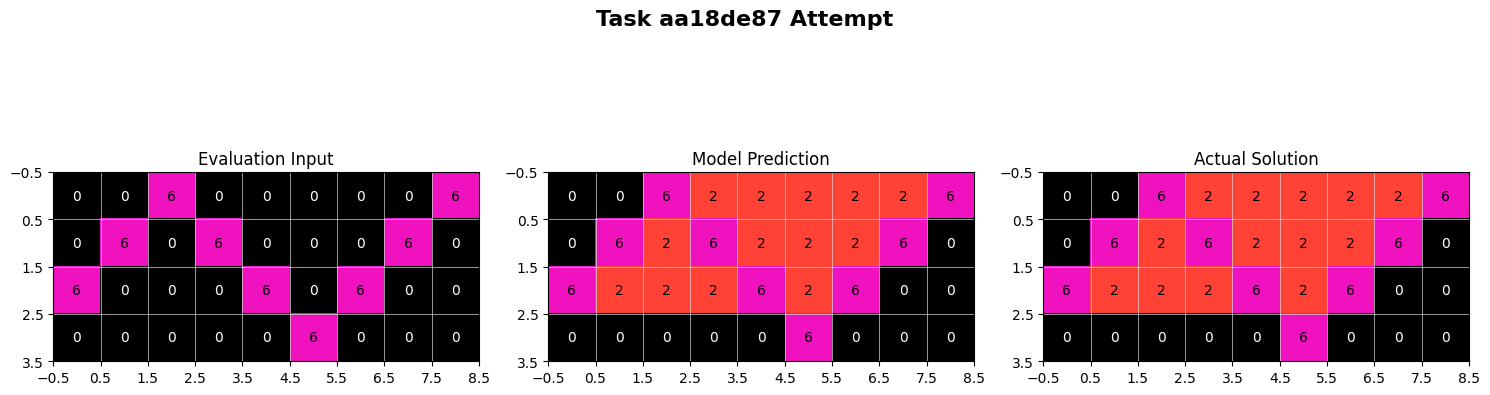


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0, 6, 2, 2, 2, 2, 2, 6], [0, 6, 2, 6, 2, 2, 2, 6, 0], [6, 2, 2, 2, 6, 2, 6, 0, 0], [0, 0, 0, 0, 0, 6, 0, 0, 0]]
Expected solution: [[0, 0, 6, 2, 2, 2, 2, 2, 6], [0, 6, 2, 6, 2, 2, 2, 6, 0], [6, 2, 2, 2, 6, 2, 6, 0, 0], [0, 0, 0, 0, 0, 6, 0, 0, 0]]
Found correct solution in attempt_1, retry 0
2024-12-08 11:34:43,192 - INFO - Plot flag for task aa18de87, attempt 2, retry 0: True
2024-12-08 11:34:43,195 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 3, 0, 0, 0, 0],
[0, 0, 3, 0, 3, 0, 0, 0],
[0, 3, 0, 0, 0, 3, 0, 0],
[3, 0, 0, 0, 0, 0, 3, 0],]

Example 1: Output
[
[0, 0, 0, 3, 0, 0, 0, 0],
[0, 0, 3, 2, 3, 0, 0, 0],
[0, 3, 2, 2, 2, 3, 0, 0],
[3, 2, 2, 2, 2, 2, 3, 0],]

Example 2: Input
[
[0, 4, 0, 0, 0, 4, 0, 0],
[0, 0, 4, 0, 4, 0, 0, 0],
[0, 0, 0, 4, 0, 0, 0, 0],]

Example 2: Output
[
[0, 4, 2, 2, 2, 4, 0, 0],
[0, 0, 4, 2, 4, 0, 0, 0],
[0, 0, 0, 4, 0, 0, 0, 0],]

Example 3: Input
[
[0, 8, 0, 0

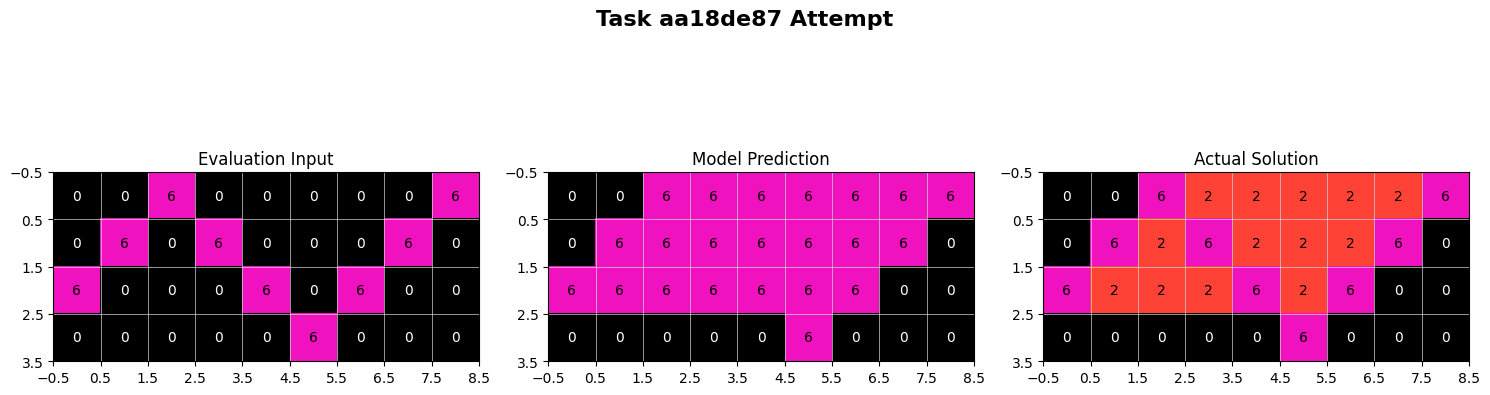


Prediction details for attempt_2, retry 0:
Prediction: [[0, 0, 6, 6, 6, 6, 6, 6, 6], [0, 6, 6, 6, 6, 6, 6, 6, 0], [6, 6, 6, 6, 6, 6, 6, 0, 0], [0, 0, 0, 0, 0, 6, 0, 0, 0]]
Expected solution: [[0, 0, 6, 2, 2, 2, 2, 2, 6], [0, 6, 2, 6, 2, 2, 2, 6, 0], [6, 2, 2, 2, 6, 2, 6, 0, 0], [0, 0, 0, 0, 0, 6, 0, 0, 0]]
2024-12-08 11:35:01,242 - INFO - Starting task #18 (b1fc8b8e), pair #1
2024-12-08 11:35:01,243 - INFO - Plot flag for task b1fc8b8e, attempt 1, retry 0: True
2024-12-08 11:35:01,246 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 8, 0, 0],
[0, 0, 8, 8, 8, 0],
[0, 8, 0, 8, 8, 0],
[8, 8, 8, 0, 0, 0],
[0, 8, 8, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[0, 8, 0, 0, 8],
[8, 8, 0, 8, 8],
[0, 0, 0, 0, 0],
[0, 8, 0, 0, 8],
[8, 8, 0, 8, 8],]

Example 2: Input
[
[8, 8, 8, 8, 0, 0],
[8, 8, 8, 8, 8, 8],
[0, 8, 8, 0, 8, 8],
[0, 8, 8, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[8, 8, 0, 8, 8],
[8, 8, 0, 8, 8],
[0, 0, 0, 0

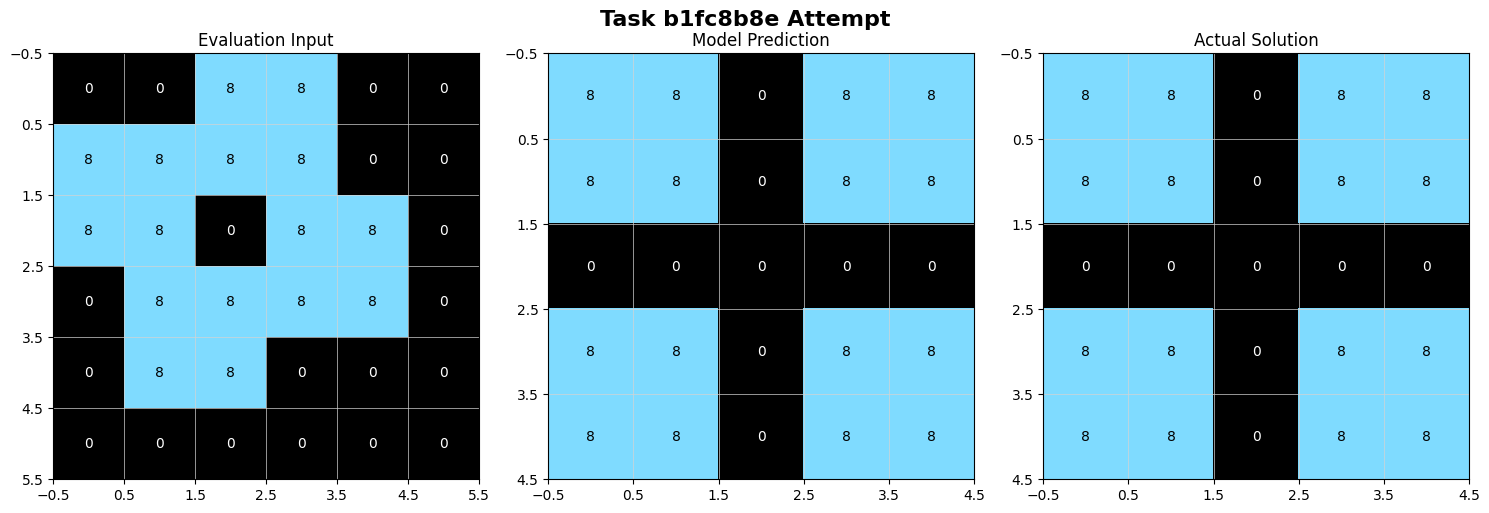


Prediction details for attempt_1, retry 0:
Prediction: [[8, 8, 0, 8, 8], [8, 8, 0, 8, 8], [0, 0, 0, 0, 0], [8, 8, 0, 8, 8], [8, 8, 0, 8, 8]]
Expected solution: [[8, 8, 0, 8, 8], [8, 8, 0, 8, 8], [0, 0, 0, 0, 0], [8, 8, 0, 8, 8], [8, 8, 0, 8, 8]]
Found correct solution in attempt_1, retry 0
2024-12-08 11:35:20,351 - INFO - Plot flag for task b1fc8b8e, attempt 2, retry 0: True
2024-12-08 11:35:20,355 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 8, 0, 0],
[0, 0, 8, 8, 8, 0],
[0, 8, 0, 8, 8, 0],
[8, 8, 8, 0, 0, 0],
[0, 8, 8, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[0, 8, 0, 0, 8],
[8, 8, 0, 8, 8],
[0, 0, 0, 0, 0],
[0, 8, 0, 0, 8],
[8, 8, 0, 8, 8],]

Example 2: Input
[
[8, 8, 8, 8, 0, 0],
[8, 8, 8, 8, 8, 8],
[0, 8, 8, 0, 8, 8],
[0, 8, 8, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[8, 8, 0, 8, 8],
[8, 8, 0, 8, 8],
[0, 0, 0, 0, 0],
[8, 8, 0, 8, 8],
[8, 8, 0, 8, 8],]

Example 3: Input
[
[0, 0, 0, 8, 0, 0],
[0, 8, 

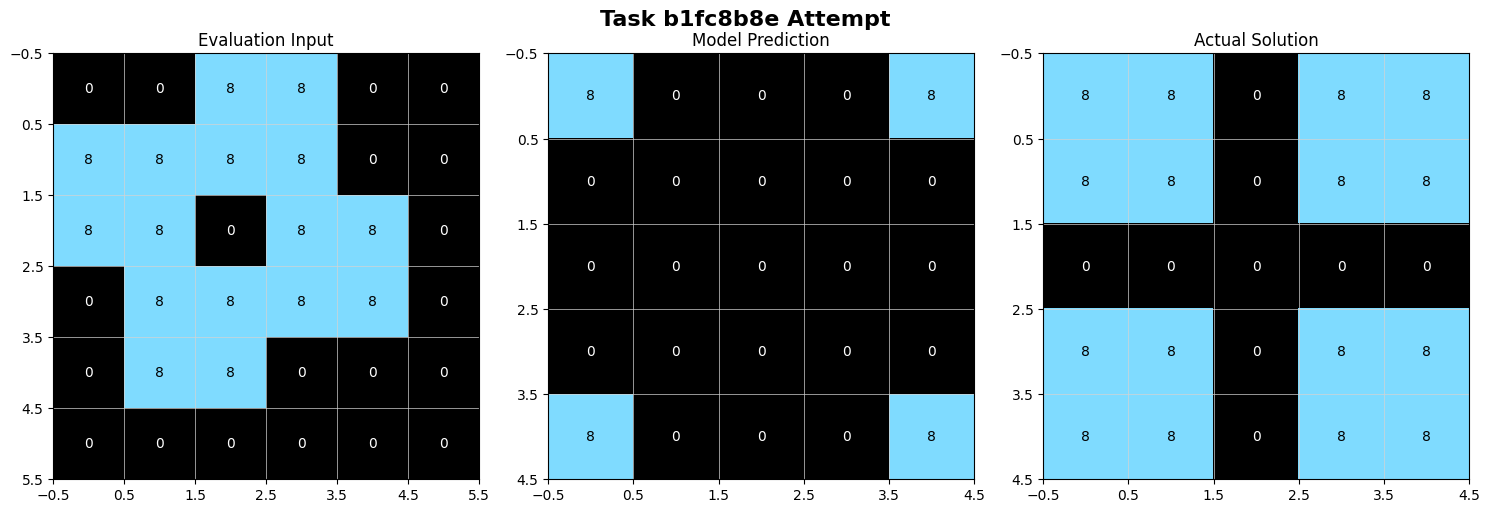


Prediction details for attempt_2, retry 0:
Prediction: [[8, 0, 0, 0, 8], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [8, 0, 0, 0, 8]]
Expected solution: [[8, 8, 0, 8, 8], [8, 8, 0, 8, 8], [0, 0, 0, 0, 0], [8, 8, 0, 8, 8], [8, 8, 0, 8, 8]]
2024-12-08 11:35:34,972 - INFO - Starting task #18 (b1fc8b8e), pair #2
2024-12-08 11:35:34,973 - INFO - Plot flag for task b1fc8b8e, attempt 1, retry 0: True
2024-12-08 11:35:34,976 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 8, 0, 0],
[0, 0, 8, 8, 8, 0],
[0, 8, 0, 8, 8, 0],
[8, 8, 8, 0, 0, 0],
[0, 8, 8, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[0, 8, 0, 0, 8],
[8, 8, 0, 8, 8],
[0, 0, 0, 0, 0],
[0, 8, 0, 0, 8],
[8, 8, 0, 8, 8],]

Example 2: Input
[
[8, 8, 8, 8, 0, 0],
[8, 8, 8, 8, 8, 8],
[0, 8, 8, 0, 8, 8],
[0, 8, 8, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[8, 8, 0, 8, 8],
[8, 8, 0, 8, 8],
[0, 0, 0, 0, 0],
[8, 8, 0, 8, 8],
[8, 8, 0, 8, 8],]

Example 3: Input
[
[

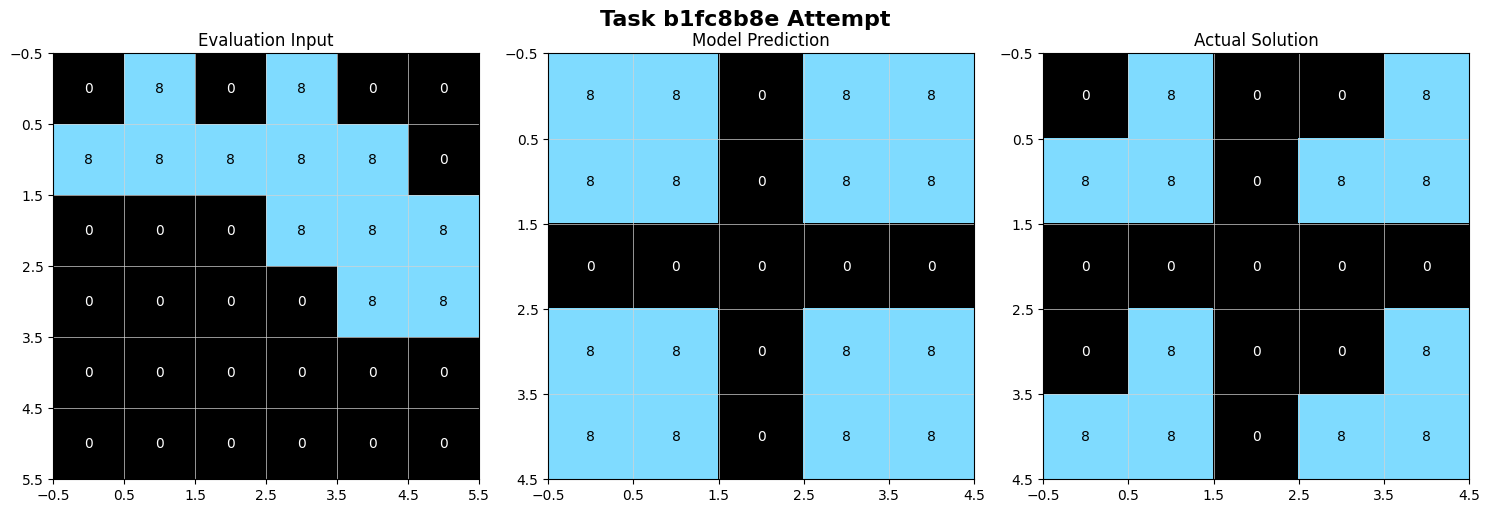


Prediction details for attempt_1, retry 0:
Prediction: [[8, 8, 0, 8, 8], [8, 8, 0, 8, 8], [0, 0, 0, 0, 0], [8, 8, 0, 8, 8], [8, 8, 0, 8, 8]]
Expected solution: [[0, 8, 0, 0, 8], [8, 8, 0, 8, 8], [0, 0, 0, 0, 0], [0, 8, 0, 0, 8], [8, 8, 0, 8, 8]]
2024-12-08 11:35:51,483 - INFO - Plot flag for task b1fc8b8e, attempt 2, retry 0: True
2024-12-08 11:35:51,487 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 8, 0, 0],
[0, 0, 8, 8, 8, 0],
[0, 8, 0, 8, 8, 0],
[8, 8, 8, 0, 0, 0],
[0, 8, 8, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[0, 8, 0, 0, 8],
[8, 8, 0, 8, 8],
[0, 0, 0, 0, 0],
[0, 8, 0, 0, 8],
[8, 8, 0, 8, 8],]

Example 2: Input
[
[8, 8, 8, 8, 0, 0],
[8, 8, 8, 8, 8, 8],
[0, 8, 8, 0, 8, 8],
[0, 8, 8, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[8, 8, 0, 8, 8],
[8, 8, 0, 8, 8],
[0, 0, 0, 0, 0],
[8, 8, 0, 8, 8],
[8, 8, 0, 8, 8],]

Example 3: Input
[
[0, 0, 0, 8, 0, 0],
[0, 8, 8, 8, 8, 0],
[8, 8, 8, 8, 8, 0],
[0, 8, 8, 0,

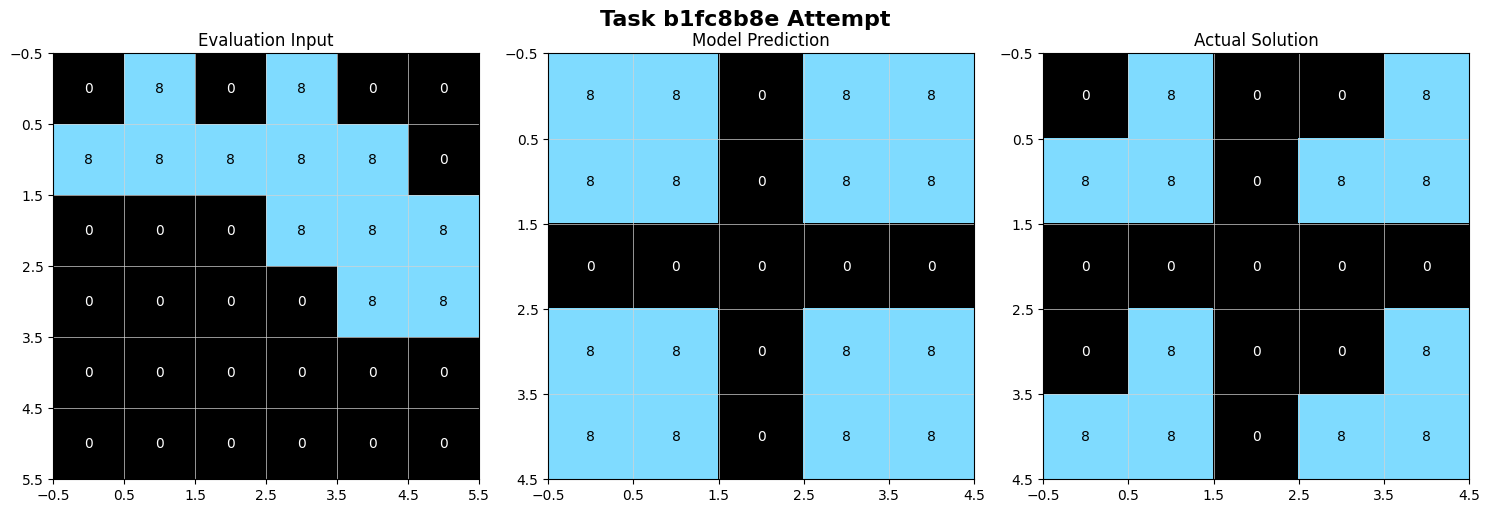


Prediction details for attempt_2, retry 0:
Prediction: [[8, 8, 0, 8, 8], [8, 8, 0, 8, 8], [0, 0, 0, 0, 0], [8, 8, 0, 8, 8], [8, 8, 0, 8, 8]]
Expected solution: [[0, 8, 0, 0, 8], [8, 8, 0, 8, 8], [0, 0, 0, 0, 0], [0, 8, 0, 0, 8], [8, 8, 0, 8, 8]]
2024-12-08 11:36:07,655 - INFO - Starting task #19 (bbb1b8b6), pair #1
2024-12-08 11:36:07,656 - INFO - Plot flag for task bbb1b8b6, attempt 1, retry 0: True
2024-12-08 11:36:07,659 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 1, 5, 2, 2, 2, 0],
[1, 0, 0, 0, 5, 0, 2, 2, 2],
[1, 1, 0, 0, 5, 0, 0, 2, 2],
[1, 1, 1, 0, 5, 0, 0, 0, 2],]

Example 1: Output
[
[2, 2, 2, 1],
[1, 2, 2, 2],
[1, 1, 2, 2],
[1, 1, 1, 2],]

Example 2: Input
[
[0, 0, 0, 1, 5, 2, 2, 0, 0],
[1, 0, 0, 0, 5, 2, 2, 0, 0],
[1, 1, 0, 0, 5, 0, 2, 2, 0],
[1, 1, 1, 0, 5, 0, 2, 2, 0],]

Example 2: Output
[
[0, 0, 0, 1],
[1, 0, 0, 0],
[1, 1, 0, 0],
[1, 1, 1, 0],]

Example 3: Input
[
[1, 1, 0, 0, 5, 0, 0, 3, 3],
[1, 0, 0, 1, 5, 0, 3, 3, 0],
[1, 0, 0,

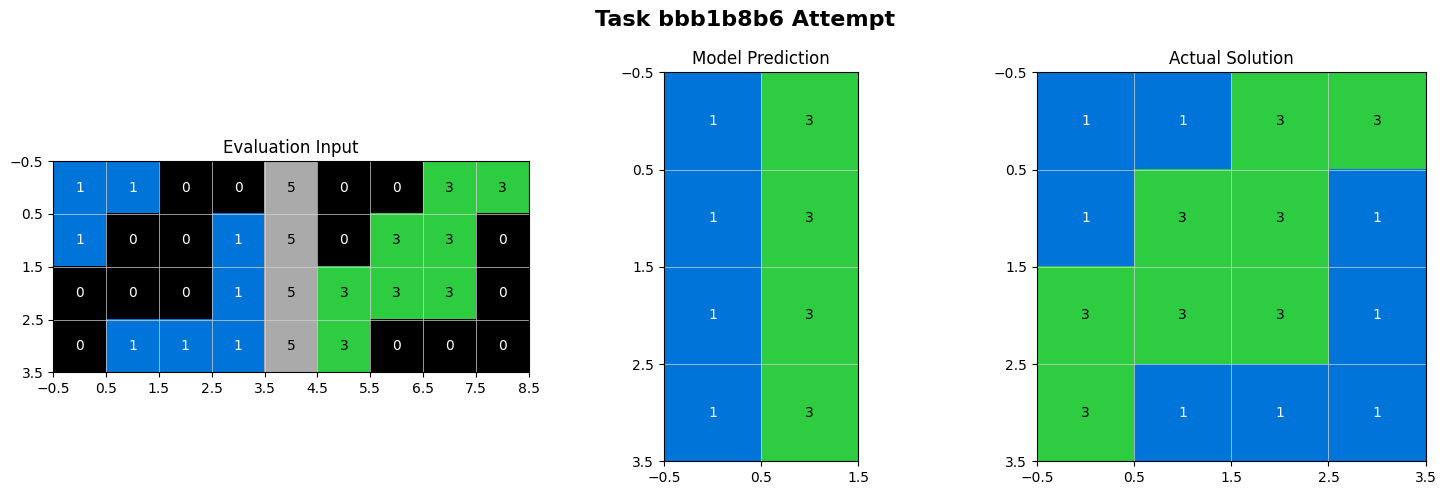


Prediction details for attempt_1, retry 0:
Prediction: [[1, 3], [1, 3], [1, 3], [1, 3]]
Expected solution: [[1, 1, 3, 3], [1, 3, 3, 1], [3, 3, 3, 1], [3, 1, 1, 1]]
2024-12-08 11:36:28,539 - INFO - Plot flag for task bbb1b8b6, attempt 2, retry 0: True
2024-12-08 11:36:28,542 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 1, 5, 2, 2, 2, 0],
[1, 0, 0, 0, 5, 0, 2, 2, 2],
[1, 1, 0, 0, 5, 0, 0, 2, 2],
[1, 1, 1, 0, 5, 0, 0, 0, 2],]

Example 1: Output
[
[2, 2, 2, 1],
[1, 2, 2, 2],
[1, 1, 2, 2],
[1, 1, 1, 2],]

Example 2: Input
[
[0, 0, 0, 1, 5, 2, 2, 0, 0],
[1, 0, 0, 0, 5, 2, 2, 0, 0],
[1, 1, 0, 0, 5, 0, 2, 2, 0],
[1, 1, 1, 0, 5, 0, 2, 2, 0],]

Example 2: Output
[
[0, 0, 0, 1],
[1, 0, 0, 0],
[1, 1, 0, 0],
[1, 1, 1, 0],]

Example 3: Input
[
[1, 1, 0, 0, 5, 0, 0, 3, 3],
[1, 0, 0, 1, 5, 0, 3, 3, 0],
[1, 0, 0, 1, 5, 0, 3, 3, 0],
[1, 1, 0, 0, 5, 0, 0, 3, 3],]

Example 3: Output
[
[1, 1, 3, 3],
[1, 3, 3, 1],
[1, 3, 3, 1],
[1, 1, 3, 3],]

Example 4: Input
[
[1, 1

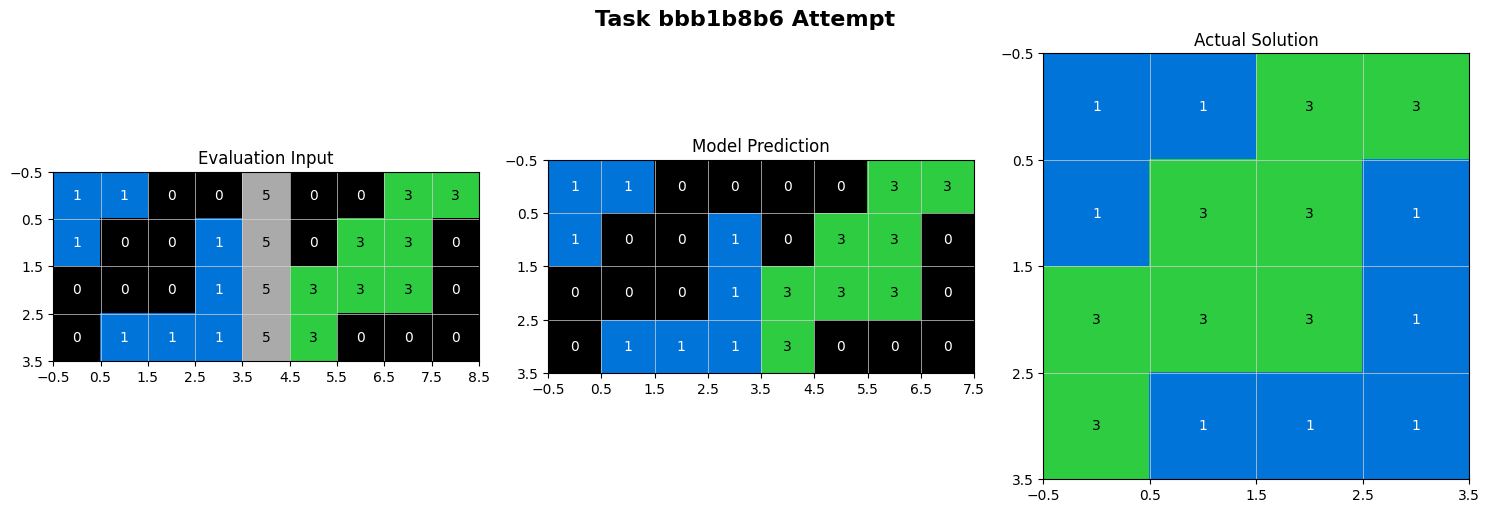


Prediction details for attempt_2, retry 0:
Prediction: [[1, 1, 0, 0, 0, 0, 3, 3], [1, 0, 0, 1, 0, 3, 3, 0], [0, 0, 0, 1, 3, 3, 3, 0], [0, 1, 1, 1, 3, 0, 0, 0]]
Expected solution: [[1, 1, 3, 3], [1, 3, 3, 1], [3, 3, 3, 1], [3, 1, 1, 1]]
2024-12-08 11:36:46,113 - INFO - Starting task #19 (bbb1b8b6), pair #2
2024-12-08 11:36:46,113 - INFO - Plot flag for task bbb1b8b6, attempt 1, retry 0: True
2024-12-08 11:36:46,115 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 1, 5, 2, 2, 2, 0],
[1, 0, 0, 0, 5, 0, 2, 2, 2],
[1, 1, 0, 0, 5, 0, 0, 2, 2],
[1, 1, 1, 0, 5, 0, 0, 0, 2],]

Example 1: Output
[
[2, 2, 2, 1],
[1, 2, 2, 2],
[1, 1, 2, 2],
[1, 1, 1, 2],]

Example 2: Input
[
[0, 0, 0, 1, 5, 2, 2, 0, 0],
[1, 0, 0, 0, 5, 2, 2, 0, 0],
[1, 1, 0, 0, 5, 0, 2, 2, 0],
[1, 1, 1, 0, 5, 0, 2, 2, 0],]

Example 2: Output
[
[0, 0, 0, 1],
[1, 0, 0, 0],
[1, 1, 0, 0],
[1, 1, 1, 0],]

Example 3: Input
[
[1, 1, 0, 0, 5, 0, 0, 3, 3],
[1, 0, 0, 1, 5, 0, 3, 3, 0],
[1, 0, 0, 1, 5, 0, 

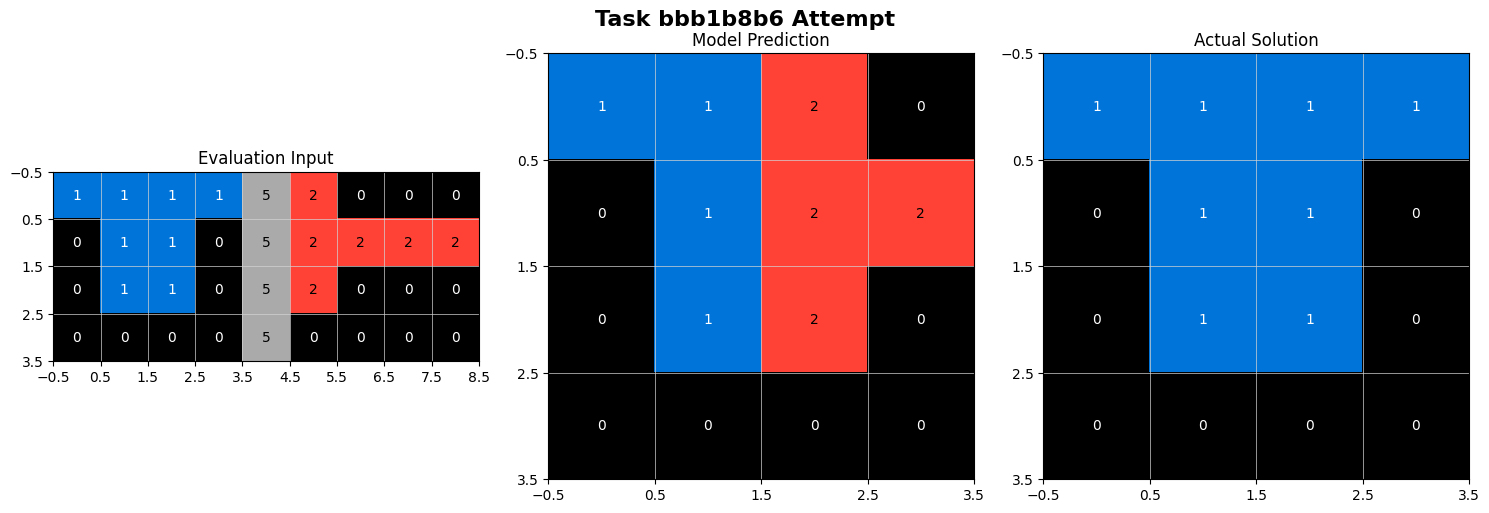


Prediction details for attempt_1, retry 0:
Prediction: [[1, 1, 2, 0], [0, 1, 2, 2], [0, 1, 2, 0], [0, 0, 0, 0]]
Expected solution: [[1, 1, 1, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 0, 0, 0]]
2024-12-08 11:37:13,982 - INFO - Plot flag for task bbb1b8b6, attempt 2, retry 0: True
2024-12-08 11:37:13,985 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 1, 5, 2, 2, 2, 0],
[1, 0, 0, 0, 5, 0, 2, 2, 2],
[1, 1, 0, 0, 5, 0, 0, 2, 2],
[1, 1, 1, 0, 5, 0, 0, 0, 2],]

Example 1: Output
[
[2, 2, 2, 1],
[1, 2, 2, 2],
[1, 1, 2, 2],
[1, 1, 1, 2],]

Example 2: Input
[
[0, 0, 0, 1, 5, 2, 2, 0, 0],
[1, 0, 0, 0, 5, 2, 2, 0, 0],
[1, 1, 0, 0, 5, 0, 2, 2, 0],
[1, 1, 1, 0, 5, 0, 2, 2, 0],]

Example 2: Output
[
[0, 0, 0, 1],
[1, 0, 0, 0],
[1, 1, 0, 0],
[1, 1, 1, 0],]

Example 3: Input
[
[1, 1, 0, 0, 5, 0, 0, 3, 3],
[1, 0, 0, 1, 5, 0, 3, 3, 0],
[1, 0, 0, 1, 5, 0, 3, 3, 0],
[1, 1, 0, 0, 5, 0, 0, 3, 3],]

Example 3: Output
[
[1, 1, 3, 3],
[1, 3, 3, 1],
[1, 3, 3, 1],
[1, 1, 3, 3],]



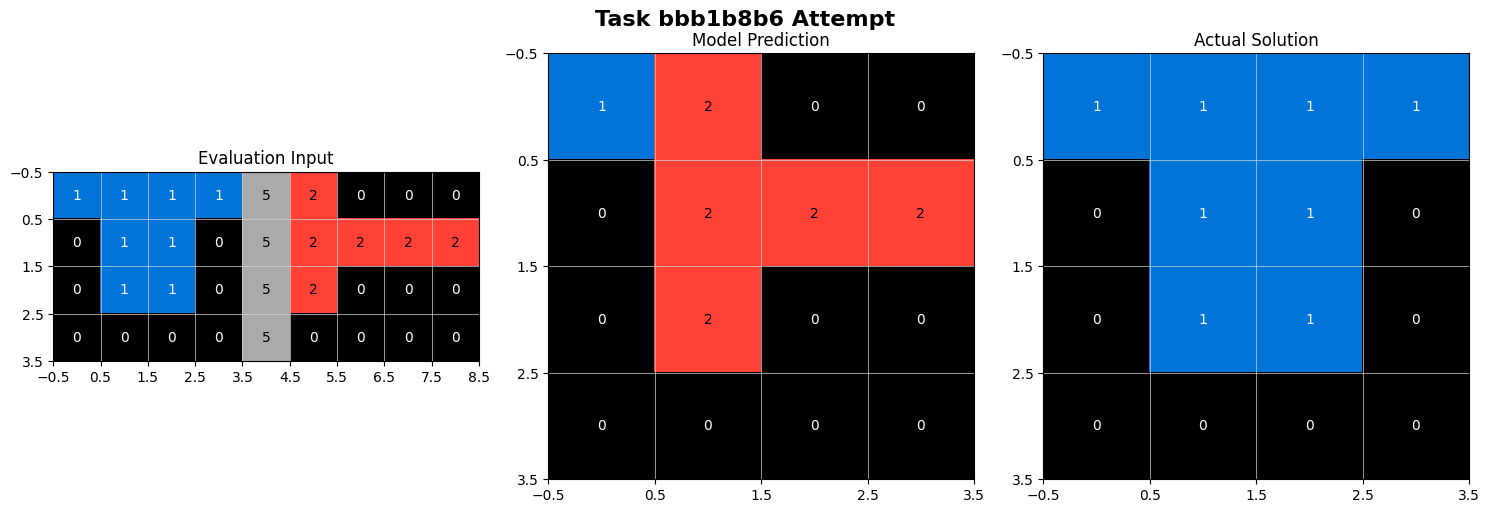


Prediction details for attempt_2, retry 0:
Prediction: [[1, 2, 0, 0], [0, 2, 2, 2], [0, 2, 0, 0], [0, 0, 0, 0]]
Expected solution: [[1, 1, 1, 1], [0, 1, 1, 0], [0, 1, 1, 0], [0, 0, 0, 0]]
2024-12-08 11:37:38,738 - INFO - Starting task #20 (be03b35f), pair #1
2024-12-08 11:37:38,739 - INFO - Plot flag for task be03b35f, attempt 1, retry 0: True
2024-12-08 11:37:38,741 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[1, 1, 0, 1, 1],
[1, 0, 0, 0, 1],
[0, 0, 0, 0, 0],
[0, 1, 0, 2, 2],
[1, 1, 0, 2, 2],]

Example 1: Output
[
[1, 0],
[1, 1],]

Example 2: Input
[
[1, 0, 0, 1, 1],
[1, 1, 0, 1, 0],
[0, 0, 0, 0, 0],
[1, 1, 0, 2, 2],
[0, 1, 0, 2, 2],]

Example 2: Output
[
[0, 1],
[1, 1],]

Example 3: Input
[
[1, 1, 0, 0, 1],
[0, 0, 0, 0, 1],
[0, 0, 0, 0, 0],
[0, 0, 0, 2, 2],
[1, 1, 0, 2, 2],]

Example 3: Output
[
[1, 0],
[1, 0],]

Test
[
[1, 1, 0, 0, 1]
[0, 1, 0, 1, 1]
[0, 0, 0, 0, 0]
[1, 0, 0, 2, 2]
[1, 1, 0, 2, 2]]

Your Response: with predicted grid size: 2x2
Debug - 

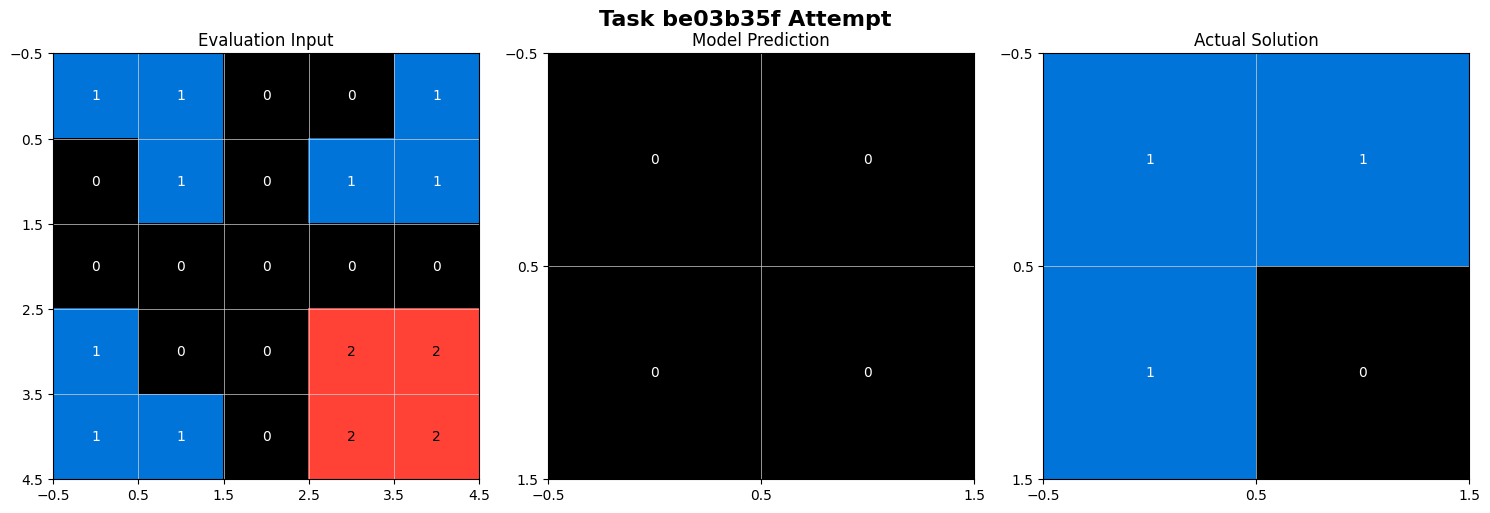


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0], [0, 0]]
Expected solution: [[1, 1], [1, 0]]
2024-12-08 11:37:58,308 - INFO - Plot flag for task be03b35f, attempt 2, retry 0: True
2024-12-08 11:37:58,311 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[1, 1, 0, 1, 1],
[1, 0, 0, 0, 1],
[0, 0, 0, 0, 0],
[0, 1, 0, 2, 2],
[1, 1, 0, 2, 2],]

Example 1: Output
[
[1, 0],
[1, 1],]

Example 2: Input
[
[1, 0, 0, 1, 1],
[1, 1, 0, 1, 0],
[0, 0, 0, 0, 0],
[1, 1, 0, 2, 2],
[0, 1, 0, 2, 2],]

Example 2: Output
[
[0, 1],
[1, 1],]

Example 3: Input
[
[1, 1, 0, 0, 1],
[0, 0, 0, 0, 1],
[0, 0, 0, 0, 0],
[0, 0, 0, 2, 2],
[1, 1, 0, 2, 2],]

Example 3: Output
[
[1, 0],
[1, 0],]

Test
[
[1, 1, 0, 0, 1]
[0, 1, 0, 1, 1]
[0, 0, 0, 0, 0]
[1, 0, 0, 2, 2]
[1, 1, 0, 2, 2]]

Your Response: with predicted grid size: 2x2
Debug - Plotting dimensions:
Test input shape: (5, 5)
Predicted solution shape: (2, 2)
Actual solution shape: (2, 2)
2024-12-08 11:38:14,798 - INFO - Plotting 

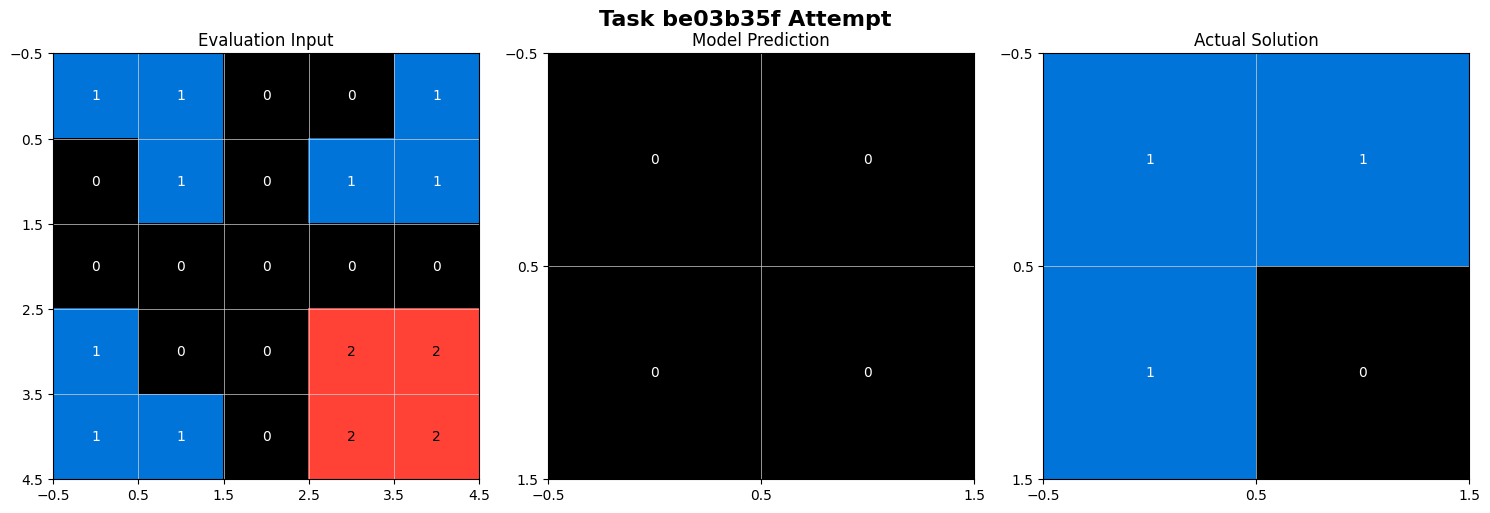


Prediction details for attempt_2, retry 0:
Prediction: [[0, 0], [0, 0]]
Expected solution: [[1, 1], [1, 0]]
2024-12-08 11:38:15,300 - INFO - Starting task #21 (ca8de6ea), pair #1
2024-12-08 11:38:15,301 - INFO - Plot flag for task ca8de6ea, attempt 1, retry 0: True
2024-12-08 11:38:15,305 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[1, 0, 0, 0, 9],
[0, 5, 0, 8, 0],
[0, 0, 7, 0, 0],
[0, 8, 0, 5, 0],
[9, 0, 0, 0, 1],]

Example 1: Output
[
[1, 5, 9],
[8, 7, 8],
[9, 5, 1],]

Example 2: Input
[
[6, 0, 0, 0, 7],
[0, 2, 0, 4, 0],
[0, 0, 3, 0, 0],
[0, 4, 0, 2, 0],
[7, 0, 0, 0, 6],]

Example 2: Output
[
[6, 2, 7],
[4, 3, 4],
[7, 2, 6],]

Example 3: Input
[
[2, 0, 0, 0, 1],
[0, 3, 0, 6, 0],
[0, 0, 4, 0, 0],
[0, 6, 0, 3, 0],
[1, 0, 0, 0, 2],]

Example 3: Output
[
[2, 3, 1],
[6, 4, 6],
[1, 3, 2],]

Test
[
[7, 0, 0, 0, 5]
[0, 6, 0, 4, 0]
[0, 0, 2, 0, 0]
[0, 4, 0, 6, 0]
[5, 0, 0, 0, 7]]

Your Response: with predicted grid size: 3x3
Debug - Plotting dimensions:
Test inp

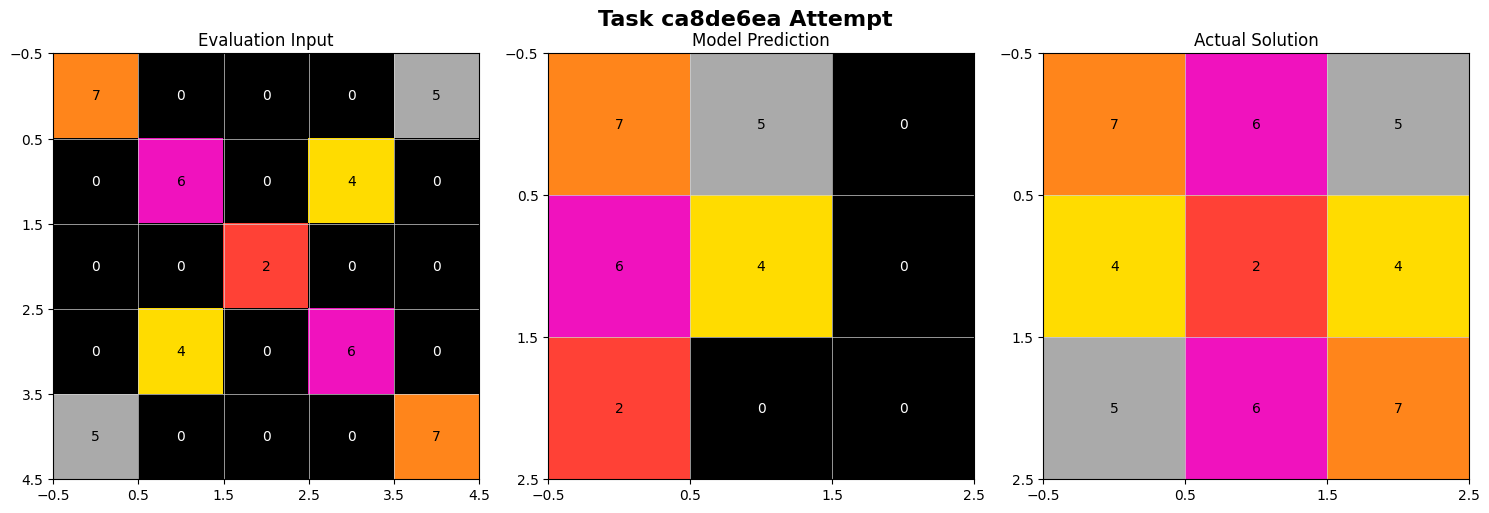


Prediction details for attempt_1, retry 0:
Prediction: [[7, 5, 0], [6, 4, 0], [2, 0, 0]]
Expected solution: [[7, 6, 5], [4, 2, 4], [5, 6, 7]]
2024-12-08 11:38:30,207 - INFO - Plot flag for task ca8de6ea, attempt 2, retry 0: True
2024-12-08 11:38:30,209 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[1, 0, 0, 0, 9],
[0, 5, 0, 8, 0],
[0, 0, 7, 0, 0],
[0, 8, 0, 5, 0],
[9, 0, 0, 0, 1],]

Example 1: Output
[
[1, 5, 9],
[8, 7, 8],
[9, 5, 1],]

Example 2: Input
[
[6, 0, 0, 0, 7],
[0, 2, 0, 4, 0],
[0, 0, 3, 0, 0],
[0, 4, 0, 2, 0],
[7, 0, 0, 0, 6],]

Example 2: Output
[
[6, 2, 7],
[4, 3, 4],
[7, 2, 6],]

Example 3: Input
[
[2, 0, 0, 0, 1],
[0, 3, 0, 6, 0],
[0, 0, 4, 0, 0],
[0, 6, 0, 3, 0],
[1, 0, 0, 0, 2],]

Example 3: Output
[
[2, 3, 1],
[6, 4, 6],
[1, 3, 2],]

Test
[
[7, 0, 0, 0, 5]
[0, 6, 0, 4, 0]
[0, 0, 2, 0, 0]
[0, 4, 0, 6, 0]
[5, 0, 0, 0, 7]]

Your Response: with predicted grid size: 3x3
Debug - Plotting dimensions:
Test input shape: (5, 5)
Predicted solution s

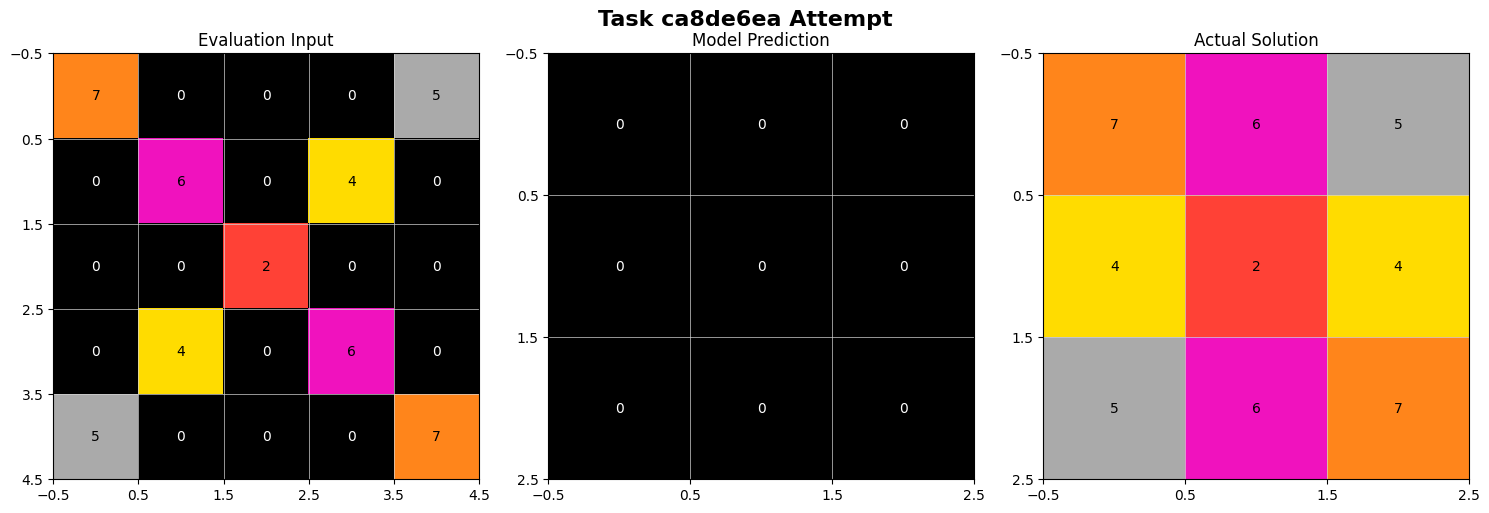


Prediction details for attempt_2, retry 0:
Prediction: [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
Expected solution: [[7, 6, 5], [4, 2, 4], [5, 6, 7]]
2024-12-08 11:38:55,943 - INFO - Starting task #22 (d017b73f), pair #1
2024-12-08 11:38:55,944 - INFO - Plot flag for task d017b73f, attempt 1, retry 0: True
2024-12-08 11:38:55,946 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 2, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 0, 1, 1, 0, 2, 2, 2],
[0, 0, 0, 0, 1, 0, 0, 0, 0],]

Example 1: Output
[
[0, 2, 1, 1, 0, 0, 0],
[2, 2, 0, 1, 2, 2, 2],
[0, 0, 0, 0, 0, 0, 0],]

Example 2: Input
[
[0, 0, 0, 3, 3, 0, 0, 1, 0, 2, 2],
[2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2],
[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[0, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 0, 0, 0, 1, 2, 2],
[0, 2, 3, 3, 1, 1, 0, 2],]

Example 3: Input
[
[0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0],
[2, 2, 2, 0, 8, 8, 8, 0, 0, 0, 0],
[0, 0, 2, 0, 0, 0, 0, 0, 6, 6, 6],]

Example 3: Output
[
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 2, 0, 0, 8, 6

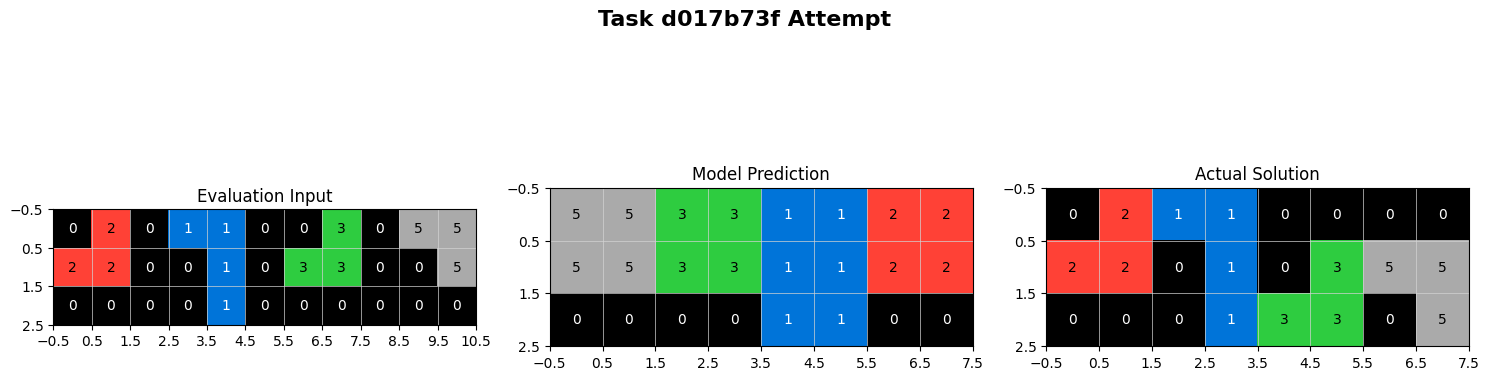


Prediction details for attempt_1, retry 0:
Prediction: [[5, 5, 3, 3, 1, 1, 2, 2], [5, 5, 3, 3, 1, 1, 2, 2], [0, 0, 0, 0, 1, 1, 0, 0]]
Expected solution: [[0, 2, 1, 1, 0, 0, 0, 0], [2, 2, 0, 1, 0, 3, 5, 5], [0, 0, 0, 1, 3, 3, 0, 5]]
2024-12-08 11:39:19,182 - INFO - Plot flag for task d017b73f, attempt 2, retry 0: True
2024-12-08 11:39:19,185 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 2, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 0, 1, 1, 0, 2, 2, 2],
[0, 0, 0, 0, 1, 0, 0, 0, 0],]

Example 1: Output
[
[0, 2, 1, 1, 0, 0, 0],
[2, 2, 0, 1, 2, 2, 2],
[0, 0, 0, 0, 0, 0, 0],]

Example 2: Input
[
[0, 0, 0, 3, 3, 0, 0, 1, 0, 2, 2],
[2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2],
[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[0, 0, 0, 0, 0, 0, 0, 0],
[2, 2, 0, 0, 0, 1, 2, 2],
[0, 2, 3, 3, 1, 1, 0, 2],]

Example 3: Input
[
[0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0],
[2, 2, 2, 0, 8, 8, 8, 0, 0, 0, 0],
[0, 0, 2, 0, 0, 0, 0, 0, 6, 6, 6],]

Example 3: Output
[
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[

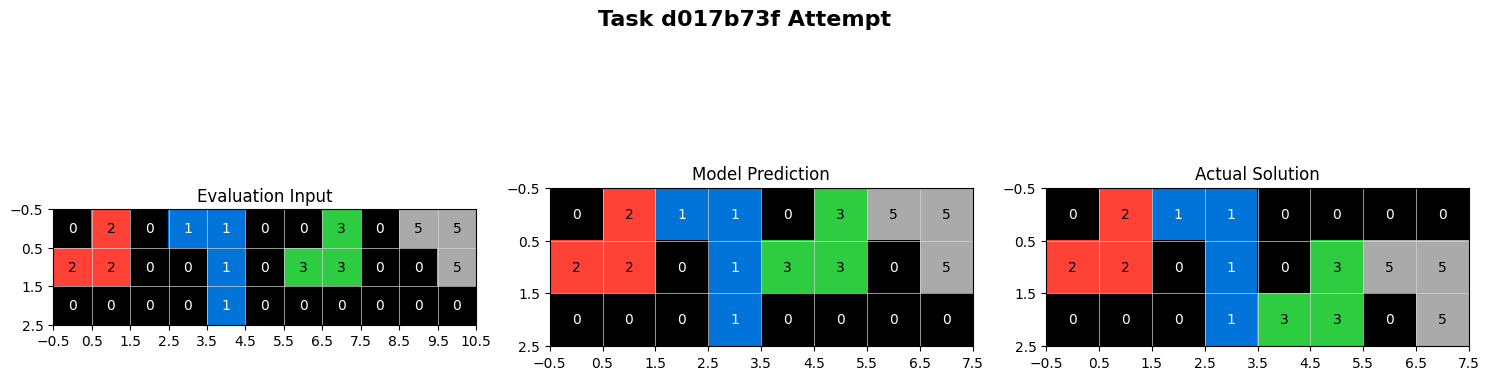


Prediction details for attempt_2, retry 0:
Prediction: [[0, 2, 1, 1, 0, 3, 5, 5], [2, 2, 0, 1, 3, 3, 0, 5], [0, 0, 0, 1, 0, 0, 0, 0]]
Expected solution: [[0, 2, 1, 1, 0, 0, 0, 0], [2, 2, 0, 1, 0, 3, 5, 5], [0, 0, 0, 1, 3, 3, 0, 5]]
2024-12-08 11:39:37,939 - INFO - Starting task #23 (e133d23d), pair #1
2024-12-08 11:39:37,940 - INFO - Plot flag for task e133d23d, attempt 1, retry 0: True
2024-12-08 11:39:37,944 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[6, 0, 0, 4, 0, 0, 8],
[0, 6, 0, 4, 0, 0, 8],
[0, 6, 0, 4, 8, 8, 0],]

Example 1: Output
[
[2, 0, 2],
[0, 2, 2],
[2, 2, 0],]

Example 2: Input
[
[0, 0, 6, 4, 8, 8, 0],
[0, 6, 0, 4, 0, 8, 8],
[0, 6, 6, 4, 8, 0, 0],]

Example 2: Output
[
[2, 2, 2],
[0, 2, 2],
[2, 2, 2],]

Example 3: Input
[
[0, 0, 6, 4, 8, 0, 8],
[6, 0, 6, 4, 0, 0, 0],
[0, 6, 6, 4, 8, 0, 8],]

Example 3: Output
[
[2, 0, 2],
[2, 0, 2],
[2, 2, 2],]

Example 4: Input
[
[6, 0, 6, 4, 0, 0, 0],
[6, 6, 0, 4, 8, 0, 8],
[6, 6, 6, 4, 0, 8, 0],]

Examp

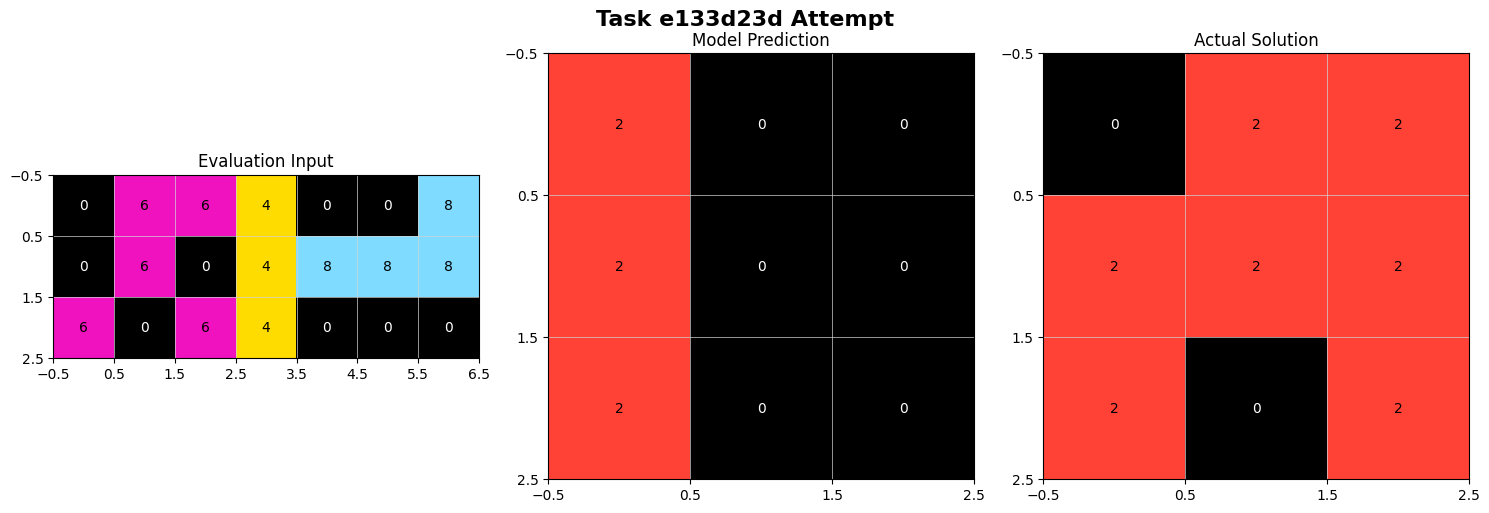


Prediction details for attempt_1, retry 0:
Prediction: [[2, 0, 0], [2, 0, 0], [2, 0, 0]]
Expected solution: [[0, 2, 2], [2, 2, 2], [2, 0, 2]]
2024-12-08 11:39:55,294 - INFO - Plot flag for task e133d23d, attempt 2, retry 0: True
2024-12-08 11:39:55,296 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[6, 0, 0, 4, 0, 0, 8],
[0, 6, 0, 4, 0, 0, 8],
[0, 6, 0, 4, 8, 8, 0],]

Example 1: Output
[
[2, 0, 2],
[0, 2, 2],
[2, 2, 0],]

Example 2: Input
[
[0, 0, 6, 4, 8, 8, 0],
[0, 6, 0, 4, 0, 8, 8],
[0, 6, 6, 4, 8, 0, 0],]

Example 2: Output
[
[2, 2, 2],
[0, 2, 2],
[2, 2, 2],]

Example 3: Input
[
[0, 0, 6, 4, 8, 0, 8],
[6, 0, 6, 4, 0, 0, 0],
[0, 6, 6, 4, 8, 0, 8],]

Example 3: Output
[
[2, 0, 2],
[2, 0, 2],
[2, 2, 2],]

Example 4: Input
[
[6, 0, 6, 4, 0, 0, 0],
[6, 6, 0, 4, 8, 0, 8],
[6, 6, 6, 4, 0, 8, 0],]

Example 4: Output
[
[2, 0, 2],
[2, 2, 2],
[2, 2, 2],]

Example 5: Input
[
[0, 0, 6, 4, 8, 0, 8],
[0, 6, 0, 4, 0, 8, 0],
[0, 0, 0, 4, 8, 0, 0],]

Example 5: Output
[
[

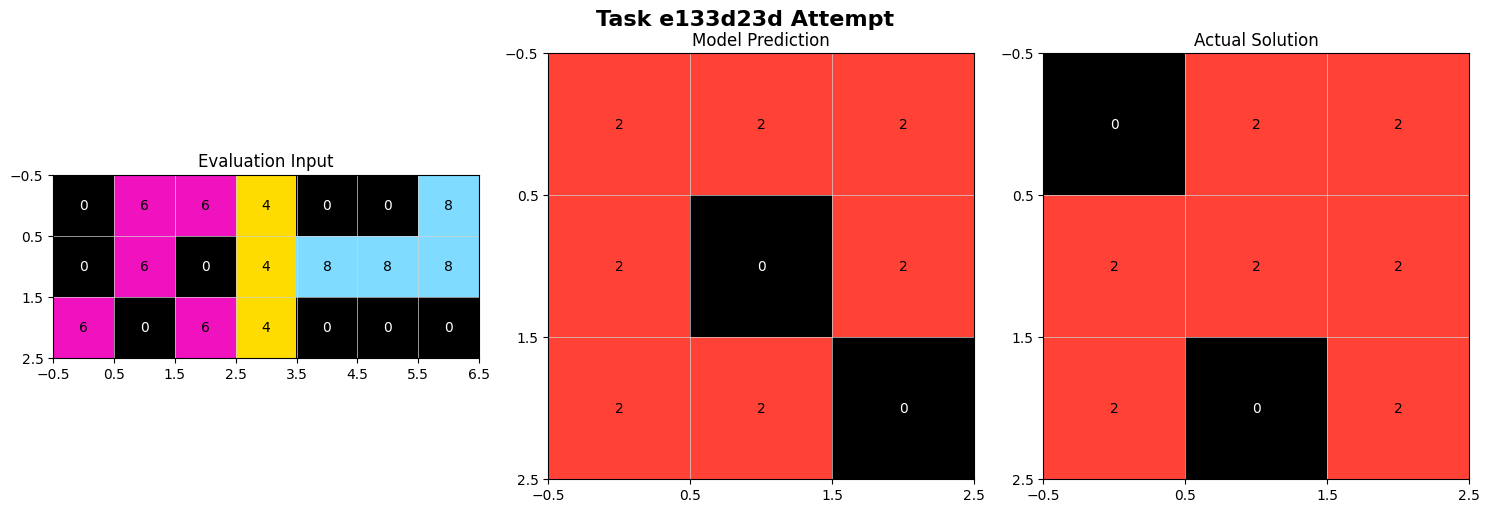


Prediction details for attempt_2, retry 0:
Prediction: [[2, 2, 2], [2, 0, 2], [2, 2, 0]]
Expected solution: [[0, 2, 2], [2, 2, 2], [2, 0, 2]]
2024-12-08 11:40:10,380 - INFO - Starting task #24 (e345f17b), pair #1
2024-12-08 11:40:10,381 - INFO - Plot flag for task e345f17b, attempt 1, retry 0: True
2024-12-08 11:40:10,384 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[6, 6, 6, 6, 5, 0, 5, 0],
[6, 0, 0, 0, 5, 5, 0, 0],
[6, 0, 6, 6, 0, 0, 5, 5],
[0, 0, 6, 0, 0, 5, 5, 0],]

Example 1: Output
[
[0, 0, 0, 0],
[0, 0, 4, 4],
[0, 4, 0, 0],
[4, 0, 0, 4],]

Example 2: Input
[
[0, 6, 6, 0, 5, 5, 5, 0],
[0, 6, 0, 6, 5, 0, 0, 5],
[0, 6, 6, 6, 5, 5, 5, 5],
[6, 0, 0, 0, 0, 5, 0, 5],]

Example 2: Output
[
[0, 0, 0, 4],
[0, 0, 4, 0],
[0, 0, 0, 0],
[0, 0, 4, 0],]

Example 3: Input
[
[6, 6, 6, 0, 5, 0, 5, 5],
[6, 0, 0, 0, 0, 5, 5, 5],
[6, 0, 0, 0, 0, 0, 0, 0],
[0, 6, 6, 6, 5, 5, 0, 0],]

Example 3: Output
[
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 4, 4, 4],
[0, 0, 0, 0],]

Example 4: 

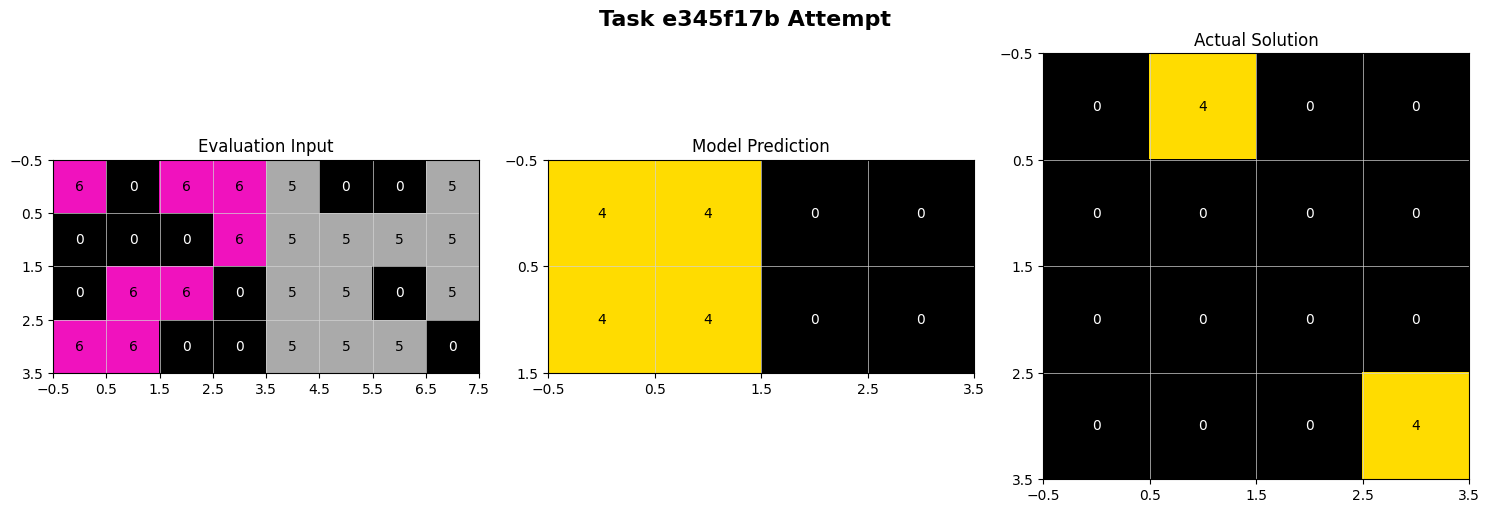


Prediction details for attempt_1, retry 0:
Prediction: [[4, 4, 0, 0], [4, 4, 0, 0]]
Expected solution: [[0, 4, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 4]]
2024-12-08 11:40:32,955 - INFO - Plot flag for task e345f17b, attempt 2, retry 0: True
2024-12-08 11:40:32,957 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[6, 6, 6, 6, 5, 0, 5, 0],
[6, 0, 0, 0, 5, 5, 0, 0],
[6, 0, 6, 6, 0, 0, 5, 5],
[0, 0, 6, 0, 0, 5, 5, 0],]

Example 1: Output
[
[0, 0, 0, 0],
[0, 0, 4, 4],
[0, 4, 0, 0],
[4, 0, 0, 4],]

Example 2: Input
[
[0, 6, 6, 0, 5, 5, 5, 0],
[0, 6, 0, 6, 5, 0, 0, 5],
[0, 6, 6, 6, 5, 5, 5, 5],
[6, 0, 0, 0, 0, 5, 0, 5],]

Example 2: Output
[
[0, 0, 0, 4],
[0, 0, 4, 0],
[0, 0, 0, 0],
[0, 0, 4, 0],]

Example 3: Input
[
[6, 6, 6, 0, 5, 0, 5, 5],
[6, 0, 0, 0, 0, 5, 5, 5],
[6, 0, 0, 0, 0, 0, 0, 0],
[0, 6, 6, 6, 5, 5, 0, 0],]

Example 3: Output
[
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 4, 4, 4],
[0, 0, 0, 0],]

Example 4: Input
[
[6, 0, 6, 0, 0, 0, 5, 5],
[0, 6, 6, 6, 5, 0, 

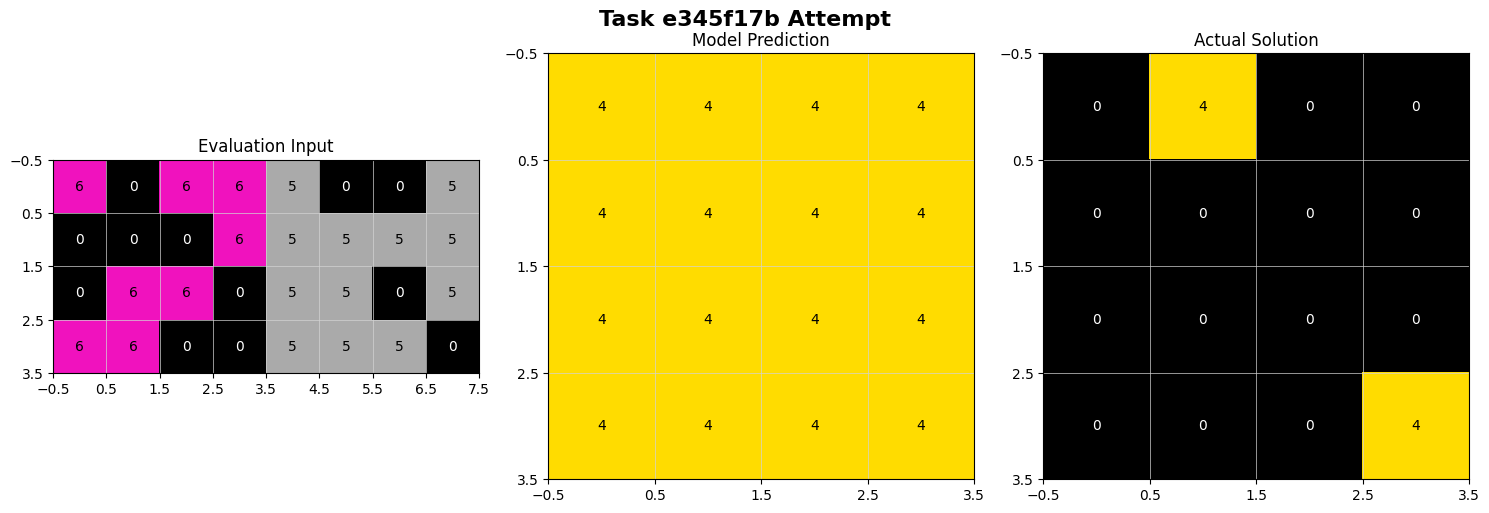


Prediction details for attempt_2, retry 0:
Prediction: [[4, 4, 4, 4], [4, 4, 4, 4], [4, 4, 4, 4], [4, 4, 4, 4]]
Expected solution: [[0, 4, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 4]]
2024-12-08 11:40:59,838 - INFO - Starting task #24 (e345f17b), pair #2
2024-12-08 11:40:59,839 - INFO - Plot flag for task e345f17b, attempt 1, retry 0: True
2024-12-08 11:40:59,841 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[6, 6, 6, 6, 5, 0, 5, 0],
[6, 0, 0, 0, 5, 5, 0, 0],
[6, 0, 6, 6, 0, 0, 5, 5],
[0, 0, 6, 0, 0, 5, 5, 0],]

Example 1: Output
[
[0, 0, 0, 0],
[0, 0, 4, 4],
[0, 4, 0, 0],
[4, 0, 0, 4],]

Example 2: Input
[
[0, 6, 6, 0, 5, 5, 5, 0],
[0, 6, 0, 6, 5, 0, 0, 5],
[0, 6, 6, 6, 5, 5, 5, 5],
[6, 0, 0, 0, 0, 5, 0, 5],]

Example 2: Output
[
[0, 0, 0, 4],
[0, 0, 4, 0],
[0, 0, 0, 0],
[0, 0, 4, 0],]

Example 3: Input
[
[6, 6, 6, 0, 5, 0, 5, 5],
[6, 0, 0, 0, 0, 5, 5, 5],
[6, 0, 0, 0, 0, 0, 0, 0],
[0, 6, 6, 6, 5, 5, 0, 0],]

Example 3: Output
[
[0, 0, 0, 0],
[0, 0, 0,

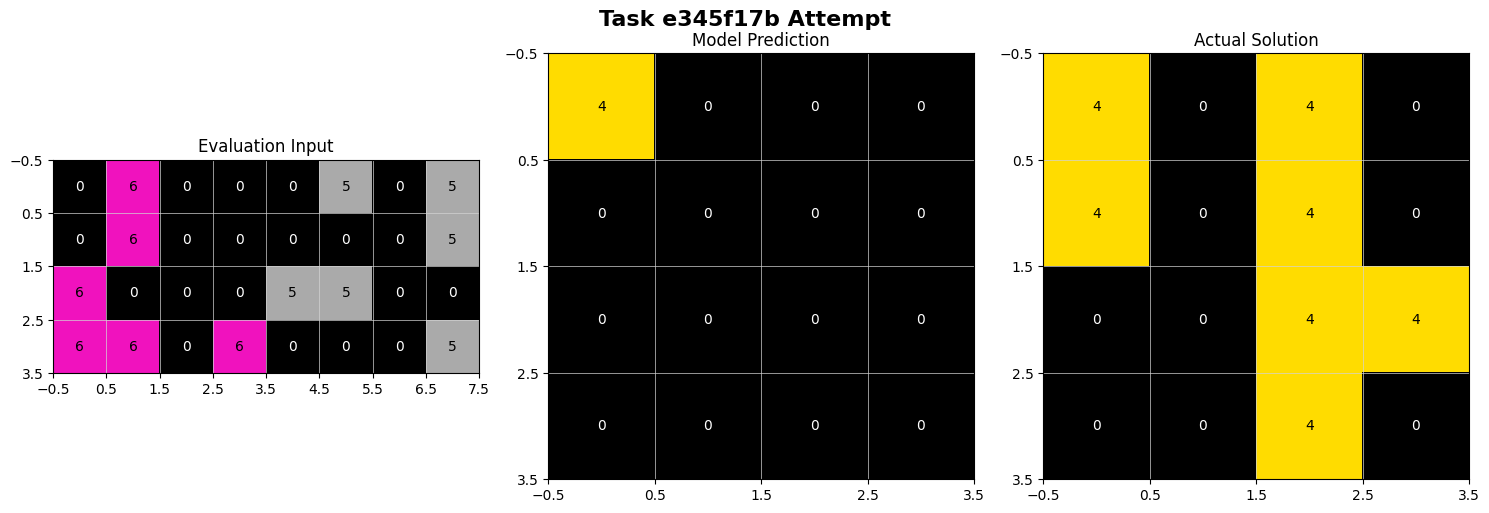


Prediction details for attempt_1, retry 0:
Prediction: [[4, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Expected solution: [[4, 0, 4, 0], [4, 0, 4, 0], [0, 0, 4, 4], [0, 0, 4, 0]]
2024-12-08 11:41:20,139 - INFO - Plot flag for task e345f17b, attempt 2, retry 0: True
2024-12-08 11:41:20,142 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[6, 6, 6, 6, 5, 0, 5, 0],
[6, 0, 0, 0, 5, 5, 0, 0],
[6, 0, 6, 6, 0, 0, 5, 5],
[0, 0, 6, 0, 0, 5, 5, 0],]

Example 1: Output
[
[0, 0, 0, 0],
[0, 0, 4, 4],
[0, 4, 0, 0],
[4, 0, 0, 4],]

Example 2: Input
[
[0, 6, 6, 0, 5, 5, 5, 0],
[0, 6, 0, 6, 5, 0, 0, 5],
[0, 6, 6, 6, 5, 5, 5, 5],
[6, 0, 0, 0, 0, 5, 0, 5],]

Example 2: Output
[
[0, 0, 0, 4],
[0, 0, 4, 0],
[0, 0, 0, 0],
[0, 0, 4, 0],]

Example 3: Input
[
[6, 6, 6, 0, 5, 0, 5, 5],
[6, 0, 0, 0, 0, 5, 5, 5],
[6, 0, 0, 0, 0, 0, 0, 0],
[0, 6, 6, 6, 5, 5, 0, 0],]

Example 3: Output
[
[0, 0, 0, 0],
[0, 0, 0, 0],
[0, 4, 4, 4],
[0, 0, 0, 0],]

Example 4: Input
[
[6, 0, 6, 0, 0, 0

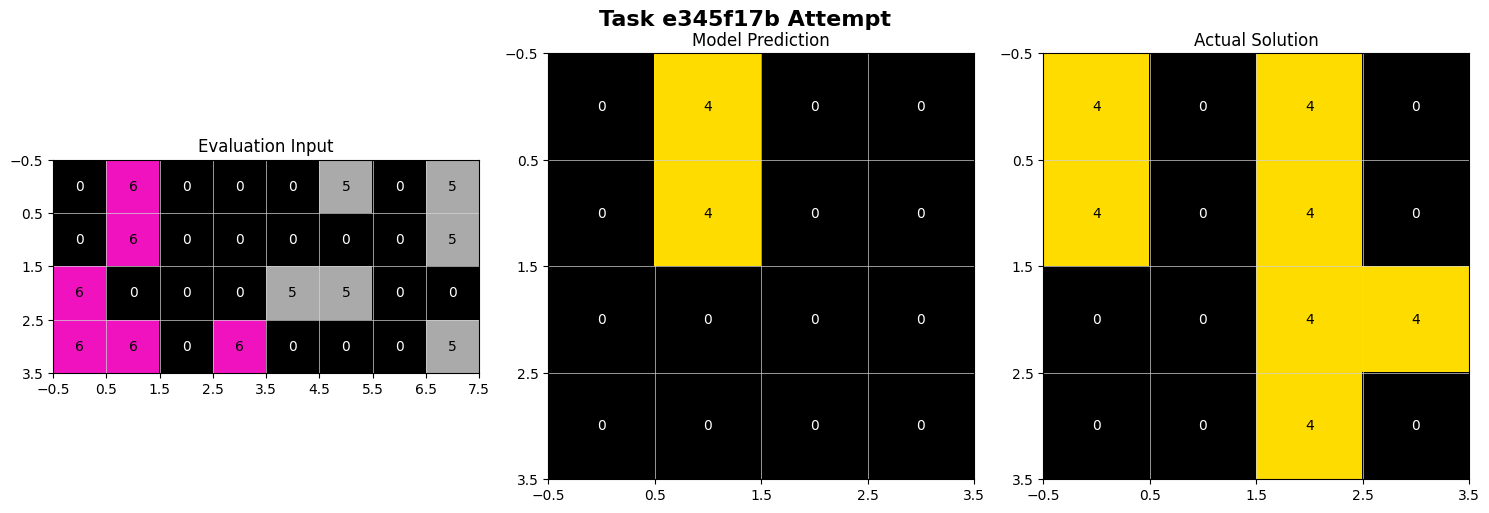


Prediction details for attempt_2, retry 0:
Prediction: [[0, 4, 0, 0], [0, 4, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
Expected solution: [[4, 0, 4, 0], [4, 0, 4, 0], [0, 0, 4, 4], [0, 0, 4, 0]]
2024-12-08 11:41:47,843 - INFO - Starting task #25 (e633a9e5), pair #1
2024-12-08 11:41:47,844 - INFO - Plot flag for task e633a9e5, attempt 1, retry 0: True
2024-12-08 11:41:47,846 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[6, 5, 5],
[5, 1, 7],
[4, 5, 2],]

Example 1: Output
[
[6, 6, 5, 5, 5],
[6, 6, 5, 5, 5],
[5, 5, 1, 7, 7],
[4, 4, 5, 2, 2],
[4, 4, 5, 2, 2],]

Example 2: Input
[
[1, 3, 5],
[1, 2, 8],
[8, 3, 8],]

Example 2: Output
[
[1, 1, 3, 5, 5],
[1, 1, 3, 5, 5],
[1, 1, 2, 8, 8],
[8, 8, 3, 8, 8],
[8, 8, 3, 8, 8],]

Example 3: Input
[
[2, 3, 7],
[2, 1, 6],
[1, 5, 7],]

Example 3: Output
[
[2, 2, 3, 7, 7],
[2, 2, 3, 7, 7],
[2, 2, 1, 6, 6],
[1, 1, 5, 7, 7],
[1, 1, 5, 7, 7],]

Test
[
[1, 2, 5]
[7, 3, 6]
[7, 6, 5]]

Your Response: with predicted grid size: 5x5
Debug -

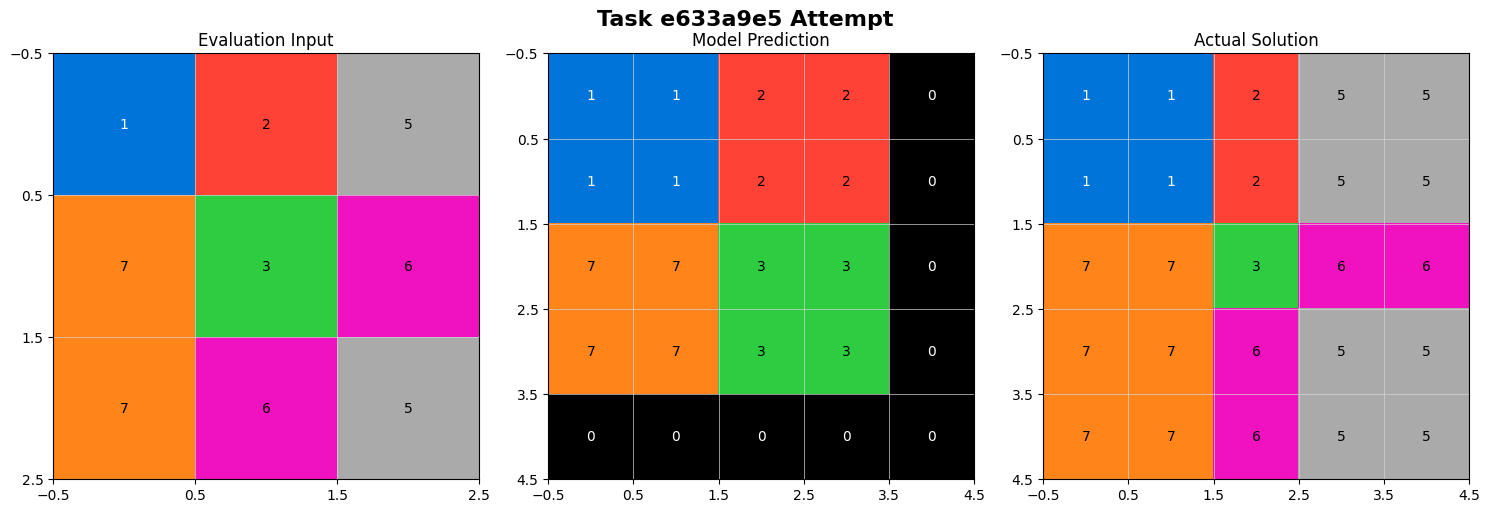


Prediction details for attempt_1, retry 0:
Prediction: [[1, 1, 2, 2, 0], [1, 1, 2, 2, 0], [7, 7, 3, 3, 0], [7, 7, 3, 3, 0], [0, 0, 0, 0, 0]]
Expected solution: [[1, 1, 2, 5, 5], [1, 1, 2, 5, 5], [7, 7, 3, 6, 6], [7, 7, 6, 5, 5], [7, 7, 6, 5, 5]]
2024-12-08 11:42:02,074 - INFO - Plot flag for task e633a9e5, attempt 2, retry 0: True
2024-12-08 11:42:02,076 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[6, 5, 5],
[5, 1, 7],
[4, 5, 2],]

Example 1: Output
[
[6, 6, 5, 5, 5],
[6, 6, 5, 5, 5],
[5, 5, 1, 7, 7],
[4, 4, 5, 2, 2],
[4, 4, 5, 2, 2],]

Example 2: Input
[
[1, 3, 5],
[1, 2, 8],
[8, 3, 8],]

Example 2: Output
[
[1, 1, 3, 5, 5],
[1, 1, 3, 5, 5],
[1, 1, 2, 8, 8],
[8, 8, 3, 8, 8],
[8, 8, 3, 8, 8],]

Example 3: Input
[
[2, 3, 7],
[2, 1, 6],
[1, 5, 7],]

Example 3: Output
[
[2, 2, 3, 7, 7],
[2, 2, 3, 7, 7],
[2, 2, 1, 6, 6],
[1, 1, 5, 7, 7],
[1, 1, 5, 7, 7],]

Test
[
[1, 2, 5]
[7, 3, 6]
[7, 6, 5]]

Your Response: with predicted grid size: 5x5
Debug - Plotting dim

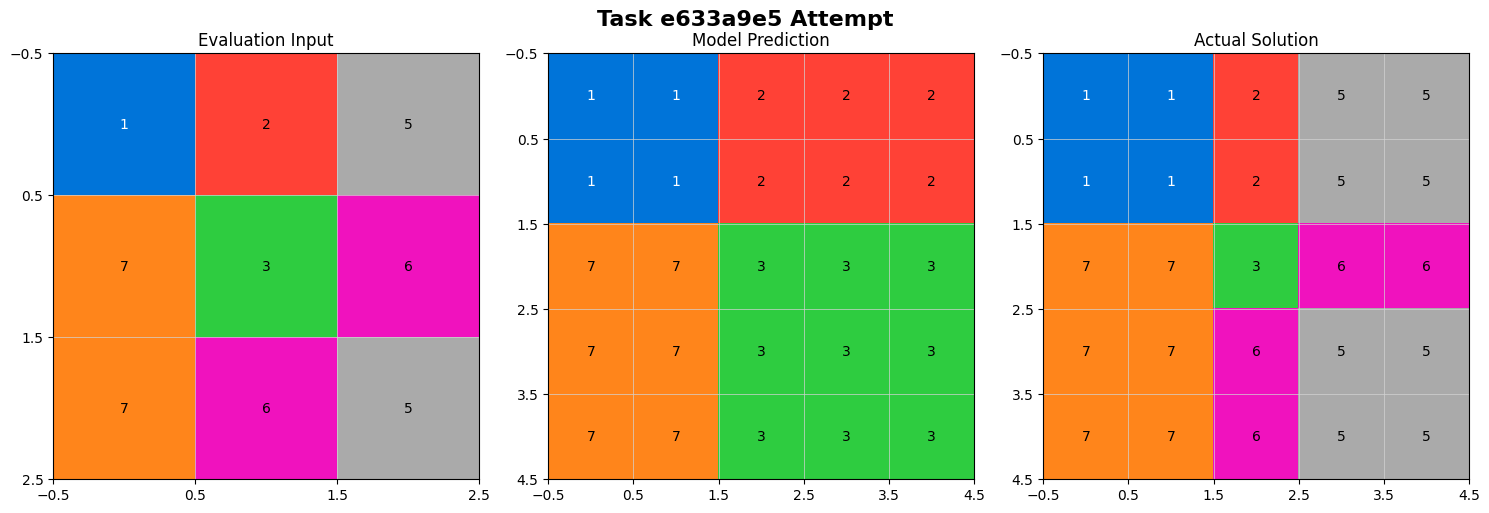


Prediction details for attempt_2, retry 0:
Prediction: [[1, 1, 2, 2, 2], [1, 1, 2, 2, 2], [7, 7, 3, 3, 3], [7, 7, 3, 3, 3], [7, 7, 3, 3, 3]]
Expected solution: [[1, 1, 2, 5, 5], [1, 1, 2, 5, 5], [7, 7, 3, 6, 6], [7, 7, 6, 5, 5], [7, 7, 6, 5, 5]]
2024-12-08 11:42:20,013 - INFO - Starting task #26 (ed74f2f2), pair #1
2024-12-08 11:42:20,015 - INFO - Plot flag for task ed74f2f2, attempt 1, retry 0: True
2024-12-08 11:42:20,017 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 5, 5, 0, 0, 5, 5, 5, 0],
[0, 0, 5, 0, 0, 5, 0, 5, 0],
[0, 0, 5, 5, 0, 5, 0, 5, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[2, 2, 2],
[2, 0, 2],
[2, 0, 2],]

Example 2: Input
[
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 5, 5, 0, 5, 0, 5, 0],
[0, 0, 5, 0, 0, 5, 0, 5, 0],
[0, 5, 5, 0, 0, 5, 5, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[3, 0, 3],
[3, 0, 3],
[3, 3, 0],]

Example 3: Input
[
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 5, 5, 5, 0, 5, 0, 5, 0

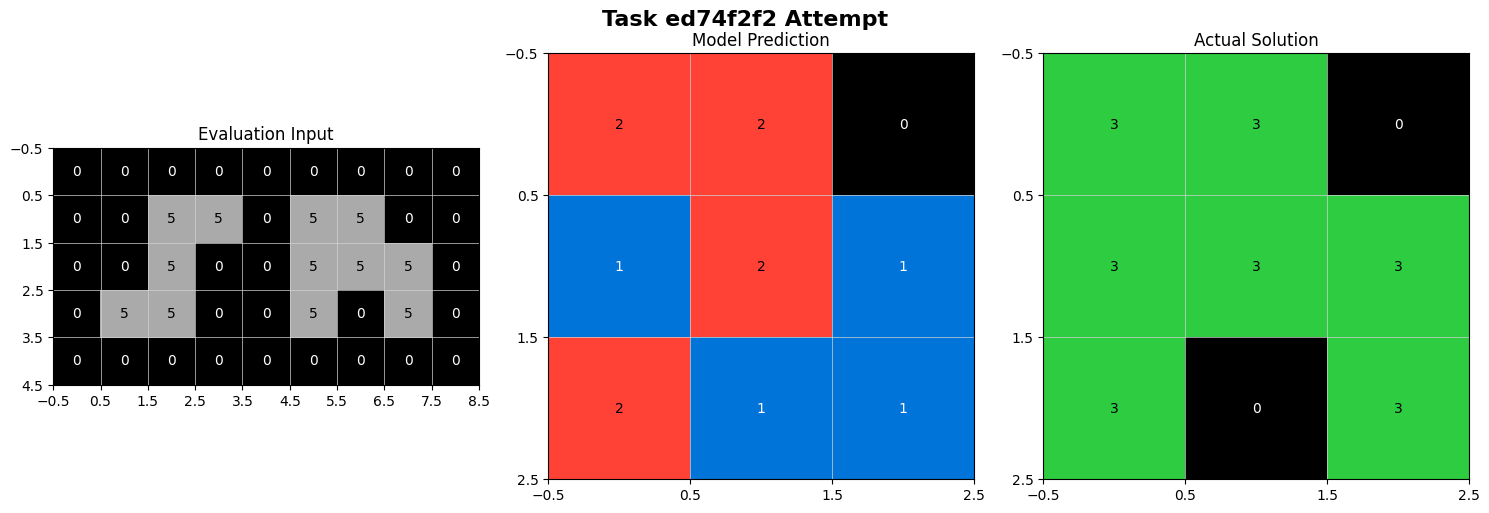


Prediction details for attempt_1, retry 0:
Prediction: [[2, 2, 0], [1, 2, 1], [2, 1, 1]]
Expected solution: [[3, 3, 0], [3, 3, 3], [3, 0, 3]]
2024-12-08 11:42:42,637 - INFO - Plot flag for task ed74f2f2, attempt 2, retry 0: True
2024-12-08 11:42:42,639 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 5, 5, 0, 0, 5, 5, 5, 0],
[0, 0, 5, 0, 0, 5, 0, 5, 0],
[0, 0, 5, 5, 0, 5, 0, 5, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 1: Output
[
[2, 2, 2],
[2, 0, 2],
[2, 0, 2],]

Example 2: Input
[
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 5, 5, 0, 5, 0, 5, 0],
[0, 0, 5, 0, 0, 5, 0, 5, 0],
[0, 5, 5, 0, 0, 5, 5, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 2: Output
[
[3, 0, 3],
[3, 0, 3],
[3, 3, 0],]

Example 3: Input
[
[0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 5, 5, 5, 0, 5, 0, 5, 0],
[0, 0, 5, 0, 0, 0, 5, 5, 0],
[0, 0, 5, 0, 0, 5, 0, 5, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0],]

Example 3: Output
[
[1, 0, 1],
[0, 1, 1],
[1, 0, 1],]

Example 4: Input
[
[0, 0, 0,

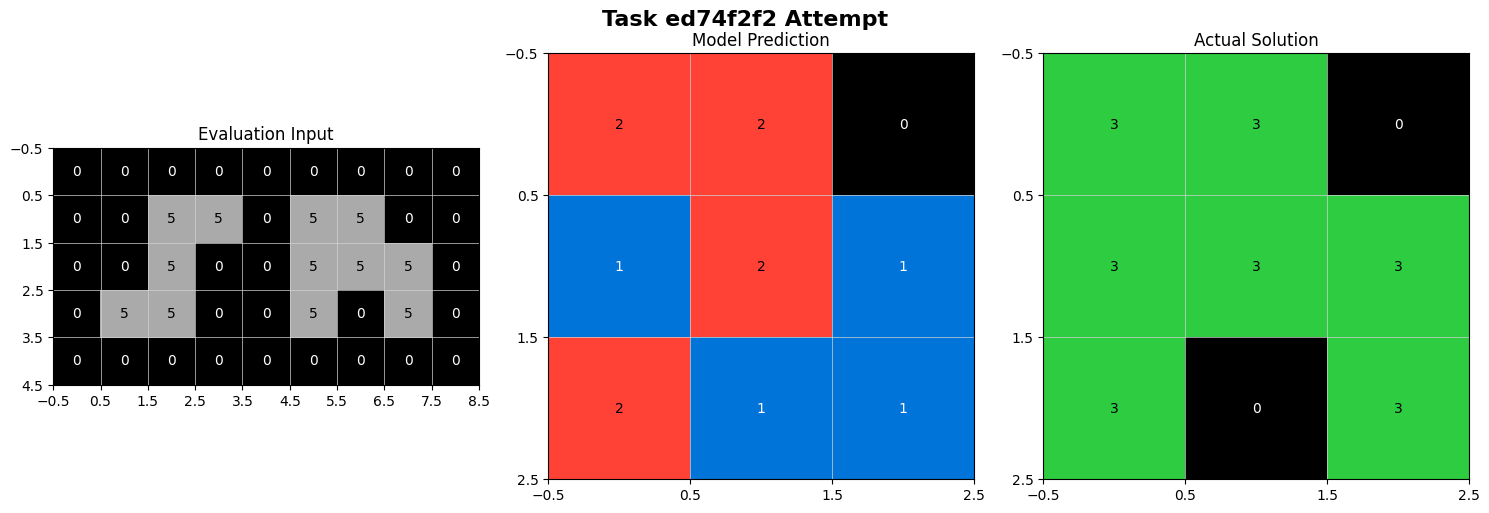


Prediction details for attempt_2, retry 0:
Prediction: [[2, 2, 0], [1, 2, 1], [2, 1, 1]]
Expected solution: [[3, 3, 0], [3, 3, 3], [3, 0, 3]]
2024-12-08 11:43:04,084 - INFO - Starting task #27 (ed98d772), pair #1
2024-12-08 11:43:04,085 - INFO - Plot flag for task ed98d772, attempt 1, retry 0: True
2024-12-08 11:43:04,088 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 9],
[0, 0, 0],
[9, 9, 0],]

Example 1: Output
[
[9, 9, 9, 9, 0, 0],
[0, 0, 0, 9, 0, 9],
[9, 9, 0, 9, 0, 9],
[0, 9, 9, 9, 0, 9],
[0, 0, 0, 9, 0, 9],
[9, 9, 9, 0, 0, 9],]

Example 2: Input
[
[3, 0, 3],
[0, 3, 3],
[3, 3, 3],]

Example 2: Output
[
[3, 0, 3, 3, 3, 3],
[0, 3, 3, 0, 3, 3],
[3, 3, 3, 3, 0, 3],
[3, 3, 3, 3, 0, 3],
[3, 3, 0, 3, 3, 0],
[3, 0, 3, 3, 3, 3],]

Example 3: Input
[
[3, 3, 3],
[0, 0, 3],
[3, 0, 0],]

Example 3: Output
[
[3, 3, 3, 3, 3, 0],
[0, 0, 3, 3, 0, 0],
[3, 0, 0, 3, 0, 3],
[0, 0, 3, 3, 0, 3],
[3, 0, 0, 0, 0, 3],
[3, 3, 3, 0, 3, 3],]

Example 4: Input
[
[8, 0, 8],
[8

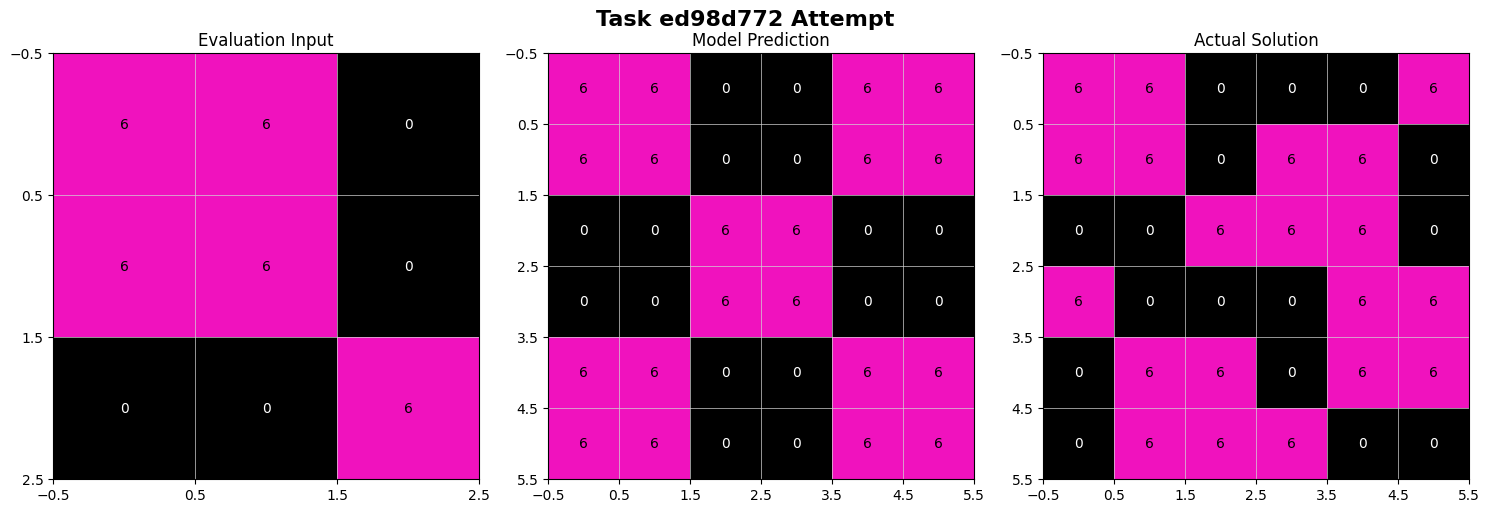


Prediction details for attempt_1, retry 0:
Prediction: [[6, 6, 0, 0, 6, 6], [6, 6, 0, 0, 6, 6], [0, 0, 6, 6, 0, 0], [0, 0, 6, 6, 0, 0], [6, 6, 0, 0, 6, 6], [6, 6, 0, 0, 6, 6]]
Expected solution: [[6, 6, 0, 0, 0, 6], [6, 6, 0, 6, 6, 0], [0, 0, 6, 6, 6, 0], [6, 0, 0, 0, 6, 6], [0, 6, 6, 0, 6, 6], [0, 6, 6, 6, 0, 0]]
2024-12-08 11:43:22,943 - INFO - Plot flag for task ed98d772, attempt 2, retry 0: True
2024-12-08 11:43:22,945 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[9, 9, 9],
[0, 0, 0],
[9, 9, 0],]

Example 1: Output
[
[9, 9, 9, 9, 0, 0],
[0, 0, 0, 9, 0, 9],
[9, 9, 0, 9, 0, 9],
[0, 9, 9, 9, 0, 9],
[0, 0, 0, 9, 0, 9],
[9, 9, 9, 0, 0, 9],]

Example 2: Input
[
[3, 0, 3],
[0, 3, 3],
[3, 3, 3],]

Example 2: Output
[
[3, 0, 3, 3, 3, 3],
[0, 3, 3, 0, 3, 3],
[3, 3, 3, 3, 0, 3],
[3, 3, 3, 3, 0, 3],
[3, 3, 0, 3, 3, 0],
[3, 0, 3, 3, 3, 3],]

Example 3: Input
[
[3, 3, 3],
[0, 0, 3],
[3, 0, 0],]

Example 3: Output
[
[3, 3, 3, 3, 3, 0],
[0, 0, 3, 3, 0, 0],
[3, 0, 0, 3

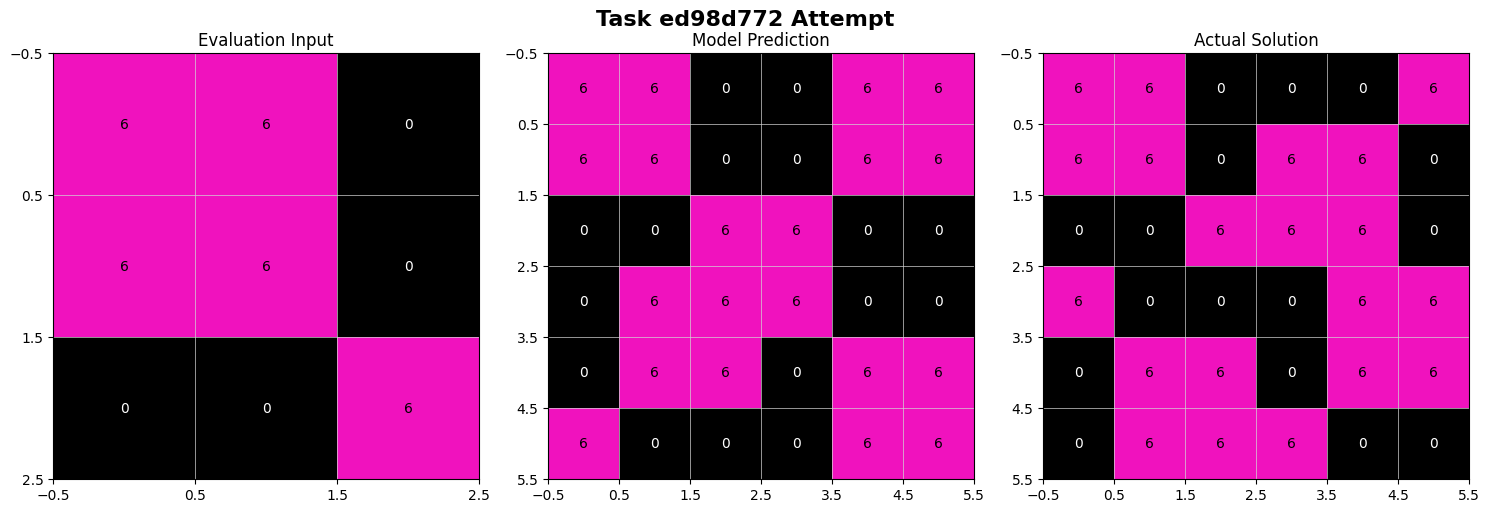


Prediction details for attempt_2, retry 0:
Prediction: [[6, 6, 0, 0, 6, 6], [6, 6, 0, 0, 6, 6], [0, 0, 6, 6, 0, 0], [0, 6, 6, 6, 0, 0], [0, 6, 6, 0, 6, 6], [6, 0, 0, 0, 6, 6]]
Expected solution: [[6, 6, 0, 0, 0, 6], [6, 6, 0, 6, 6, 0], [0, 0, 6, 6, 6, 0], [6, 0, 0, 0, 6, 6], [0, 6, 6, 0, 6, 6], [0, 6, 6, 6, 0, 0]]
2024-12-08 11:43:42,061 - INFO - Starting task #28 (fc754716), pair #1
2024-12-08 11:43:42,062 - INFO - Plot flag for task fc754716, attempt 1, retry 0: True
2024-12-08 11:43:42,064 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0],
[0, 2, 0],
[0, 0, 0],]

Example 1: Output
[
[2, 2, 2],
[2, 0, 2],
[2, 2, 2],]

Example 2: Input
[
[0, 0, 0],
[0, 0, 0],
[0, 3, 0],
[0, 0, 0],
[0, 0, 0],]

Example 2: Output
[
[3, 3, 3],
[3, 0, 3],
[3, 0, 3],
[3, 0, 3],
[3, 3, 3],]

Example 3: Input
[
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0],]

Example 3: Output
[
[1, 1, 1, 1, 1, 1, 1],
[1, 0

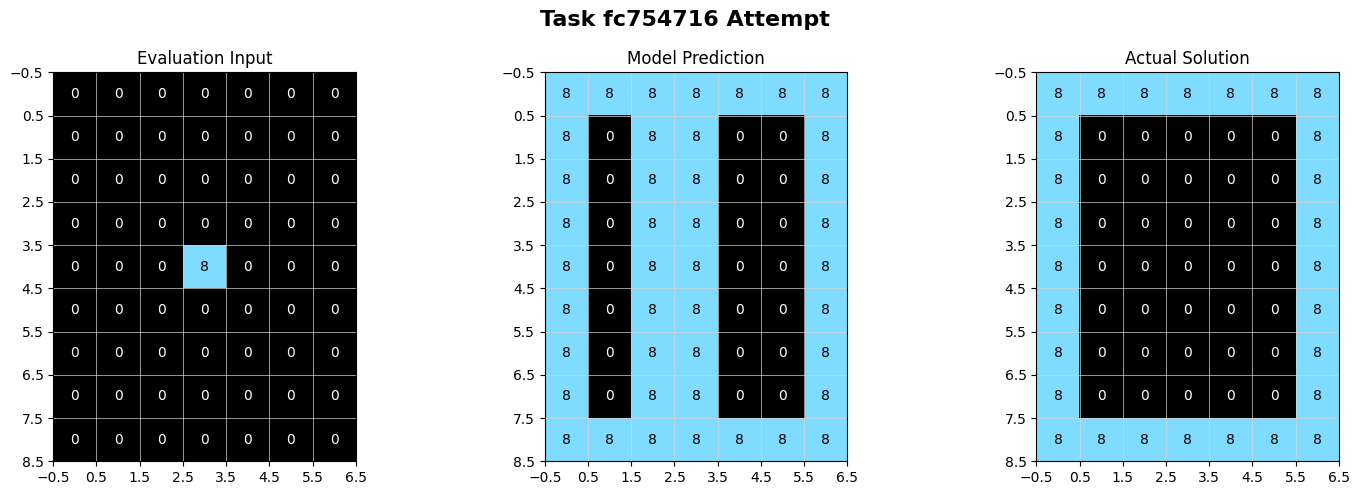


Prediction details for attempt_1, retry 0:
Prediction: [[8, 8, 8, 8, 8, 8, 8], [8, 0, 8, 8, 0, 0, 8], [8, 0, 8, 8, 0, 0, 8], [8, 0, 8, 8, 0, 0, 8], [8, 0, 8, 8, 0, 0, 8], [8, 0, 8, 8, 0, 0, 8], [8, 0, 8, 8, 0, 0, 8], [8, 0, 8, 8, 0, 0, 8], [8, 8, 8, 8, 8, 8, 8]]
Expected solution: [[8, 8, 8, 8, 8, 8, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 8, 8, 8, 8, 8, 8]]
2024-12-08 11:44:02,988 - INFO - Plot flag for task fc754716, attempt 2, retry 0: True
2024-12-08 11:44:02,991 - INFO - Identifying logic for task: Training Examples
Example 1: Input
[
[0, 0, 0],
[0, 2, 0],
[0, 0, 0],]

Example 1: Output
[
[2, 2, 2],
[2, 0, 2],
[2, 2, 2],]

Example 2: Input
[
[0, 0, 0],
[0, 0, 0],
[0, 3, 0],
[0, 0, 0],
[0, 0, 0],]

Example 2: Output
[
[3, 3, 3],
[3, 0, 3],
[3, 0, 3],
[3, 0, 3],
[3, 3, 3],]

Example 3: Input
[
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 1, 0, 

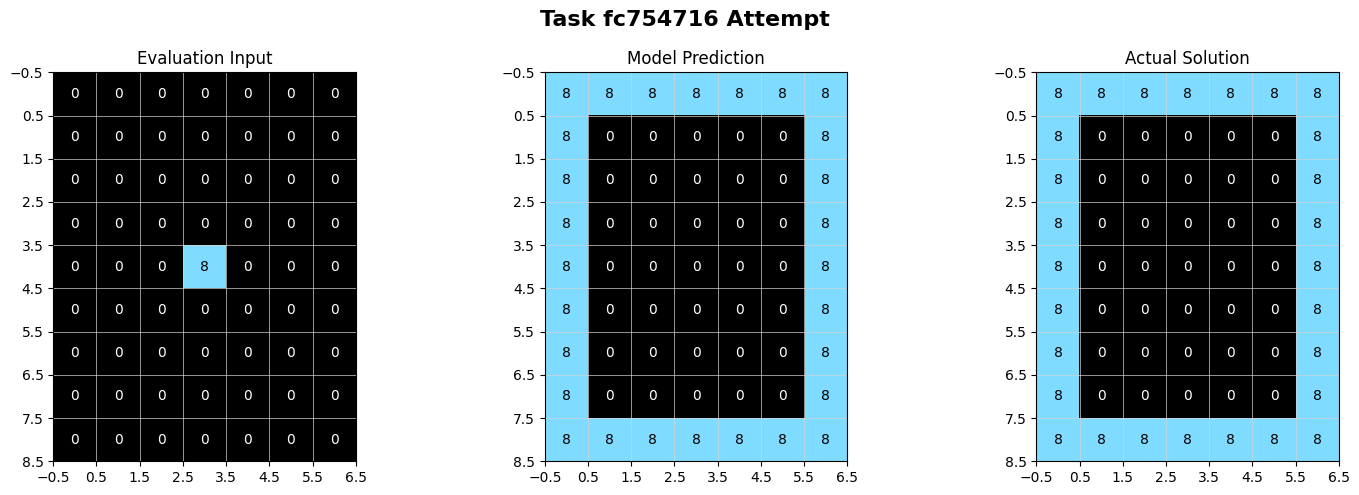


Prediction details for attempt_2, retry 0:
Prediction: [[8, 8, 8, 8, 8, 8, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 8, 8, 8, 8, 8, 8]]
Expected solution: [[8, 8, 8, 8, 8, 8, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 0, 0, 0, 0, 0, 8], [8, 8, 8, 8, 8, 8, 8]]
Found correct solution in attempt_2, retry 0
Submission saved to submission.json
Scoring submission.json


Scoring task 00576224:
Number of test pairs: 1

Scoring Task 00576224 pair #1
Attempts available: ['attempt_1', 'attempt_2']

Checking attempt_1:
Attempt solution: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
Correct solution: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2]

In [44]:
main(task_set='evaluation', NUM_TASKS=28)